## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal\calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        print(fname)
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
#        cv2.imshow('img',img)
        cv2.imwrite("output_images\calibration_corners.jpg", img)
#        cv2.waitKey(500)

cv2.destroyAllWindows()

objpointsArr = np.array(objpoints)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,imgpoints, gray.shape[::-1], None, None)

camera_cal\calibration10.jpg
camera_cal\calibration11.jpg
camera_cal\calibration12.jpg
camera_cal\calibration13.jpg
camera_cal\calibration14.jpg
camera_cal\calibration15.jpg
camera_cal\calibration16.jpg
camera_cal\calibration17.jpg
camera_cal\calibration18.jpg
camera_cal\calibration19.jpg
camera_cal\calibration2.jpg
camera_cal\calibration20.jpg
camera_cal\calibration3.jpg
camera_cal\calibration6.jpg
camera_cal\calibration7.jpg
camera_cal\calibration8.jpg
camera_cal\calibration9.jpg


## Function to undistort images

In [6]:
def cal_undistort(img):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist



In [4]:
def detect_edges(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 255
    
    # Threshold color channel
    s_binary = np.zeros_like(scaled_sobel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 255
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.

    color_binary = np.zeros_like(scaled_sobel).astype(np.uint8)
    color_binary[(s_binary > 0) | (sxbinary > 0)] = 255
    
    return color_binary

In [29]:
import matplotlib.pyplot as plt

def find_line_fit(binary_warped, Minv):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
   
    left_eval = np.max(lefty)
    right_eval = np.max(righty)
    left_curverad = ((1 + (2*left_fit[0]*left_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*right_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*left_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*right_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print("Curvature", left_curverad, 'm', right_curverad, 'm')
   
    # measure offset from center
    offset = 100
    y_bottom = binary_warped.shape[0] - offset
    x_left = left_fit[0]*y_bottom*y_bottom + left_fit[1]*y_bottom + left_fit[2]
    x_right = right_fit[0]*y_bottom*y_bottom + right_fit[1]*y_bottom + right_fit[2]
    x_center = int((x_left + x_right) / 2)
    x_image_center = binary_warped.shape[1] / 2
    x_offset_from_center = abs(x_center - x_image_center)*xm_per_pix
    print("Offset from center", x_offset_from_center)
    
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (binary_warped.shape[1], binary_warped.shape[0]))
    
    plt.figure()
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='green', linewidth=3)
    plt.plot(right_fitx, ploty, color='green', linewidth=3)
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    return newwarp

In [30]:
def pipeline(img):
    undistorted = cal_undistort(img)
    cv2.imwrite("output_images/undistorted.jpg", undistorted)
    edges = detect_edges(undistorted)
    cv2.imwrite("output_images/binary.jpg", edges)
    edges = np.array(edges)
    
    #edges = undistorted
    offset = 180
    img_size = (edges.shape[1], edges.shape[0])
    src = np.float32([[560,475], [724, 475], [1028,670], [270,670]])
    dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                     [img_size[0]-offset, img_size[1]-offset], 
                     [offset, img_size[1]-offset]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    
    warped = cv2.warpPerspective(edges, M, img_size)
    cv2.imwrite("output_images/warped.jpg", warped)
    new_warped = find_line_fit(warped, Minv)
    result = cv2.addWeighted(undistorted[200:,:], 1, new_warped[200:,:], 0.3, 0)
    return result

test_images\straight_lines1.jpg
Curvature 20504.4500762 m 1819.17994072 m
Offset from center 0.05285714285714286


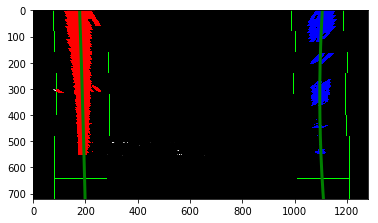

In [31]:
test_images = glob.glob("test_images\*.jpg")
count = 0
for filename in test_images:
    print (filename)
    img = cv2.imread(filename)
    warped = pipeline(img)
    output_name = "warped" + str(count) + ".jpg"
    count = count + 1
    cv2.imwrite("output_images\\" + output_name, warped)
    break

In [25]:
# Import everything needed to edit/save/watch video clips
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [26]:
isFirstFrame = True

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    warped = pipeline(image)
    return warped

In [27]:
white_output = 'project_video_result.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Curvature 261.24409063 m 474.109560983 m
Offset from center 0.4704285714285715
[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

Curvature 261.24409063 m 474.109560983 m
Offset from center 0.4704285714285715


  0%|          | 1/1261 [00:00<03:28,  6.04it/s]

Curvature 266.263181297 m 544.351332086 m
Offset from center 0.4968571428571429


  0%|          | 2/1261 [00:00<03:36,  5.82it/s]

Curvature 273.626861252 m 237.229863262 m
Offset from center 0.42814285714285716


  0%|          | 3/1261 [00:00<03:42,  5.66it/s]

Curvature 290.315874073 m 262.322462808 m
Offset from center 0.4651428571428572


  0%|          | 4/1261 [00:00<03:43,  5.62it/s]

Curvature 276.651730714 m 324.992025705 m
Offset from center 0.4862857142857143


  0%|          | 5/1261 [00:00<03:44,  5.60it/s]

Curvature 274.9291472 m 376.47682169 m
Offset from center 0.5127142857142858


  0%|          | 6/1261 [00:01<03:56,  5.31it/s]

Curvature 288.408745492 m 448.798130484 m
Offset from center 0.5444285714285715


  1%|          | 7/1261 [00:01<04:06,  5.10it/s]

Curvature 285.849438549 m 2132.4870947 m
Offset from center 0.7082857142857143


  1%|          | 8/1261 [00:01<04:01,  5.18it/s]

Curvature 302.835914199 m 1120.95012517 m
Offset from center 0.7241428571428572


  1%|          | 9/1261 [00:01<04:06,  5.08it/s]

Curvature 309.6539489 m 2259.91319993 m
Offset from center 0.6977142857142857


  1%|          | 10/1261 [00:01<04:12,  4.95it/s]

Curvature 319.361302071 m 557.223979306 m
Offset from center 0.5867142857142857


  1%|          | 11/1261 [00:02<04:03,  5.13it/s]

Curvature 344.859480327 m 654.787940332 m
Offset from center 0.5920000000000001


  1%|          | 12/1261 [00:02<03:54,  5.32it/s]

Curvature 351.972393624 m 799.362723732 m
Offset from center 0.6025714285714286


  1%|          | 13/1261 [00:02<03:46,  5.51it/s]

Curvature 356.983125486 m 3261.92593181 m
Offset from center 0.6237142857142858


  1%|          | 14/1261 [00:02<03:44,  5.55it/s]

Curvature 422.050331565 m 368.748607385 m
Offset from center 0.5602857142857143


  1%|          | 15/1261 [00:02<03:41,  5.62it/s]

Curvature 501.050906735 m 354.308117749 m
Offset from center 0.555


  1%|▏         | 16/1261 [00:02<03:44,  5.53it/s]

Curvature 420.029847674 m 532.241990119 m
Offset from center 0.5602857142857143


  1%|▏         | 17/1261 [00:03<03:44,  5.54it/s]

Curvature 482.661581796 m 513.285199689 m
Offset from center 0.5708571428571428


  1%|▏         | 18/1261 [00:03<03:41,  5.60it/s]

Curvature 482.402829125 m 638.232141818 m
Offset from center 0.5761428571428572


  2%|▏         | 19/1261 [00:03<03:39,  5.65it/s]

Curvature 505.222279702 m 782.507283866 m
Offset from center 0.5814285714285714


  2%|▏         | 20/1261 [00:03<03:51,  5.36it/s]

Curvature 528.678518816 m 735.003097042 m
Offset from center 0.5708571428571428


  2%|▏         | 21/1261 [00:03<03:47,  5.46it/s]

Curvature 551.42156254 m 4318.29982928 m
Offset from center 0.6237142857142858


  2%|▏         | 22/1261 [00:04<03:45,  5.50it/s]

Curvature 533.462752649 m 10929.3411822 m
Offset from center 0.5972857142857143


  2%|▏         | 23/1261 [00:04<03:50,  5.36it/s]

Curvature 471.944596481 m 496.326778789 m
Offset from center 0.4862857142857143


  2%|▏         | 24/1261 [00:04<03:46,  5.46it/s]

Curvature 397.748680358 m 344.215015015 m
Offset from center 0.444


  2%|▏         | 25/1261 [00:04<03:50,  5.36it/s]

Curvature 417.685926831 m 429.587100413 m
Offset from center 0.45457142857142857


  2%|▏         | 26/1261 [00:04<03:40,  5.60it/s]

Curvature 369.834004796 m 629.700795783 m
Offset from center 0.45985714285714285


  2%|▏         | 27/1261 [00:04<03:32,  5.80it/s]

Curvature 361.682491523 m 949.541322668 m
Offset from center 0.45985714285714285


  2%|▏         | 28/1261 [00:05<03:29,  5.90it/s]

Curvature 386.378364271 m 297.057891981 m
Offset from center 0.40700000000000003


  2%|▏         | 29/1261 [00:05<03:40,  5.59it/s]

Curvature 398.816916733 m 274.750492183 m
Offset from center 0.4122857142857143


  2%|▏         | 30/1261 [00:05<03:33,  5.77it/s]

Curvature 313.396893382 m 383.526492817 m
Offset from center 0.4228571428571429


  2%|▏         | 31/1261 [00:05<03:31,  5.81it/s]

Curvature 288.91234412 m 370.273254513 m
Offset from center 0.4228571428571429


  3%|▎         | 32/1261 [00:05<03:27,  5.91it/s]

Curvature 297.617922902 m 501.084787965 m
Offset from center 0.45457142857142857


  3%|▎         | 33/1261 [00:05<03:21,  6.11it/s]

Curvature 269.147640973 m 2996.70674817 m
Offset from center 0.5497142857142857


  3%|▎         | 34/1261 [00:06<03:21,  6.08it/s]

Curvature 263.482960348 m 622.483749797 m
Offset from center 0.4704285714285715


  3%|▎         | 35/1261 [00:06<03:20,  6.12it/s]

Curvature 247.491497538 m 375.052378155 m
Offset from center 0.42814285714285716


  3%|▎         | 36/1261 [00:06<03:19,  6.15it/s]

Curvature 244.763530128 m 359.42675295 m
Offset from center 0.4228571428571429


  3%|▎         | 37/1261 [00:06<03:19,  6.15it/s]

Curvature 228.454702784 m 644.551208884 m
Offset from center 0.4704285714285715


  3%|▎         | 38/1261 [00:06<03:18,  6.16it/s]

Curvature 217.451240332 m 432.076212257 m
Offset from center 0.43342857142857144


  3%|▎         | 39/1261 [00:06<03:16,  6.22it/s]

Curvature 215.432704246 m 222.50263567 m
Offset from center 0.37


  3%|▎         | 40/1261 [00:07<03:15,  6.24it/s]

Curvature 212.162287883 m 275.537922902 m
Offset from center 0.40171428571428575


  3%|▎         | 41/1261 [00:07<03:17,  6.17it/s]

Curvature 225.917735663 m 319.077378195 m
Offset from center 0.43342857142857144


  3%|▎         | 42/1261 [00:07<03:16,  6.21it/s]

Curvature 231.664685917 m 370.510149778 m
Offset from center 0.45985714285714285


  3%|▎         | 43/1261 [00:07<03:31,  5.76it/s]

Curvature 231.426291424 m 343.99748752 m
Offset from center 0.45457142857142857


  3%|▎         | 44/1261 [00:07<03:31,  5.75it/s]

Curvature 252.550806699 m 333.987673684 m
Offset from center 0.4704285714285715


  4%|▎         | 45/1261 [00:07<03:28,  5.83it/s]

Curvature 266.760320099 m 481.860023115 m
Offset from center 0.5232857142857144


  4%|▎         | 46/1261 [00:08<03:31,  5.76it/s]

Curvature 282.899939236 m 730.541145646 m
Offset from center 0.555


  4%|▎         | 47/1261 [00:08<03:30,  5.78it/s]

Curvature 284.243041603 m 1076.43222542 m
Offset from center 0.5814285714285714


  4%|▍         | 48/1261 [00:08<03:29,  5.80it/s]

Curvature 292.804845644 m 629.563579219 m
Offset from center 0.5444285714285715


  4%|▍         | 49/1261 [00:08<03:32,  5.71it/s]

Curvature 302.350209818 m 380.188718889 m
Offset from center 0.5074285714285715


  4%|▍         | 50/1261 [00:08<03:33,  5.68it/s]

Curvature 319.10940637 m 429.465973242 m
Offset from center 0.5232857142857144


  4%|▍         | 51/1261 [00:09<03:31,  5.71it/s]

Curvature 328.417876167 m 510.952504146 m
Offset from center 0.5338571428571429


  4%|▍         | 52/1261 [00:09<03:34,  5.64it/s]

Curvature 330.18673796 m 269.922475091 m
Offset from center 0.4704285714285715


  4%|▍         | 53/1261 [00:09<03:34,  5.64it/s]

Curvature 371.590563551 m 277.745430512 m
Offset from center 0.48100000000000004


  4%|▍         | 54/1261 [00:09<03:39,  5.51it/s]

Curvature 407.425135397 m 303.044446461 m
Offset from center 0.4968571428571429


  4%|▍         | 55/1261 [00:09<03:32,  5.69it/s]

Curvature 438.700509649 m 389.714982728 m
Offset from center 0.5127142857142858


  4%|▍         | 56/1261 [00:09<03:29,  5.75it/s]

Curvature 493.322759828 m 354.786848346 m
Offset from center 0.5232857142857144


  5%|▍         | 57/1261 [00:10<03:28,  5.76it/s]

Curvature 471.728748104 m 428.107774035 m
Offset from center 0.5285714285714286


  5%|▍         | 58/1261 [00:10<03:31,  5.69it/s]

Curvature 422.427971709 m 479.172499311 m
Offset from center 0.518


  5%|▍         | 59/1261 [00:10<03:35,  5.58it/s]

Curvature 402.421576602 m 686.649095428 m
Offset from center 0.5497142857142857


  5%|▍         | 60/1261 [00:10<03:31,  5.69it/s]

Curvature 378.737526588 m 647.795717723 m
Offset from center 0.5285714285714286


  5%|▍         | 61/1261 [00:10<03:38,  5.50it/s]

Curvature 359.114472929 m 531.555516905 m
Offset from center 0.4862857142857143


  5%|▍         | 62/1261 [00:10<03:33,  5.61it/s]

Curvature 344.859158442 m 946.123293302 m
Offset from center 0.4915714285714286


  5%|▍         | 63/1261 [00:11<03:29,  5.72it/s]

Curvature 365.205627291 m 326.779576051 m
Offset from center 0.4175714285714286


  5%|▌         | 64/1261 [00:11<03:27,  5.77it/s]

Curvature 376.50072451 m 317.413387148 m
Offset from center 0.39642857142857146


  5%|▌         | 65/1261 [00:11<03:27,  5.76it/s]

Curvature 306.133106128 m 475.822743475 m
Offset from center 0.40171428571428575


  5%|▌         | 66/1261 [00:11<03:27,  5.77it/s]

Curvature 319.170933233 m 572.774634973 m
Offset from center 0.39642857142857146


  5%|▌         | 67/1261 [00:11<03:27,  5.76it/s]

Curvature 322.065899753 m 535.874981897 m
Offset from center 0.3911428571428572


  5%|▌         | 68/1261 [00:12<03:28,  5.73it/s]

Curvature 331.190260994 m 670.77323871 m
Offset from center 0.40700000000000003


  5%|▌         | 69/1261 [00:12<03:32,  5.61it/s]

Curvature 348.291807723 m 945.703596731 m
Offset from center 0.4228571428571429


  6%|▌         | 70/1261 [00:12<03:29,  5.68it/s]

Curvature 358.034386242 m 600.028284246 m
Offset from center 0.3911428571428572


  6%|▌         | 71/1261 [00:12<03:27,  5.73it/s]

Curvature 414.66301455 m 335.95741995 m
Offset from center 0.31714285714285717


  6%|▌         | 72/1261 [00:12<03:24,  5.81it/s]

Curvature 445.284136101 m 330.469096638 m
Offset from center 0.32242857142857145


  6%|▌         | 73/1261 [00:12<03:27,  5.73it/s]

Curvature 510.848154 m 371.77088459 m
Offset from center 0.3435714285714286


  6%|▌         | 74/1261 [00:13<03:37,  5.45it/s]

Curvature 512.574393017 m 482.879412577 m
Offset from center 0.3647142857142857


  6%|▌         | 75/1261 [00:13<03:31,  5.60it/s]

Curvature 544.001737539 m 526.328913422 m
Offset from center 0.37


  6%|▌         | 76/1261 [00:13<03:36,  5.48it/s]

Curvature 632.925053774 m 529.810570211 m
Offset from center 0.35414285714285715


  6%|▌         | 77/1261 [00:13<03:35,  5.50it/s]

Curvature 656.772012831 m 346.882128983 m
Offset from center 0.31714285714285717


  6%|▌         | 78/1261 [00:13<03:31,  5.59it/s]

Curvature 682.696902208 m 230.911607898 m
Offset from center 0.27485714285714286


  6%|▋         | 79/1261 [00:13<03:31,  5.59it/s]

Curvature 880.592822652 m 264.349179639 m
Offset from center 0.2907142857142857


  6%|▋         | 80/1261 [00:14<03:28,  5.66it/s]

Curvature 773.66512941 m 348.676099276 m
Offset from center 0.3118571428571429


  6%|▋         | 81/1261 [00:14<03:28,  5.66it/s]

Curvature 819.642606266 m 331.013953593 m
Offset from center 0.29600000000000004


  7%|▋         | 82/1261 [00:14<03:27,  5.69it/s]

Curvature 739.67146416 m 479.741218014 m
Offset from center 0.3382857142857143


  7%|▋         | 83/1261 [00:14<03:24,  5.76it/s]

Curvature 683.117553426 m 775.503009619 m
Offset from center 0.3647142857142857


  7%|▋         | 84/1261 [00:14<03:30,  5.59it/s]

Curvature 653.835161614 m 3688.21885275 m
Offset from center 0.40171428571428575


  7%|▋         | 85/1261 [00:15<03:33,  5.51it/s]

Curvature 570.658642723 m 36837.1064521 m
Offset from center 0.3911428571428572


  7%|▋         | 86/1261 [00:15<03:34,  5.49it/s]

Curvature 384.860656063 m 472.020566485 m
Offset from center 0.259


  7%|▋         | 87/1261 [00:15<03:41,  5.31it/s]

Curvature 357.685990391 m 1110.42842746 m
Offset from center 0.3065714285714286


  7%|▋         | 88/1261 [00:15<03:31,  5.54it/s]

Curvature 303.617624813 m 504.134102872 m
Offset from center 0.24842857142857144


  7%|▋         | 89/1261 [00:15<03:30,  5.58it/s]

Curvature 288.810167474 m 292.867888872 m
Offset from center 0.20614285714285716


  7%|▋         | 90/1261 [00:15<03:31,  5.53it/s]

Curvature 313.707855878 m 319.266781773 m
Offset from center 0.21142857142857144


  7%|▋         | 91/1261 [00:16<03:27,  5.63it/s]

Curvature 309.701618318 m 359.836612033 m
Offset from center 0.22728571428571429


  7%|▋         | 92/1261 [00:16<03:25,  5.69it/s]

Curvature 299.089649122 m 450.57017833 m
Offset from center 0.2537142857142857


  7%|▋         | 93/1261 [00:16<03:26,  5.67it/s]

Curvature 294.022878934 m 447.608780802 m
Offset from center 0.259


  7%|▋         | 94/1261 [00:16<03:22,  5.77it/s]

Curvature 304.129227871 m 590.925051625 m
Offset from center 0.28014285714285714


  8%|▊         | 95/1261 [00:16<03:21,  5.80it/s]

Curvature 315.561646316 m 1402.24814086 m
Offset from center 0.34885714285714287


  8%|▊         | 96/1261 [00:16<03:18,  5.87it/s]

Curvature 322.040928054 m 1422.5384333 m
Offset from center 0.3435714285714286


  8%|▊         | 97/1261 [00:17<03:21,  5.79it/s]

Curvature 329.983085506 m 401.041586645 m
Offset from center 0.2537142857142857


  8%|▊         | 98/1261 [00:17<03:22,  5.75it/s]

Curvature 336.372144833 m 335.262160305 m
Offset from center 0.23785714285714288


  8%|▊         | 99/1261 [00:17<03:22,  5.74it/s]

Curvature 326.891359845 m 451.908335468 m
Offset from center 0.259


  8%|▊         | 100/1261 [00:17<03:20,  5.79it/s]

Curvature 320.968290635 m 555.564218665 m
Offset from center 0.2854285714285714


  8%|▊         | 101/1261 [00:17<03:21,  5.76it/s]

Curvature 315.574098225 m 395.071309399 m
Offset from center 0.24842857142857144


  8%|▊         | 102/1261 [00:18<03:21,  5.76it/s]

Curvature 350.088750273 m 227.641726196 m
Offset from center 0.20614285714285716


  8%|▊         | 103/1261 [00:18<03:20,  5.77it/s]

Curvature 339.438810663 m 265.272302687 m
Offset from center 0.22728571428571429


  8%|▊         | 104/1261 [00:18<03:22,  5.72it/s]

Curvature 308.087922355 m 293.776472206 m
Offset from center 0.23785714285714288


  8%|▊         | 105/1261 [00:18<03:26,  5.60it/s]

Curvature 359.435314966 m 337.87874407 m
Offset from center 0.2695714285714286


  8%|▊         | 106/1261 [00:18<03:34,  5.39it/s]

Curvature 355.709449673 m 358.100666414 m
Offset from center 0.2854285714285714


  8%|▊         | 107/1261 [00:18<03:33,  5.40it/s]

Curvature 322.909661362 m 415.682936151 m
Offset from center 0.32242857142857145


  9%|▊         | 108/1261 [00:19<03:25,  5.60it/s]

Curvature 329.093061973 m 1079.85171916 m
Offset from center 0.4175714285714286


  9%|▊         | 109/1261 [00:19<03:34,  5.38it/s]

Curvature 331.942702907 m 4277.59918016 m
Offset from center 0.4492857142857143


  9%|▊         | 110/1261 [00:19<03:34,  5.36it/s]

Curvature 317.067420455 m 820.362707542 m
Offset from center 0.3858571428571429


  9%|▉         | 111/1261 [00:19<03:29,  5.50it/s]

Curvature 336.487174674 m 424.401031461 m
Offset from center 0.3382857142857143


  9%|▉         | 112/1261 [00:19<03:41,  5.20it/s]

Curvature 299.362759978 m 294.411107774 m
Offset from center 0.2907142857142857


  9%|▉         | 113/1261 [00:20<03:39,  5.23it/s]

Curvature 301.544609352 m 410.94141867 m
Offset from center 0.3382857142857143


  9%|▉         | 114/1261 [00:20<03:30,  5.44it/s]

Curvature 267.338930179 m 349.689762936 m
Offset from center 0.31714285714285717


  9%|▉         | 115/1261 [00:20<03:33,  5.37it/s]

Curvature 307.986643227 m 211.786605374 m
Offset from center 0.2854285714285714


  9%|▉         | 116/1261 [00:20<03:45,  5.08it/s]

Curvature 276.459750552 m 249.789786725 m
Offset from center 0.3012857142857143


  9%|▉         | 117/1261 [00:20<03:39,  5.22it/s]

Curvature 280.029880402 m 295.1300059 m
Offset from center 0.32771428571428574


  9%|▉         | 118/1261 [00:21<03:44,  5.09it/s]

Curvature 280.496473106 m 299.654582201 m
Offset from center 0.3435714285714286


  9%|▉         | 119/1261 [00:21<03:42,  5.12it/s]

Curvature 255.530317549 m 340.884871559 m
Offset from center 0.37


 10%|▉         | 120/1261 [00:21<03:34,  5.32it/s]

Curvature 272.534264629 m 473.865926734 m
Offset from center 0.43342857142857144


 10%|▉         | 121/1261 [00:21<03:31,  5.38it/s]

Curvature 266.179418158 m 370.726579892 m
Offset from center 0.4175714285714286


 10%|▉         | 122/1261 [00:21<03:37,  5.24it/s]

Curvature 259.556865397 m 292.341549673 m
Offset from center 0.3911428571428572


 10%|▉         | 123/1261 [00:21<03:40,  5.16it/s]

Curvature 258.341431624 m 508.686090554 m
Offset from center 0.4651428571428572


 10%|▉         | 124/1261 [00:22<03:45,  5.04it/s]

Curvature 253.056041194 m 393.409406247 m
Offset from center 0.4387142857142857


 10%|▉         | 125/1261 [00:22<03:46,  5.01it/s]

Curvature 270.696347684 m 551.444907668 m
Offset from center 0.4704285714285715


 10%|▉         | 126/1261 [00:22<03:38,  5.20it/s]

Curvature 263.189249201 m 286.436920968 m
Offset from center 0.4122857142857143


 10%|█         | 127/1261 [00:22<03:48,  4.96it/s]

Curvature 278.994198662 m 239.078020399 m
Offset from center 0.40171428571428575


 10%|█         | 128/1261 [00:22<03:42,  5.09it/s]

Curvature 267.052869004 m 296.781082221 m
Offset from center 0.4387142857142857


 10%|█         | 129/1261 [00:23<03:34,  5.27it/s]

Curvature 272.764636157 m 344.85685592 m
Offset from center 0.444


 10%|█         | 130/1261 [00:23<03:29,  5.41it/s]

Curvature 281.455896074 m 345.85007981 m
Offset from center 0.45457142857142857


 10%|█         | 131/1261 [00:23<03:30,  5.38it/s]

Curvature 281.047205056 m 354.368449311 m
Offset from center 0.4651428571428572


 10%|█         | 132/1261 [00:23<03:41,  5.11it/s]

Curvature 307.603458828 m 380.47660829 m
Offset from center 0.48100000000000004


 11%|█         | 133/1261 [00:23<03:33,  5.28it/s]

Curvature 332.197597407 m 334.639232378 m
Offset from center 0.48100000000000004


 11%|█         | 134/1261 [00:24<03:39,  5.13it/s]

Curvature 316.64393853 m 282.205783166 m
Offset from center 0.4492857142857143


 11%|█         | 135/1261 [00:24<03:40,  5.12it/s]

Curvature 335.95486342 m 328.994036597 m
Offset from center 0.4915714285714286


 11%|█         | 136/1261 [00:24<03:31,  5.31it/s]

Curvature 326.75924846 m 442.099387847 m
Offset from center 0.5232857142857144


 11%|█         | 137/1261 [00:24<03:37,  5.16it/s]

Curvature 344.361121293 m 571.881894474 m
Offset from center 0.5391428571428571


 11%|█         | 138/1261 [00:24<03:40,  5.09it/s]

Curvature 326.44821427 m 731.420968807 m
Offset from center 0.5338571428571429


 11%|█         | 139/1261 [00:25<03:45,  4.97it/s]

Curvature 331.75238863 m 608.337345667 m
Offset from center 0.5074285714285715


 11%|█         | 140/1261 [00:25<03:47,  4.93it/s]

Curvature 333.416385033 m 283.848325903 m
Offset from center 0.4492857142857143


 11%|█         | 141/1261 [00:25<03:42,  5.03it/s]

Curvature 371.595185618 m 282.694057735 m
Offset from center 0.45985714285714285


 11%|█▏        | 142/1261 [00:25<03:39,  5.10it/s]

Curvature 384.185244254 m 431.832973578 m
Offset from center 0.5021428571428571


 11%|█▏        | 143/1261 [00:25<03:29,  5.32it/s]

Curvature 384.791486347 m 431.711754842 m
Offset from center 0.4915714285714286


 11%|█▏        | 144/1261 [00:26<03:22,  5.52it/s]

Curvature 398.102050671 m 516.629444817 m
Offset from center 0.5021428571428571


 11%|█▏        | 145/1261 [00:26<03:18,  5.63it/s]

Curvature 398.93539143 m 942.573999597 m
Offset from center 0.5444285714285715


 12%|█▏        | 146/1261 [00:26<03:28,  5.35it/s]

Curvature 414.703514643 m 848.568964242 m
Offset from center 0.5391428571428571


 12%|█▏        | 147/1261 [00:26<03:22,  5.50it/s]

Curvature 385.742938847 m 343.754841486 m
Offset from center 0.45985714285714285


 12%|█▏        | 148/1261 [00:26<03:17,  5.63it/s]

Curvature 373.814760572 m 516.251339612 m
Offset from center 0.5074285714285715


 12%|█▏        | 149/1261 [00:26<03:15,  5.69it/s]

Curvature 385.766469798 m 541.839791895 m
Offset from center 0.5021428571428571


 12%|█▏        | 150/1261 [00:27<03:15,  5.68it/s]

Curvature 402.623442403 m 415.556926746 m
Offset from center 0.4704285714285715


 12%|█▏        | 151/1261 [00:27<03:12,  5.77it/s]

Curvature 392.342459582 m 335.432818616 m
Offset from center 0.43342857142857144


 12%|█▏        | 152/1261 [00:27<03:09,  5.86it/s]

Curvature 372.964929033 m 244.02224944 m
Offset from center 0.40171428571428575


 12%|█▏        | 153/1261 [00:27<03:08,  5.88it/s]

Curvature 371.859563469 m 268.297762802 m
Offset from center 0.40700000000000003


 12%|█▏        | 154/1261 [00:27<03:19,  5.55it/s]

Curvature 389.570255174 m 297.370519623 m
Offset from center 0.43342857142857144


 12%|█▏        | 155/1261 [00:27<03:15,  5.65it/s]

Curvature 377.8711342 m 372.066481071 m
Offset from center 0.444


 12%|█▏        | 156/1261 [00:28<03:19,  5.55it/s]

Curvature 377.728147457 m 368.714908998 m
Offset from center 0.444


 12%|█▏        | 157/1261 [00:28<03:15,  5.66it/s]

Curvature 351.957466114 m 602.614802694 m
Offset from center 0.4704285714285715


 13%|█▎        | 158/1261 [00:28<03:10,  5.78it/s]

Curvature 350.985016132 m 2249.93182473 m
Offset from center 0.5391428571428571


 13%|█▎        | 159/1261 [00:28<03:09,  5.81it/s]

Curvature 323.881318655 m 444.549325986 m
Offset from center 0.43342857142857144


 13%|█▎        | 160/1261 [00:28<03:07,  5.87it/s]

Curvature 324.969149039 m 476.028287353 m
Offset from center 0.4387142857142857


 13%|█▎        | 161/1261 [00:29<03:09,  5.82it/s]

Curvature 342.832855982 m 514.764567707 m
Offset from center 0.444


 13%|█▎        | 162/1261 [00:29<03:12,  5.72it/s]

Curvature 309.629750915 m 1112.76274399 m
Offset from center 0.4651428571428572


 13%|█▎        | 163/1261 [00:29<03:09,  5.78it/s]

Curvature 302.809083278 m 13437.7131065 m
Offset from center 0.4915714285714286


 13%|█▎        | 164/1261 [00:29<03:10,  5.76it/s]

Curvature 326.474278812 m 304.435710235 m
Offset from center 0.38057142857142856


 13%|█▎        | 165/1261 [00:29<03:08,  5.82it/s]

Curvature 293.654877054 m 345.853026596 m
Offset from center 0.38057142857142856


 13%|█▎        | 166/1261 [00:29<03:10,  5.75it/s]

Curvature 311.017061634 m 506.999111245 m
Offset from center 0.4122857142857143


 13%|█▎        | 167/1261 [00:30<03:06,  5.86it/s]

Curvature 325.98975352 m 491.122480136 m
Offset from center 0.4122857142857143


 13%|█▎        | 168/1261 [00:30<03:05,  5.88it/s]

Curvature 348.227101356 m 479.399484111 m
Offset from center 0.4122857142857143


 13%|█▎        | 169/1261 [00:30<03:06,  5.86it/s]

Curvature 396.372822353 m 441.102767276 m
Offset from center 0.4122857142857143


 13%|█▎        | 170/1261 [00:30<03:10,  5.73it/s]

Curvature 421.963851309 m 428.432097257 m
Offset from center 0.3911428571428572


 14%|█▎        | 171/1261 [00:30<03:07,  5.82it/s]

Curvature 412.155434317 m 456.80347598 m
Offset from center 0.38057142857142856


 14%|█▎        | 172/1261 [00:30<03:11,  5.70it/s]

Curvature 401.582060734 m 235.575474007 m
Offset from center 0.27485714285714286


 14%|█▎        | 173/1261 [00:31<03:08,  5.77it/s]

Curvature 383.997383176 m 249.91072627 m
Offset from center 0.3012857142857143


 14%|█▍        | 174/1261 [00:31<03:06,  5.84it/s]

Curvature 359.22046889 m 241.871864808 m
Offset from center 0.2907142857142857


 14%|█▍        | 175/1261 [00:31<03:05,  5.86it/s]

Curvature 368.553088492 m 221.640018576 m
Offset from center 0.28014285714285714


 14%|█▍        | 176/1261 [00:31<03:07,  5.79it/s]

Curvature 404.722996728 m 206.564211729 m
Offset from center 0.2695714285714286


 14%|█▍        | 177/1261 [00:31<03:05,  5.84it/s]

Curvature 374.775117227 m 171.428009849 m
Offset from center 0.24314285714285716


 14%|█▍        | 178/1261 [00:31<03:10,  5.70it/s]

Curvature 337.478185552 m 194.34549375 m
Offset from center 0.2695714285714286


 14%|█▍        | 179/1261 [00:32<03:12,  5.63it/s]

Curvature 349.597778255 m 223.498776449 m
Offset from center 0.3012857142857143


 14%|█▍        | 180/1261 [00:32<03:09,  5.71it/s]

Curvature 299.285079837 m 232.070028755 m
Offset from center 0.3012857142857143


 14%|█▍        | 181/1261 [00:32<03:10,  5.67it/s]

Curvature 305.651912536 m 228.860804944 m
Offset from center 0.3118571428571429


 14%|█▍        | 182/1261 [00:32<03:05,  5.81it/s]

Curvature 265.247008106 m 288.289390856 m
Offset from center 0.3435714285714286


 15%|█▍        | 183/1261 [00:32<03:08,  5.71it/s]

Curvature 235.908193348 m 416.395038949 m
Offset from center 0.40171428571428575


 15%|█▍        | 184/1261 [00:33<03:08,  5.71it/s]

Curvature 224.446656033 m 371.996849807 m
Offset from center 0.40171428571428575


 15%|█▍        | 185/1261 [00:33<03:13,  5.57it/s]

Curvature 200.579875023 m 301.437117434 m
Offset from center 0.3435714285714286


 15%|█▍        | 186/1261 [00:33<03:07,  5.74it/s]

Curvature 198.140735881 m 318.476210746 m
Offset from center 0.3435714285714286


 15%|█▍        | 187/1261 [00:33<03:11,  5.60it/s]

Curvature 204.334721686 m 252.301337878 m
Offset from center 0.32771428571428574


 15%|█▍        | 188/1261 [00:33<03:10,  5.64it/s]

Curvature 202.761268489 m 303.890033996 m
Offset from center 0.35942857142857143


 15%|█▍        | 189/1261 [00:33<03:13,  5.53it/s]

Curvature 200.242925405 m 356.362410757 m
Offset from center 0.3752857142857143


 15%|█▌        | 190/1261 [00:34<03:13,  5.52it/s]

Curvature 203.705510822 m 392.617609537 m
Offset from center 0.3911428571428572


 15%|█▌        | 191/1261 [00:34<03:15,  5.46it/s]

Curvature 222.823155982 m 317.588153089 m
Offset from center 0.40171428571428575


 15%|█▌        | 192/1261 [00:34<03:11,  5.59it/s]

Curvature 227.196950493 m 329.150831395 m
Offset from center 0.4228571428571429


 15%|█▌        | 193/1261 [00:34<03:09,  5.63it/s]

Curvature 243.492601152 m 323.885658075 m
Offset from center 0.42814285714285716


 15%|█▌        | 194/1261 [00:34<03:09,  5.63it/s]

Curvature 248.679488224 m 355.586955505 m
Offset from center 0.4387142857142857


 15%|█▌        | 195/1261 [00:34<03:05,  5.75it/s]

Curvature 288.140092023 m 536.346644638 m
Offset from center 0.4862857142857143


 16%|█▌        | 196/1261 [00:35<03:05,  5.74it/s]

Curvature 299.196048855 m 3548.45799828 m
Offset from center 0.5602857142857143


 16%|█▌        | 197/1261 [00:35<03:17,  5.40it/s]

Curvature 333.699521879 m 1496.16963457 m
Offset from center 0.518


 16%|█▌        | 198/1261 [00:35<03:18,  5.36it/s]

Curvature 379.928481911 m 1536.80063511 m
Offset from center 0.5074285714285715


 16%|█▌        | 199/1261 [00:35<03:20,  5.30it/s]

Curvature 395.629825045 m 769.508128029 m
Offset from center 0.48100000000000004


 16%|█▌        | 200/1261 [00:35<03:20,  5.30it/s]

Curvature 433.350545533 m 428.33359301 m
Offset from center 0.42814285714285716


 16%|█▌        | 201/1261 [00:36<03:23,  5.20it/s]

Curvature 380.372029335 m 570.02433033 m
Offset from center 0.42814285714285716


 16%|█▌        | 202/1261 [00:36<03:21,  5.26it/s]

Curvature 360.062280685 m 393.484050454 m
Offset from center 0.3858571428571429


 16%|█▌        | 203/1261 [00:36<03:10,  5.55it/s]

Curvature 385.469224317 m 242.295005217 m
Offset from center 0.35414285714285715


 16%|█▌        | 204/1261 [00:36<03:23,  5.20it/s]

Curvature 335.067933813 m 311.248836912 m
Offset from center 0.37


 16%|█▋        | 205/1261 [00:36<03:22,  5.23it/s]

Curvature 327.955639287 m 379.749039173 m
Offset from center 0.38057142857142856


 16%|█▋        | 206/1261 [00:37<03:29,  5.03it/s]

Curvature 292.383182552 m 360.366386937 m
Offset from center 0.3911428571428572


 16%|█▋        | 207/1261 [00:37<03:45,  4.68it/s]

Curvature 280.282477472 m 330.038675334 m
Offset from center 0.35942857142857143


 16%|█▋        | 208/1261 [00:37<03:51,  4.55it/s]

Curvature 277.233623033 m 351.320010872 m
Offset from center 0.3647142857142857


 17%|█▋        | 209/1261 [00:37<03:39,  4.79it/s]

Curvature 278.236965328 m 309.181752076 m
Offset from center 0.35414285714285715


 17%|█▋        | 210/1261 [00:37<03:32,  4.95it/s]

Curvature 305.642420118 m 366.245689819 m
Offset from center 0.38057142857142856


 17%|█▋        | 211/1261 [00:38<03:44,  4.67it/s]

Curvature 278.484022372 m 339.045220647 m
Offset from center 0.3647142857142857


 17%|█▋        | 212/1261 [00:38<03:34,  4.88it/s]

Curvature 279.091642293 m 504.893510728 m
Offset from center 0.40171428571428575


 17%|█▋        | 213/1261 [00:38<03:36,  4.85it/s]

Curvature 259.909867535 m 522.179138 m
Offset from center 0.3858571428571429


 17%|█▋        | 214/1261 [00:38<03:31,  4.95it/s]

Curvature 248.577138611 m 265.201803287 m
Offset from center 0.3118571428571429


 17%|█▋        | 215/1261 [00:39<03:42,  4.71it/s]

Curvature 245.076434964 m 287.939319735 m
Offset from center 0.3118571428571429


 17%|█▋        | 216/1261 [00:39<03:34,  4.87it/s]

Curvature 262.653758336 m 382.93262559 m
Offset from center 0.34885714285714287


 17%|█▋        | 217/1261 [00:39<03:28,  5.02it/s]

Curvature 291.959393741 m 464.207564209 m
Offset from center 0.35414285714285715


 17%|█▋        | 218/1261 [00:39<03:17,  5.27it/s]

Curvature 285.306822455 m 444.399700208 m
Offset from center 0.35942857142857143


 17%|█▋        | 219/1261 [00:39<03:10,  5.47it/s]

Curvature 321.732248732 m 638.447116338 m
Offset from center 0.3858571428571429


 17%|█▋        | 220/1261 [00:39<03:04,  5.63it/s]

Curvature 353.247921346 m 1866.55193574 m
Offset from center 0.4492857142857143


 18%|█▊        | 221/1261 [00:40<03:05,  5.62it/s]

Curvature 367.793523756 m 1828.38160661 m
Offset from center 0.42814285714285716


 18%|█▊        | 222/1261 [00:40<03:07,  5.54it/s]

Curvature 394.702723367 m 449.362196157 m
Offset from center 0.35942857142857143


 18%|█▊        | 223/1261 [00:40<03:05,  5.58it/s]

Curvature 370.364522132 m 579.583969797 m
Offset from center 0.3858571428571429


 18%|█▊        | 224/1261 [00:40<03:05,  5.59it/s]

Curvature 373.234163304 m 865.456848965 m
Offset from center 0.3911428571428572


 18%|█▊        | 225/1261 [00:40<02:59,  5.77it/s]

Curvature 394.666999101 m 415.092786534 m
Offset from center 0.3435714285714286


 18%|█▊        | 226/1261 [00:40<03:00,  5.73it/s]

Curvature 354.954769352 m 290.247604174 m
Offset from center 0.29600000000000004


 18%|█▊        | 227/1261 [00:41<03:11,  5.40it/s]

Curvature 381.287978651 m 324.086117736 m
Offset from center 0.29600000000000004


 18%|█▊        | 228/1261 [00:41<03:16,  5.27it/s]

Curvature 407.393538835 m 429.737132523 m
Offset from center 0.31714285714285717


 18%|█▊        | 229/1261 [00:41<03:17,  5.22it/s]

Curvature 476.900979337 m 466.100330171 m
Offset from center 0.3118571428571429


 18%|█▊        | 230/1261 [00:41<03:28,  4.95it/s]

Curvature 485.782775955 m 385.701313183 m
Offset from center 0.3012857142857143


 18%|█▊        | 231/1261 [00:41<03:27,  4.97it/s]

Curvature 602.028402518 m 425.065116154 m
Offset from center 0.3012857142857143


 18%|█▊        | 232/1261 [00:42<03:28,  4.94it/s]

Curvature 633.430685453 m 715.719948061 m
Offset from center 0.333


 18%|█▊        | 233/1261 [00:42<03:18,  5.18it/s]

Curvature 646.087251808 m 535.192336259 m
Offset from center 0.2907142857142857


 19%|█▊        | 234/1261 [00:42<03:21,  5.11it/s]

Curvature 628.590464574 m 285.799023562 m
Offset from center 0.20614285714285716


 19%|█▊        | 235/1261 [00:42<03:11,  5.35it/s]

Curvature 531.802177538 m 378.880423638 m
Offset from center 0.24842857142857144


 19%|█▊        | 236/1261 [00:42<03:06,  5.51it/s]

Curvature 516.557393518 m 401.730119511 m
Offset from center 0.24842857142857144


 19%|█▉        | 237/1261 [00:43<03:01,  5.65it/s]

Curvature 474.585679926 m 270.388146331 m
Offset from center 0.19028571428571428


 19%|█▉        | 238/1261 [00:43<03:04,  5.56it/s]

Curvature 445.274914203 m 229.695042172 m
Offset from center 0.16914285714285715


 19%|█▉        | 239/1261 [00:43<02:59,  5.71it/s]

Curvature 403.213111901 m 260.8082026 m
Offset from center 0.17442857142857143


 19%|█▉        | 240/1261 [00:43<02:57,  5.74it/s]

Curvature 426.853552654 m 314.825699985 m
Offset from center 0.19028571428571428


 19%|█▉        | 241/1261 [00:43<02:56,  5.79it/s]

Curvature 496.690922245 m 334.207864066 m
Offset from center 0.1955714285714286


 19%|█▉        | 242/1261 [00:43<02:59,  5.69it/s]

Curvature 419.086880046 m 275.756645261 m
Offset from center 0.185


 19%|█▉        | 243/1261 [00:44<02:58,  5.71it/s]

Curvature 432.895065576 m 324.105167804 m
Offset from center 0.1955714285714286


 19%|█▉        | 244/1261 [00:44<02:57,  5.74it/s]

Curvature 389.706096818 m 273.977008301 m
Offset from center 0.1532857142857143


 19%|█▉        | 245/1261 [00:44<03:01,  5.59it/s]

Curvature 395.11201871 m 295.888479794 m
Offset from center 0.17442857142857143


 20%|█▉        | 246/1261 [00:44<03:02,  5.55it/s]

Curvature 388.598684006 m 350.9236212 m
Offset from center 0.185


 20%|█▉        | 247/1261 [00:44<03:01,  5.59it/s]

Curvature 349.039622178 m 326.871105282 m
Offset from center 0.16385714285714287


 20%|█▉        | 248/1261 [00:44<02:59,  5.64it/s]

Curvature 390.712195222 m 261.257767399 m
Offset from center 0.12685714285714286


 20%|█▉        | 249/1261 [00:45<02:57,  5.71it/s]

Curvature 365.360196979 m 252.75604607 m
Offset from center 0.111


 20%|█▉        | 250/1261 [00:45<02:56,  5.73it/s]

Curvature 355.203874933 m 252.117409293 m
Offset from center 0.10571428571428572


 20%|█▉        | 251/1261 [00:45<02:55,  5.76it/s]

Curvature 391.335228811 m 290.083712582 m
Offset from center 0.13742857142857143


 20%|█▉        | 252/1261 [00:45<03:01,  5.55it/s]

Curvature 384.704824186 m 323.948240017 m
Offset from center 0.1427142857142857


 20%|██        | 253/1261 [00:45<03:02,  5.53it/s]

Curvature 417.396626998 m 354.557311177 m
Offset from center 0.14800000000000002


 20%|██        | 254/1261 [00:46<02:59,  5.62it/s]

Curvature 420.103929687 m 360.123708392 m
Offset from center 0.15857142857142859


 20%|██        | 255/1261 [00:46<02:57,  5.66it/s]

Curvature 409.180562635 m 358.592742239 m
Offset from center 0.13742857142857143


 20%|██        | 256/1261 [00:46<02:56,  5.70it/s]

Curvature 391.239086678 m 242.083877612 m
Offset from center 0.04228571428571429


 20%|██        | 257/1261 [00:46<03:00,  5.57it/s]

Curvature 397.523702892 m 234.333279491 m
Offset from center 0.05814285714285715


 20%|██        | 258/1261 [00:46<02:56,  5.68it/s]

Curvature 400.882788918 m 246.146361599 m
Offset from center 0.06871428571428571


 21%|██        | 259/1261 [00:46<03:05,  5.41it/s]

Curvature 375.489741576 m 296.587809466 m
Offset from center 0.111


 21%|██        | 260/1261 [00:47<03:05,  5.41it/s]

Curvature 393.740219597 m 359.406974068 m
Offset from center 0.13742857142857143


 21%|██        | 261/1261 [00:47<02:58,  5.59it/s]

Curvature 387.408045062 m 228.855796758 m
Offset from center 0.07928571428571429


 21%|██        | 262/1261 [00:47<02:57,  5.62it/s]

Curvature 400.753069984 m 205.374316747 m
Offset from center 0.07928571428571429


 21%|██        | 263/1261 [00:47<02:59,  5.55it/s]

Curvature 383.320407573 m 235.65746207 m
Offset from center 0.10571428571428572


 21%|██        | 264/1261 [00:47<03:03,  5.42it/s]

Curvature 416.997185564 m 288.205673306 m
Offset from center 0.13742857142857143


 21%|██        | 265/1261 [00:48<03:01,  5.48it/s]

Curvature 394.104397306 m 314.572509088 m
Offset from center 0.1427142857142857


 21%|██        | 266/1261 [00:48<03:05,  5.37it/s]

Curvature 381.276593453 m 339.226899606 m
Offset from center 0.1532857142857143


 21%|██        | 267/1261 [00:48<03:00,  5.52it/s]

Curvature 385.357094696 m 389.382085054 m
Offset from center 0.16385714285714287


 21%|██▏       | 268/1261 [00:48<03:01,  5.46it/s]

Curvature 415.25401125 m 534.855904841 m
Offset from center 0.1955714285714286


 21%|██▏       | 269/1261 [00:48<03:12,  5.16it/s]

Curvature 368.18090113 m 1126.93618558 m
Offset from center 0.23785714285714288


 21%|██▏       | 270/1261 [00:49<03:15,  5.08it/s]

Curvature 364.706561533 m 304.883108097 m
Offset from center 0.1162857142857143


 21%|██▏       | 271/1261 [00:49<03:21,  4.92it/s]

Curvature 336.67943222 m 455.657367431 m
Offset from center 0.17442857142857143


 22%|██▏       | 272/1261 [00:49<03:21,  4.92it/s]

Curvature 350.298318018 m 434.599037857 m
Offset from center 0.17442857142857143


 22%|██▏       | 273/1261 [00:49<03:09,  5.22it/s]

Curvature 328.799609408 m 262.577869998 m
Offset from center 0.12685714285714286


 22%|██▏       | 274/1261 [00:49<03:06,  5.30it/s]

Curvature 340.495809867 m 264.004179384 m
Offset from center 0.13742857142857143


 22%|██▏       | 275/1261 [00:49<03:03,  5.38it/s]

Curvature 361.640437509 m 308.204572548 m
Offset from center 0.15857142857142859


 22%|██▏       | 276/1261 [00:50<03:00,  5.46it/s]

Curvature 366.796769646 m 378.555665832 m
Offset from center 0.185


 22%|██▏       | 277/1261 [00:50<03:02,  5.38it/s]

Curvature 383.169940892 m 392.147083668 m
Offset from center 0.19028571428571428


 22%|██▏       | 278/1261 [00:50<03:02,  5.37it/s]

Curvature 388.721017544 m 473.743260243 m
Offset from center 0.20085714285714287


 22%|██▏       | 279/1261 [00:50<02:59,  5.46it/s]

Curvature 419.683879127 m 543.032973253 m
Offset from center 0.222


 22%|██▏       | 280/1261 [00:50<02:54,  5.61it/s]

Curvature 433.938728553 m 425.820339944 m
Offset from center 0.20614285714285716


 22%|██▏       | 281/1261 [00:51<02:56,  5.57it/s]

Curvature 481.618380196 m 351.715007486 m
Offset from center 0.1955714285714286


 22%|██▏       | 282/1261 [00:51<02:54,  5.62it/s]

Curvature 507.772792476 m 409.470785257 m
Offset from center 0.21671428571428572


 22%|██▏       | 283/1261 [00:51<02:51,  5.70it/s]

Curvature 528.84416895 m 689.660086176 m
Offset from center 0.27485714285714286


 23%|██▎       | 284/1261 [00:51<03:00,  5.40it/s]

Curvature 569.651406945 m 610.066299795 m
Offset from center 0.2642857142857143


 23%|██▎       | 285/1261 [00:51<03:08,  5.19it/s]

Curvature 558.209500802 m 916.935984146 m
Offset from center 0.2907142857142857


 23%|██▎       | 286/1261 [00:52<03:17,  4.93it/s]

Curvature 606.068307786 m 314.366414999 m
Offset from center 0.222


 23%|██▎       | 287/1261 [00:52<03:16,  4.95it/s]

Curvature 619.69548701 m 316.955825415 m
Offset from center 0.2325714285714286


 23%|██▎       | 288/1261 [00:52<03:11,  5.09it/s]

Curvature 671.553928722 m 377.719161428 m
Offset from center 0.259


 23%|██▎       | 289/1261 [00:52<03:05,  5.24it/s]

Curvature 721.817746212 m 414.133199087 m
Offset from center 0.27485714285714286


 23%|██▎       | 290/1261 [00:52<03:12,  5.05it/s]

Curvature 624.80171523 m 574.427544818 m
Offset from center 0.29600000000000004


 23%|██▎       | 291/1261 [00:52<03:08,  5.15it/s]

Curvature 671.297902231 m 812.62277587 m
Offset from center 0.31714285714285717


 23%|██▎       | 292/1261 [00:53<03:07,  5.16it/s]

Curvature 722.015777935 m 778.891072905 m
Offset from center 0.32242857142857145


 23%|██▎       | 293/1261 [00:53<03:19,  4.85it/s]

Curvature 704.345096832 m 332.126388167 m
Offset from center 0.24842857142857144


 23%|██▎       | 294/1261 [00:53<03:15,  4.95it/s]

Curvature 670.10727847 m 362.694863246 m
Offset from center 0.2642857142857143


 23%|██▎       | 295/1261 [00:53<03:05,  5.22it/s]

Curvature 638.11152462 m 781.970132952 m
Offset from center 0.3382857142857143


 23%|██▎       | 296/1261 [00:53<02:59,  5.37it/s]

Curvature 651.902981324 m 514.10470018 m
Offset from center 0.3065714285714286


 24%|██▎       | 297/1261 [00:54<03:14,  4.94it/s]

Curvature 619.220924841 m 381.41348754 m
Offset from center 0.27485714285714286


 24%|██▎       | 298/1261 [00:54<03:08,  5.12it/s]

Curvature 677.234013847 m 289.422861539 m
Offset from center 0.2537142857142857


 24%|██▎       | 299/1261 [00:54<03:03,  5.24it/s]

Curvature 727.931761552 m 297.58300339 m
Offset from center 0.2695714285714286


 24%|██▍       | 300/1261 [00:54<02:59,  5.35it/s]

Curvature 766.869578921 m 400.070872424 m
Offset from center 0.3065714285714286


 24%|██▍       | 301/1261 [00:54<02:54,  5.50it/s]

Curvature 853.191276569 m 432.463944801 m
Offset from center 0.31714285714285717


 24%|██▍       | 302/1261 [00:55<02:54,  5.51it/s]

Curvature 809.908583749 m 578.796910337 m
Offset from center 0.333


 24%|██▍       | 303/1261 [00:55<02:52,  5.54it/s]

Curvature 795.180107455 m 984.968921439 m
Offset from center 0.35414285714285715


 24%|██▍       | 304/1261 [00:55<02:49,  5.65it/s]

Curvature 1050.8400127 m 649.038866022 m
Offset from center 0.5338571428571429


 24%|██▍       | 305/1261 [00:55<02:49,  5.64it/s]

Curvature 1100.6346681 m 1450.33859397 m
Offset from center 0.4651428571428572


 24%|██▍       | 306/1261 [00:55<02:47,  5.69it/s]

Curvature 1162.83061037 m 6940.16202043 m
Offset from center 0.42814285714285716


 24%|██▍       | 307/1261 [00:55<02:49,  5.62it/s]

Curvature 1017.32967187 m 1965.64786493 m
Offset from center 0.4387142857142857


 24%|██▍       | 308/1261 [00:56<02:55,  5.42it/s]

Curvature 1352.32064095 m 3800.45775013 m
Offset from center 0.4175714285714286


 25%|██▍       | 309/1261 [00:56<02:57,  5.35it/s]

Curvature 1068.00508691 m 1578.19762975 m
Offset from center 0.37


 25%|██▍       | 310/1261 [00:56<02:54,  5.44it/s]

Curvature 1927.50946031 m 817.133177198 m
Offset from center 0.35942857142857143


 25%|██▍       | 311/1261 [00:56<02:53,  5.47it/s]

Curvature 2588.34357716 m 1119.03218337 m
Offset from center 0.37


 25%|██▍       | 312/1261 [00:56<03:11,  4.95it/s]

Curvature 2315.40530428 m 6108.2615593 m
Offset from center 0.38057142857142856


 25%|██▍       | 313/1261 [00:57<03:06,  5.08it/s]

Curvature 3487.91291654 m 8916.28411479 m
Offset from center 0.3911428571428572


 25%|██▍       | 314/1261 [00:57<03:04,  5.13it/s]

Curvature 5663.1578061 m 9052.26629457 m
Offset from center 0.3911428571428572


 25%|██▍       | 315/1261 [00:57<03:00,  5.25it/s]

Curvature 18517.6768958 m 6019.52988882 m
Offset from center 0.3858571428571429


 25%|██▌       | 316/1261 [00:57<03:06,  5.06it/s]

Curvature 11236.5814865 m 1087.26452516 m
Offset from center 0.31714285714285717


 25%|██▌       | 317/1261 [00:58<03:36,  4.36it/s]

Curvature 19800.3372541 m 716.007887299 m
Offset from center 0.29600000000000004


 25%|██▌       | 318/1261 [00:58<04:18,  3.64it/s]

Curvature 12218.1377089 m 732.881769291 m
Offset from center 0.2907142857142857


 25%|██▌       | 319/1261 [00:58<04:50,  3.24it/s]

Curvature 6906.94751877 m 446.964671702 m
Offset from center 0.28014285714285714


 25%|██▌       | 320/1261 [00:59<04:39,  3.37it/s]

Curvature 5873.95761114 m 404.370906354 m
Offset from center 0.27485714285714286


 25%|██▌       | 321/1261 [00:59<04:15,  3.67it/s]

Curvature 2071.92205157 m 361.138487452 m
Offset from center 0.28014285714285714


 26%|██▌       | 322/1261 [00:59<03:52,  4.04it/s]

Curvature 3618.34360126 m 433.728130497 m
Offset from center 0.2907142857142857


 26%|██▌       | 323/1261 [00:59<04:20,  3.60it/s]

Curvature 2192.01640491 m 455.856314449 m
Offset from center 0.3118571428571429


 26%|██▌       | 324/1261 [01:00<04:06,  3.81it/s]

Curvature 3573.54959941 m 726.880231621 m
Offset from center 0.333


 26%|██▌       | 325/1261 [01:00<03:52,  4.02it/s]

Curvature 2015.77518934 m 948.777900043 m
Offset from center 0.34885714285714287


 26%|██▌       | 326/1261 [01:00<04:07,  3.77it/s]

Curvature 3215.36980346 m 1353.10665451 m
Offset from center 0.35414285714285715


 26%|██▌       | 327/1261 [01:00<04:02,  3.85it/s]

Curvature 3131.15224351 m 4003.47005756 m
Offset from center 0.3752857142857143


 26%|██▌       | 328/1261 [01:01<04:04,  3.82it/s]

Curvature 5613.96564012 m 1485.67972732 m
Offset from center 0.43342857142857144


 26%|██▌       | 329/1261 [01:01<04:25,  3.51it/s]

Curvature 4415.44115995 m 1624.4033722 m
Offset from center 0.3647142857142857


 26%|██▌       | 330/1261 [01:01<04:11,  3.70it/s]

Curvature 7403.34896663 m 2033.66856473 m
Offset from center 0.35942857142857143


 26%|██▌       | 331/1261 [01:01<04:01,  3.85it/s]

Curvature 605274.630367 m 695.730279815 m
Offset from center 0.3065714285714286


 26%|██▋       | 332/1261 [01:02<03:52,  4.00it/s]

Curvature 21960.0315488 m 552.289572404 m
Offset from center 0.2854285714285714


 26%|██▋       | 333/1261 [01:02<03:43,  4.14it/s]

Curvature 54433.2514889 m 634.344807969 m
Offset from center 0.3012857142857143


 26%|██▋       | 334/1261 [01:02<03:38,  4.25it/s]

Curvature 96820.1866817 m 912.986488218 m
Offset from center 0.32771428571428574


 27%|██▋       | 335/1261 [01:02<03:29,  4.41it/s]

Curvature 429094.390298 m 728.339181796 m
Offset from center 0.32242857142857145


 27%|██▋       | 336/1261 [01:03<03:41,  4.18it/s]

Curvature 9702.22727716 m 1228.28265667 m
Offset from center 0.3382857142857143


 27%|██▋       | 337/1261 [01:03<03:28,  4.43it/s]

Curvature 15088.8324537 m 2344.33953129 m
Offset from center 0.3647142857142857


 27%|██▋       | 338/1261 [01:03<03:13,  4.78it/s]

Curvature 5784.99397073 m 1128031.89664 m
Offset from center 0.38057142857142856


 27%|██▋       | 339/1261 [01:03<03:17,  4.67it/s]

Curvature 2373.05954867 m 2937.49206241 m
Offset from center 0.40171428571428575


 27%|██▋       | 340/1261 [01:03<03:24,  4.50it/s]

Curvature 2373.54283864 m 11453.3578668 m
Offset from center 0.3911428571428572


 27%|██▋       | 341/1261 [01:04<03:25,  4.47it/s]

Curvature 1995.04458196 m 2193.96811192 m
Offset from center 0.4175714285714286


 27%|██▋       | 342/1261 [01:04<03:14,  4.72it/s]

Curvature 1789.40632762 m 1959.22556326 m
Offset from center 0.4122857142857143


 27%|██▋       | 343/1261 [01:04<03:08,  4.88it/s]

Curvature 1581.27698317 m 1936.73733176 m
Offset from center 0.4122857142857143


 27%|██▋       | 344/1261 [01:04<03:00,  5.07it/s]

Curvature 1449.36215335 m 5800.58728995 m
Offset from center 0.38057142857142856


 27%|██▋       | 345/1261 [01:04<02:59,  5.11it/s]

Curvature 1393.945514 m 1645.44587338 m
Offset from center 0.35942857142857143


 27%|██▋       | 346/1261 [01:05<02:58,  5.13it/s]

Curvature 3684.02987738 m 727.548199266 m
Offset from center 0.32242857142857145


 28%|██▊       | 347/1261 [01:05<02:57,  5.16it/s]

Curvature 4003.53512026 m 872.654091818 m
Offset from center 0.333


 28%|██▊       | 348/1261 [01:05<03:00,  5.05it/s]

Curvature 6943.46513867 m 1232.35794388 m
Offset from center 0.3435714285714286


 28%|██▊       | 349/1261 [01:05<02:53,  5.26it/s]

Curvature 5058.87763195 m 1522.4228099 m
Offset from center 0.34885714285714287


 28%|██▊       | 350/1261 [01:05<02:57,  5.13it/s]

Curvature 25919.4436174 m 2334.08752817 m
Offset from center 0.3435714285714286


 28%|██▊       | 351/1261 [01:06<02:55,  5.17it/s]

Curvature 5413.20012609 m 9077.9576149 m
Offset from center 0.35414285714285715


 28%|██▊       | 352/1261 [01:06<02:51,  5.30it/s]

Curvature 1730.6628618 m 4055.18831226 m
Offset from center 0.3435714285714286


 28%|██▊       | 353/1261 [01:06<02:48,  5.38it/s]

Curvature 1271.90326799 m 1425.87232446 m
Offset from center 0.37


 28%|██▊       | 354/1261 [01:06<02:51,  5.30it/s]

Curvature 1474.43993762 m 23381.6984678 m
Offset from center 0.3382857142857143


 28%|██▊       | 355/1261 [01:06<02:52,  5.25it/s]

Curvature 1202.56362686 m 2306.2224522 m
Offset from center 0.3118571428571429


 28%|██▊       | 356/1261 [01:06<02:50,  5.30it/s]

Curvature 1604.45743117 m 1509.95122969 m
Offset from center 0.31714285714285717


 28%|██▊       | 357/1261 [01:07<02:49,  5.34it/s]

Curvature 1710.61231699 m 993.190853292 m
Offset from center 0.3118571428571429


 28%|██▊       | 358/1261 [01:07<02:46,  5.41it/s]

Curvature 3709.18895009 m 515.7297175 m
Offset from center 0.3012857142857143


 28%|██▊       | 359/1261 [01:07<02:45,  5.44it/s]

Curvature 3604.16084304 m 645.598027834 m
Offset from center 0.3118571428571429


 29%|██▊       | 360/1261 [01:07<02:44,  5.48it/s]

Curvature 2247.27972205 m 844.736427958 m
Offset from center 0.32771428571428574


 29%|██▊       | 361/1261 [01:07<02:44,  5.46it/s]

Curvature 7328.4280795 m 1814.16642423 m
Offset from center 0.3435714285714286


 29%|██▊       | 362/1261 [01:08<02:45,  5.43it/s]

Curvature 13184.8303329 m 8331.35512972 m
Offset from center 0.35942857142857143


 29%|██▉       | 363/1261 [01:08<03:03,  4.90it/s]

Curvature 19302.1230109 m 5689.50308552 m
Offset from center 0.35414285714285715


 29%|██▉       | 364/1261 [01:08<03:04,  4.87it/s]

Curvature 8304.15867912 m 2880.77360854 m
Offset from center 0.35414285714285715


 29%|██▉       | 365/1261 [01:08<03:18,  4.52it/s]

Curvature 2909.54811289 m 2389.77500291 m
Offset from center 0.35942857142857143


 29%|██▉       | 366/1261 [01:08<03:16,  4.55it/s]

Curvature 3723.84329319 m 3144.02318358 m
Offset from center 0.3752857142857143


 29%|██▉       | 367/1261 [01:09<03:07,  4.76it/s]

Curvature 4510.63584965 m 1544.77404371 m
Offset from center 0.3752857142857143


 29%|██▉       | 368/1261 [01:09<02:58,  5.00it/s]

Curvature 4571.54531706 m 1059.24419537 m
Offset from center 0.29600000000000004


 29%|██▉       | 369/1261 [01:09<02:56,  5.04it/s]

Curvature 5935.96927686 m 1106.24737121 m
Offset from center 0.2907142857142857


 29%|██▉       | 370/1261 [01:09<02:52,  5.16it/s]

Curvature 2595.1061784 m 833.444583112 m
Offset from center 0.2907142857142857


 29%|██▉       | 371/1261 [01:09<02:51,  5.19it/s]

Curvature 3371.71024927 m 1000.86556903 m
Offset from center 0.2854285714285714


 30%|██▉       | 372/1261 [01:10<02:52,  5.17it/s]

Curvature 3376.44515013 m 1601.40525379 m
Offset from center 0.2907142857142857


 30%|██▉       | 373/1261 [01:10<02:49,  5.25it/s]

Curvature 25077.2149025 m 9113.61747421 m
Offset from center 0.2907142857142857


 30%|██▉       | 374/1261 [01:10<02:44,  5.40it/s]

Curvature 87456.3468876 m 1781.07276502 m
Offset from center 0.29600000000000004


 30%|██▉       | 375/1261 [01:10<02:42,  5.46it/s]

Curvature 3044.31421797 m 2550.09483224 m
Offset from center 0.27485714285714286


 30%|██▉       | 376/1261 [01:10<02:40,  5.51it/s]

Curvature 2821.05819652 m 2017.42721568 m
Offset from center 0.2854285714285714


 30%|██▉       | 377/1261 [01:11<02:45,  5.33it/s]

Curvature 1314.97394011 m 1892.75890132 m
Offset from center 0.27485714285714286


 30%|██▉       | 378/1261 [01:11<02:40,  5.49it/s]

Curvature 1053.68555454 m 2356.5775121 m
Offset from center 0.259


 30%|███       | 379/1261 [01:11<02:40,  5.49it/s]

Curvature 1001.38059464 m 15207.0672146 m
Offset from center 0.24842857142857144


 30%|███       | 380/1261 [01:11<02:37,  5.60it/s]

Curvature 930.821770416 m 2172.66387684 m
Offset from center 0.2325714285714286


 30%|███       | 381/1261 [01:11<02:37,  5.59it/s]

Curvature 1625.85243373 m 853.088420464 m
Offset from center 0.22728571428571429


 30%|███       | 382/1261 [01:11<02:36,  5.62it/s]

Curvature 3047.77205095 m 737.48974537 m
Offset from center 0.24314285714285716


 30%|███       | 383/1261 [01:12<02:36,  5.62it/s]

Curvature 1943.10745668 m 957.611706208 m
Offset from center 0.259


 30%|███       | 384/1261 [01:12<02:38,  5.52it/s]

Curvature 3207.38137962 m 1616.44665469 m
Offset from center 0.2907142857142857


 31%|███       | 385/1261 [01:12<02:39,  5.51it/s]

Curvature 4823.60306075 m 3539.41854337 m
Offset from center 0.3118571428571429


 31%|███       | 386/1261 [01:12<02:35,  5.62it/s]

Curvature 17292.0480919 m 3956.80953941 m
Offset from center 0.31714285714285717


 31%|███       | 387/1261 [01:12<02:35,  5.62it/s]

Curvature 36860.8576252 m 3006.05389872 m
Offset from center 0.3435714285714286


 31%|███       | 388/1261 [01:12<02:33,  5.68it/s]

Curvature 5015.18338612 m 1284.87582106 m
Offset from center 0.35414285714285715


 31%|███       | 389/1261 [01:13<02:36,  5.57it/s]

Curvature 15307.6421729 m 727.557794729 m
Offset from center 0.39642857142857146


 31%|███       | 390/1261 [01:13<02:33,  5.66it/s]

Curvature 10276.5305825 m 1021.63607058 m
Offset from center 0.38057142857142856


 31%|███       | 391/1261 [01:13<02:36,  5.55it/s]

Curvature 30029.0229613 m 7161.42226535 m
Offset from center 0.32771428571428574


 31%|███       | 392/1261 [01:13<02:38,  5.48it/s]

Curvature 2223.40051194 m 35906.7009408 m
Offset from center 0.3118571428571429


 31%|███       | 393/1261 [01:13<02:41,  5.38it/s]

Curvature 1744.09531776 m 1552.8564549 m
Offset from center 0.333


 31%|███       | 394/1261 [01:14<02:38,  5.48it/s]

Curvature 1552.41558946 m 2002.59018689 m
Offset from center 0.31714285714285717


 31%|███▏      | 395/1261 [01:14<02:38,  5.45it/s]

Curvature 1129.67912379 m 5957.42107975 m
Offset from center 0.28014285714285714


 31%|███▏      | 396/1261 [01:14<02:35,  5.55it/s]

Curvature 1164.65556376 m 1439.17130536 m
Offset from center 0.2695714285714286


 31%|███▏      | 397/1261 [01:14<02:36,  5.53it/s]

Curvature 1496.29956128 m 1809.71731171 m
Offset from center 0.28014285714285714


 32%|███▏      | 398/1261 [01:14<02:41,  5.36it/s]

Curvature 1444.8822799 m 3671.26329647 m
Offset from center 0.2854285714285714


 32%|███▏      | 399/1261 [01:14<02:40,  5.37it/s]

Curvature 1276.41850578 m 6581.92908251 m
Offset from center 0.2907142857142857


 32%|███▏      | 400/1261 [01:15<02:36,  5.50it/s]

Curvature 1268.85963765 m 1337.49393699 m
Offset from center 0.31714285714285717


 32%|███▏      | 401/1261 [01:15<02:35,  5.53it/s]

Curvature 1769.45727596 m 664.67701025 m
Offset from center 0.3647142857142857


 32%|███▏      | 402/1261 [01:15<02:34,  5.55it/s]

Curvature 2773.53075535 m 387.464488301 m
Offset from center 0.40700000000000003


 32%|███▏      | 403/1261 [01:15<02:35,  5.52it/s]

Curvature 4298.69068351 m 399.161676725 m
Offset from center 0.39642857142857146


 32%|███▏      | 404/1261 [01:15<02:40,  5.35it/s]

Curvature 19379.8676693 m 7252.4007504 m
Offset from center 0.27485714285714286


 32%|███▏      | 405/1261 [01:16<02:39,  5.37it/s]

Curvature 27568.7582484 m 5974.56399166 m
Offset from center 0.2642857142857143


 32%|███▏      | 406/1261 [01:16<02:45,  5.17it/s]

Curvature 4846.42211597 m 1368.63044552 m
Offset from center 0.3012857142857143


 32%|███▏      | 407/1261 [01:16<02:51,  4.97it/s]

Curvature 13185.7511674 m 1605.5532995 m
Offset from center 0.28014285714285714


 32%|███▏      | 408/1261 [01:16<03:04,  4.61it/s]

Curvature 3082.38267384 m 1662.76006454 m
Offset from center 0.24842857142857144


 32%|███▏      | 409/1261 [01:17<03:34,  3.97it/s]

Curvature 2064.06644784 m 982.228606369 m
Offset from center 0.24842857142857144


 33%|███▎      | 410/1261 [01:17<03:55,  3.61it/s]

Curvature 3400.34045956 m 1369.42745779 m
Offset from center 0.24314285714285716


 33%|███▎      | 411/1261 [01:17<03:59,  3.55it/s]

Curvature 8703.3168452 m 5523.30235329 m
Offset from center 0.24842857142857144


 33%|███▎      | 412/1261 [01:18<04:05,  3.46it/s]

Curvature 29345.7211096 m 2389.90397752 m
Offset from center 0.2695714285714286


 33%|███▎      | 413/1261 [01:18<04:00,  3.52it/s]

Curvature 23842.9690329 m 500.162617871 m
Offset from center 0.3435714285714286


 33%|███▎      | 414/1261 [01:18<03:48,  3.71it/s]

Curvature 4699.61191218 m 438.590720363 m
Offset from center 0.32771428571428574


 33%|███▎      | 415/1261 [01:18<03:36,  3.90it/s]

Curvature 3146.70423192 m 481.086303419 m
Offset from center 0.2907142857142857


 33%|███▎      | 416/1261 [01:18<03:27,  4.08it/s]

Curvature 1737.86881439 m 4442.81331343 m
Offset from center 0.17971428571428572


 33%|███▎      | 417/1261 [01:19<03:25,  4.10it/s]

Curvature 1331.16369619 m 6006.74311098 m
Offset from center 0.17971428571428572


 33%|███▎      | 418/1261 [01:19<03:29,  4.02it/s]

Curvature 1019.34624088 m 906.807537709 m
Offset from center 0.20614285714285716


 33%|███▎      | 419/1261 [01:19<03:36,  3.89it/s]

Curvature 812.236669279 m 4737.15032805 m
Offset from center 0.1427142857142857


 33%|███▎      | 420/1261 [01:19<03:21,  4.17it/s]

Curvature 1001.66453734 m 1337.72734686 m
Offset from center 0.12685714285714286


 33%|███▎      | 421/1261 [01:20<03:14,  4.32it/s]

Curvature 753.186948779 m 2892.14722435 m
Offset from center 0.13214285714285715


 33%|███▎      | 422/1261 [01:20<03:09,  4.43it/s]

Curvature 707.306039853 m 7992.43376208 m
Offset from center 0.12157142857142858


 34%|███▎      | 423/1261 [01:20<03:03,  4.56it/s]

Curvature 682.030966801 m 4593.17549401 m
Offset from center 0.13214285714285715


 34%|███▎      | 424/1261 [01:20<02:58,  4.68it/s]

Curvature 655.127217194 m 1108.23819635 m
Offset from center 0.15857142857142859


 34%|███▎      | 425/1261 [01:20<02:51,  4.88it/s]

Curvature 654.072961119 m 664.267313417 m
Offset from center 0.185


 34%|███▍      | 426/1261 [01:21<02:46,  5.03it/s]

Curvature 818.150464153 m 514.011628192 m
Offset from center 0.20614285714285716


 34%|███▍      | 427/1261 [01:21<02:47,  4.98it/s]

Curvature 894.744780222 m 2177.54655982 m
Offset from center 0.08985714285714286


 34%|███▍      | 428/1261 [01:21<02:46,  5.02it/s]

Curvature 1014.2304497 m 3384.44580055 m
Offset from center 0.10042857142857144


 34%|███▍      | 429/1261 [01:21<02:44,  5.04it/s]

Curvature 1467.23468672 m 1757.88666509 m
Offset from center 0.1427142857142857


 34%|███▍      | 430/1261 [01:21<02:44,  5.06it/s]

Curvature 1946.19579628 m 1056.28153259 m
Offset from center 0.16385714285714287


 34%|███▍      | 431/1261 [01:22<02:45,  5.01it/s]

Curvature 2419.63474861 m 3455.17394215 m
Offset from center 0.13742857142857143


 34%|███▍      | 432/1261 [01:22<02:43,  5.07it/s]

Curvature 2076.9431594 m 18185.8339329 m
Offset from center 0.111


 34%|███▍      | 433/1261 [01:22<02:42,  5.09it/s]

Curvature 46630.2085427 m 858.678000649 m
Offset from center 0.10571428571428572


 34%|███▍      | 434/1261 [01:22<02:42,  5.10it/s]

Curvature 426641.408289 m 1226.53435478 m
Offset from center 0.1162857142857143


 34%|███▍      | 435/1261 [01:22<02:41,  5.12it/s]

Curvature 23302.6617969 m 2860.26853343 m
Offset from center 0.12157142857142858


 35%|███▍      | 436/1261 [01:23<02:40,  5.14it/s]

Curvature 2208.88691879 m 933.584537718 m
Offset from center 0.21142857142857144


 35%|███▍      | 437/1261 [01:23<02:41,  5.11it/s]

Curvature 2366.00825476 m 781.837899828 m
Offset from center 0.20614285714285716


 35%|███▍      | 438/1261 [01:23<02:41,  5.09it/s]

Curvature 1700.47142193 m 1771.33650166 m
Offset from center 0.10571428571428572


 35%|███▍      | 439/1261 [01:23<02:43,  5.04it/s]

Curvature 1205.06011241 m 395659.881485 m
Offset from center 0.13742857142857143


 35%|███▍      | 440/1261 [01:23<02:43,  5.02it/s]

Curvature 1208.4605832 m 31112.3417753 m
Offset from center 0.13742857142857143


 35%|███▍      | 441/1261 [01:24<02:41,  5.07it/s]

Curvature 1232.07792539 m 62352.6773597 m
Offset from center 0.12685714285714286


 35%|███▌      | 442/1261 [01:24<02:45,  4.96it/s]

Curvature 965.342095645 m 7622.65787226 m
Offset from center 0.12157142857142858


 35%|███▌      | 443/1261 [01:24<02:44,  4.97it/s]

Curvature 1524.68347972 m 582.80287449 m
Offset from center 0.05814285714285715


 35%|███▌      | 444/1261 [01:24<02:51,  4.77it/s]

Curvature 1273.79973013 m 784.915457441 m
Offset from center 0.07400000000000001


 35%|███▌      | 445/1261 [01:24<02:52,  4.73it/s]

Curvature 987.302315823 m 912.843334032 m
Offset from center 0.08457142857142858


 35%|███▌      | 446/1261 [01:25<02:48,  4.83it/s]

Curvature 1059.91578789 m 1606.50772693 m
Offset from center 0.08457142857142858


 35%|███▌      | 447/1261 [01:25<02:44,  4.94it/s]

Curvature 1253.39300619 m 2424.23665956 m
Offset from center 0.07400000000000001


 36%|███▌      | 448/1261 [01:25<02:45,  4.92it/s]

Curvature 1200.10950954 m 3739.83711658 m
Offset from center 0.06342857142857143


 36%|███▌      | 449/1261 [01:25<02:44,  4.93it/s]

Curvature 1233.99945614 m 1889.70332919 m
Offset from center 0.04228571428571429


 36%|███▌      | 450/1261 [01:25<02:41,  5.02it/s]

Curvature 1619.51520658 m 600.830103414 m
Offset from center 0.015857142857142858


 36%|███▌      | 451/1261 [01:26<02:40,  5.05it/s]

Curvature 1875.98477555 m 817.968083911 m
Offset from center 0.010571428571428572


 36%|███▌      | 452/1261 [01:26<02:41,  5.02it/s]

Curvature 2263.16166219 m 2114.25689541 m
Offset from center 0.04757142857142857


 36%|███▌      | 453/1261 [01:26<02:39,  5.08it/s]

Curvature 5397.95592857 m 1029.8260228 m
Offset from center 0.02642857142857143


 36%|███▌      | 454/1261 [01:26<02:39,  5.06it/s]

Curvature 12230.0279571 m 669.43100313 m
Offset from center 0.005285714285714286


 36%|███▌      | 455/1261 [01:26<02:41,  4.99it/s]

Curvature 5227.22126055 m 706.987154558 m
Offset from center 0.02642857142857143


 36%|███▌      | 456/1261 [01:27<02:37,  5.12it/s]

Curvature 3520.34295395 m 1231.01913085 m
Offset from center 0.05285714285714286


 36%|███▌      | 457/1261 [01:27<02:38,  5.09it/s]

Curvature 5339.35191658 m 1600.31595797 m
Offset from center 0.06342857142857143


 36%|███▋      | 458/1261 [01:27<02:35,  5.16it/s]

Curvature 19588.8804473 m 41525.581067 m
Offset from center 0.07400000000000001


 36%|███▋      | 459/1261 [01:27<02:36,  5.12it/s]

Curvature 19176.1431038 m 2193.54989861 m
Offset from center 0.09514285714285714


 36%|███▋      | 460/1261 [01:27<02:35,  5.14it/s]

Curvature 3077.86320967 m 515.509539519 m
Offset from center 0.185


 37%|███▋      | 461/1261 [01:28<02:36,  5.10it/s]

Curvature 2295.12142316 m 626.560549324 m
Offset from center 0.14800000000000002


 37%|███▋      | 462/1261 [01:28<02:36,  5.12it/s]

Curvature 1533.06347478 m 601.748391628 m
Offset from center 0.1427142857142857


 37%|███▋      | 463/1261 [01:28<02:37,  5.07it/s]

Curvature 1302.94773515 m 4707.40790652 m
Offset from center 0.04757142857142857


 37%|███▋      | 464/1261 [01:28<02:38,  5.03it/s]

Curvature 1033.89789486 m 1450.57995378 m
Offset from center 0.07928571428571429


 37%|███▋      | 465/1261 [01:28<02:35,  5.11it/s]

Curvature 922.978186997 m 1428.38737572 m
Offset from center 0.07928571428571429


 37%|███▋      | 466/1261 [01:29<02:35,  5.10it/s]

Curvature 901.088519686 m 1804.10039121 m
Offset from center 0.07400000000000001


 37%|███▋      | 467/1261 [01:29<02:36,  5.07it/s]

Curvature 960.774326765 m 3597.66102474 m
Offset from center 0.06871428571428571


 37%|███▋      | 468/1261 [01:29<02:34,  5.13it/s]

Curvature 1129.79917932 m 4210.19434195 m
Offset from center 0.07928571428571429


 37%|███▋      | 469/1261 [01:29<02:35,  5.10it/s]

Curvature 1082.37938901 m 4334.44737401 m
Offset from center 0.07928571428571429


 37%|███▋      | 470/1261 [01:29<02:36,  5.07it/s]

Curvature 1549.97502128 m 1187.33169674 m
Offset from center 0.10571428571428572


 37%|███▋      | 471/1261 [01:30<02:31,  5.21it/s]

Curvature 2137.90608829 m 833.255123747 m
Offset from center 0.12685714285714286


 37%|███▋      | 472/1261 [01:30<02:30,  5.23it/s]

Curvature 2331.26435292 m 579.241213053 m
Offset from center 0.15857142857142859


 38%|███▊      | 473/1261 [01:30<02:32,  5.18it/s]

Curvature 4144.33563465 m 467.464603551 m
Offset from center 0.185


 38%|███▊      | 474/1261 [01:30<02:29,  5.27it/s]

Curvature 7549.48923265 m 633.745386208 m
Offset from center 0.1532857142857143


 38%|███▊      | 475/1261 [01:30<02:28,  5.29it/s]

Curvature 71030.5471805 m 3297.97330625 m
Offset from center 0.07400000000000001


 38%|███▊      | 476/1261 [01:31<02:30,  5.23it/s]

Curvature 4645.42953365 m 1295.875587 m
Offset from center 0.06342857142857143


 38%|███▊      | 477/1261 [01:31<02:29,  5.26it/s]

Curvature 10294.6003254 m 4970.98285004 m
Offset from center 0.08985714285714286


 38%|███▊      | 478/1261 [01:31<02:32,  5.14it/s]

Curvature 3353.25196521 m 5562.31767882 m
Offset from center 0.1162857142857143


 38%|███▊      | 479/1261 [01:31<02:37,  4.97it/s]

Curvature 4757.49776863 m 2229.34225713 m
Offset from center 0.12157142857142858


 38%|███▊      | 480/1261 [01:31<02:37,  4.97it/s]

Curvature 7697.82820808 m 1493.7588052 m
Offset from center 0.08985714285714286


 38%|███▊      | 481/1261 [01:32<02:34,  5.06it/s]

Curvature 1868.98979404 m 1172.83818266 m
Offset from center 0.10042857142857144


 38%|███▊      | 482/1261 [01:32<02:35,  5.01it/s]

Curvature 1298.49354144 m 1073.79648153 m
Offset from center 0.10571428571428572


 38%|███▊      | 483/1261 [01:32<02:36,  4.98it/s]

Curvature 1951.77257834 m 2126.22036806 m
Offset from center 0.111


 38%|███▊      | 484/1261 [01:32<02:37,  4.94it/s]

Curvature 2624.82527864 m 3162.95556967 m
Offset from center 0.14800000000000002


 38%|███▊      | 485/1261 [01:32<02:35,  4.98it/s]

Curvature 5608.20069194 m 596.472956474 m
Offset from center 0.20614285714285716


 39%|███▊      | 486/1261 [01:33<02:37,  4.93it/s]

Curvature 12536.2944014 m 505.003054003 m
Offset from center 0.20614285714285716


 39%|███▊      | 487/1261 [01:33<02:39,  4.86it/s]

Curvature 114033.143693 m 225743.196808 m
Offset from center 0.111


 39%|███▊      | 488/1261 [01:33<02:35,  4.96it/s]

Curvature 21083.319802 m 1261.20001971 m
Offset from center 0.14800000000000002


 39%|███▉      | 489/1261 [01:33<02:31,  5.09it/s]

Curvature 7134.00884857 m 1252.5753396 m
Offset from center 0.1427142857142857


 39%|███▉      | 490/1261 [01:33<02:30,  5.13it/s]

Curvature 6162.73439713 m 1053.60832386 m
Offset from center 0.08985714285714286


 39%|███▉      | 491/1261 [01:34<02:32,  5.05it/s]

Curvature 68677.2287088 m 798.291327213 m
Offset from center 0.07928571428571429


 39%|███▉      | 492/1261 [01:34<02:40,  4.79it/s]

Curvature 57827.9899915 m 790.181628184 m
Offset from center 0.08985714285714286


 39%|███▉      | 493/1261 [01:34<02:37,  4.87it/s]

Curvature 3660.51047928 m 727.884031759 m
Offset from center 0.10042857142857144


 39%|███▉      | 494/1261 [01:34<02:34,  4.95it/s]

Curvature 2794.99421571 m 988.784879367 m
Offset from center 0.111


 39%|███▉      | 495/1261 [01:34<02:32,  5.03it/s]

Curvature 4096.54984411 m 1169.47027712 m
Offset from center 0.10571428571428572


 39%|███▉      | 496/1261 [01:35<02:30,  5.09it/s]

Curvature 5017.70318125 m 1457.25761023 m
Offset from center 0.1955714285714286


 39%|███▉      | 497/1261 [01:35<02:30,  5.09it/s]

Curvature 20154.0284856 m 727.447239241 m
Offset from center 0.21671428571428572


 39%|███▉      | 498/1261 [01:35<02:35,  4.92it/s]

Curvature 15891.7622624 m 724.138337175 m
Offset from center 0.20085714285714287


 40%|███▉      | 499/1261 [01:35<02:44,  4.63it/s]

Curvature 5624.93544917 m 1288.98108311 m
Offset from center 0.15857142857142859


 40%|███▉      | 500/1261 [01:35<02:43,  4.64it/s]

Curvature 4373.72539003 m 5385.76806059 m
Offset from center 0.12157142857142858


 40%|███▉      | 501/1261 [01:36<02:55,  4.32it/s]

Curvature 9083.23516405 m 2432.16095291 m
Offset from center 0.13214285714285715


 40%|███▉      | 502/1261 [01:36<02:57,  4.28it/s]

Curvature 3710.97820369 m 7480.38828255 m
Offset from center 0.13742857142857143


 40%|███▉      | 503/1261 [01:36<02:57,  4.28it/s]

Curvature 2444.21463536 m 2876.59069288 m
Offset from center 0.13214285714285715


 40%|███▉      | 504/1261 [01:36<03:01,  4.18it/s]

Curvature 1906.12634163 m 37998.2577644 m
Offset from center 0.12157142857142858


 40%|████      | 505/1261 [01:37<03:19,  3.79it/s]

Curvature 2350.59818732 m 874.767204755 m
Offset from center 0.10042857142857144


 40%|████      | 506/1261 [01:37<03:23,  3.72it/s]

Curvature 2407.90758191 m 899.928661133 m
Offset from center 0.1162857142857143


 40%|████      | 507/1261 [01:37<03:28,  3.61it/s]

Curvature 3744.67279859 m 861.506033084 m
Offset from center 0.08985714285714286


 40%|████      | 508/1261 [01:38<03:26,  3.65it/s]

Curvature 3262.11912001 m 971.419627464 m
Offset from center 0.08457142857142858


 40%|████      | 509/1261 [01:38<03:34,  3.50it/s]

Curvature 3308.96491561 m 1385.28702379 m
Offset from center 0.08457142857142858


 40%|████      | 510/1261 [01:38<03:26,  3.63it/s]

Curvature 4874.51860052 m 15058.4327264 m
Offset from center 0.12157142857142858


 41%|████      | 511/1261 [01:38<03:38,  3.43it/s]

Curvature 8243.84519197 m 51074.6688136 m
Offset from center 0.12157142857142858


 41%|████      | 512/1261 [01:39<03:27,  3.61it/s]

Curvature 2488.68878071 m 1151.03056164 m
Offset from center 0.08457142857142858


 41%|████      | 513/1261 [01:39<03:23,  3.67it/s]

Curvature 2228.87972335 m 1264.39680094 m
Offset from center 0.08985714285714286


 41%|████      | 514/1261 [01:39<03:20,  3.73it/s]

Curvature 6803.37094492 m 2185.45953658 m
Offset from center 0.10042857142857144


 41%|████      | 515/1261 [01:39<03:12,  3.87it/s]

Curvature 7467.66531702 m 2333.36543176 m
Offset from center 0.111


 41%|████      | 516/1261 [01:40<03:15,  3.81it/s]

Curvature 24479.4973763 m 1475.1199257 m
Offset from center 0.12157142857142858


 41%|████      | 517/1261 [01:40<03:14,  3.82it/s]

Curvature 3504.02509746 m 1044.95064662 m
Offset from center 0.1427142857142857


 41%|████      | 518/1261 [01:40<03:01,  4.08it/s]

Curvature 3470.11081955 m 899.151326893 m
Offset from center 0.1427142857142857


 41%|████      | 519/1261 [01:40<02:56,  4.21it/s]

Curvature 1517.06963507 m 1259.6830598 m
Offset from center 0.15857142857142859


 41%|████      | 520/1261 [01:41<02:46,  4.46it/s]

Curvature 2077.22231489 m 1252.55310701 m
Offset from center 0.1427142857142857


 41%|████▏     | 521/1261 [01:41<02:42,  4.55it/s]

Curvature 2498.52025293 m 1250.6756195 m
Offset from center 0.13214285714285715


 41%|████▏     | 522/1261 [01:41<02:39,  4.64it/s]

Curvature 16978.3073527 m 1568.12824325 m
Offset from center 0.111


 41%|████▏     | 523/1261 [01:41<02:39,  4.63it/s]

Curvature 9935.2600959 m 6077.41614366 m
Offset from center 0.13742857142857143


 42%|████▏     | 524/1261 [01:41<02:39,  4.63it/s]

Curvature 10546.2267222 m 1466.28594629 m
Offset from center 0.10571428571428572


 42%|████▏     | 525/1261 [01:42<02:36,  4.70it/s]

Curvature 126314.752292 m 2344.61152397 m
Offset from center 0.1162857142857143


 42%|████▏     | 526/1261 [01:42<02:32,  4.81it/s]

Curvature 6842.19316423 m 1241.43970987 m
Offset from center 0.111


 42%|████▏     | 527/1261 [01:42<02:31,  4.84it/s]

Curvature 4659.97955781 m 1301.61107484 m
Offset from center 0.111


 42%|████▏     | 528/1261 [01:42<02:28,  4.92it/s]

Curvature 8519.59624705 m 1794.25655472 m
Offset from center 0.13214285714285715


 42%|████▏     | 529/1261 [01:42<02:31,  4.84it/s]

Curvature 10918.7958343 m 19741.869478 m
Offset from center 0.13742857142857143


 42%|████▏     | 530/1261 [01:43<02:29,  4.89it/s]

Curvature 2109.97937447 m 8568.58216719 m
Offset from center 0.10042857142857144


 42%|████▏     | 531/1261 [01:43<02:29,  4.87it/s]

Curvature 1238.25370058 m 3303.10087211 m
Offset from center 0.07928571428571429


 42%|████▏     | 532/1261 [01:43<02:33,  4.76it/s]

Curvature 1185.10045662 m 119590.918704 m
Offset from center 0.06342857142857143


 42%|████▏     | 533/1261 [01:43<02:30,  4.83it/s]

Curvature 1281.79904434 m 13317.7537873 m
Offset from center 0.1162857142857143


 42%|████▏     | 534/1261 [01:44<02:29,  4.88it/s]

Curvature 649.607785668 m 18373.460771 m
Offset from center 0.07928571428571429


 42%|████▏     | 535/1261 [01:44<02:27,  4.91it/s]

Curvature 741.588041739 m 4285.90991079 m
Offset from center 0.111


 43%|████▎     | 536/1261 [01:44<02:26,  4.96it/s]

Curvature 504.947182229 m 1561.2354347 m
Offset from center 0.07928571428571429


 43%|████▎     | 537/1261 [01:44<02:27,  4.90it/s]

Curvature 439.852457247 m 2521.01085069 m
Offset from center 0.10042857142857144


 43%|████▎     | 538/1261 [01:44<02:26,  4.95it/s]

Curvature 455.538459642 m 2850.63667874 m
Offset from center 0.10571428571428572


 43%|████▎     | 539/1261 [01:45<02:27,  4.90it/s]

Curvature 1704.50681137 m 3599.87511389 m
Offset from center 0.14800000000000002


 43%|████▎     | 540/1261 [01:45<02:23,  5.03it/s]

Curvature 726.833835718 m 3046.94587645 m
Offset from center 0.14800000000000002


 43%|████▎     | 541/1261 [01:45<02:23,  5.03it/s]

Curvature 895.786310969 m 3406.10892581 m
Offset from center 0.13214285714285715


 43%|████▎     | 542/1261 [01:45<02:21,  5.09it/s]

Curvature 1197.32806274 m 3757.34228671 m
Offset from center 0.1427142857142857


 43%|████▎     | 543/1261 [01:45<02:23,  5.00it/s]

Curvature 1469.42797201 m 1261.75035585 m
Offset from center 0.14800000000000002


 43%|████▎     | 544/1261 [01:45<02:20,  5.12it/s]

Curvature 1134.47234673 m 1124.52861099 m
Offset from center 0.13742857142857143


 43%|████▎     | 545/1261 [01:46<02:17,  5.22it/s]

Curvature 2886.94983434 m 875.670202714 m
Offset from center 0.15857142857142859


 43%|████▎     | 546/1261 [01:46<02:16,  5.24it/s]

Curvature 534.490343119 m 800.152586066 m
Offset from center 0.08985714285714286


 43%|████▎     | 547/1261 [01:46<02:13,  5.36it/s]

Curvature 445.135469782 m 211975.88909 m
Offset from center 0.1427142857142857


 43%|████▎     | 548/1261 [01:46<02:12,  5.38it/s]

Curvature 334.517791014 m 921.150359646 m
Offset from center 0.1427142857142857


 44%|████▎     | 549/1261 [01:46<02:14,  5.29it/s]

Curvature 1233.30096041 m 433.740833672 m
Offset from center 0.23785714285714288


 44%|████▎     | 550/1261 [01:47<02:12,  5.39it/s]

Curvature 834.518604879 m 2852.1524994 m
Offset from center 0.1532857142857143


 44%|████▎     | 551/1261 [01:47<02:12,  5.37it/s]

Curvature 6665.63151435 m 1649.88494049 m
Offset from center 0.20085714285714287


 44%|████▍     | 552/1261 [01:47<02:14,  5.29it/s]

Curvature 7904.61498354 m 2082.02718994 m
Offset from center 0.17971428571428572


 44%|████▍     | 553/1261 [01:47<02:15,  5.22it/s]

Curvature 1267.82851557 m 9772.87498314 m
Offset from center 0.17971428571428572


 44%|████▍     | 554/1261 [01:47<02:13,  5.30it/s]

Curvature 1031.8404049 m 5495.58046276 m
Offset from center 0.185


 44%|████▍     | 555/1261 [01:48<02:13,  5.29it/s]

Curvature 1055.39027571 m 695.662501053 m
Offset from center 0.2325714285714286


 44%|████▍     | 556/1261 [01:48<02:13,  5.28it/s]

Curvature 753.48378985 m 451.988185531 m
Offset from center 0.24314285714285716


 44%|████▍     | 557/1261 [01:48<02:13,  5.26it/s]

Curvature 391.349439546 m 682.258213521 m
Offset from center 0.22728571428571429


 44%|████▍     | 558/1261 [01:48<02:13,  5.25it/s]

Curvature 550.13188109 m 1313.76407912 m
Offset from center 0.20614285714285716


 44%|████▍     | 559/1261 [01:48<02:14,  5.22it/s]

Curvature 5096.96673288 m 308.630525687 m
Offset from center 0.1162857142857143


 44%|████▍     | 560/1261 [01:48<02:10,  5.38it/s]

Curvature 5107.37889134 m 375.581982962 m
Offset from center 0.111


 44%|████▍     | 561/1261 [01:49<02:10,  5.35it/s]

Curvature 2691.51591923 m 234.838694351 m
Offset from center 0.10571428571428572


 45%|████▍     | 562/1261 [01:49<02:08,  5.44it/s]

Curvature 1292.98604291 m 1094.18354006 m
Offset from center 0.1427142857142857


 45%|████▍     | 563/1261 [01:49<02:05,  5.55it/s]

Curvature 925.953975296 m 5351.63842435 m
Offset from center 0.1955714285714286


 45%|████▍     | 564/1261 [01:49<02:08,  5.44it/s]

Curvature 439.625393988 m 1296.13950206 m
Offset from center 0.20614285714285716


 45%|████▍     | 565/1261 [01:49<02:08,  5.41it/s]

Curvature 268.837740699 m 3756.2453677 m
Offset from center 0.13214285714285715


 45%|████▍     | 566/1261 [01:50<02:10,  5.32it/s]

Curvature 803.261539653 m 1541.38600766 m
Offset from center 0.111


 45%|████▍     | 567/1261 [01:50<02:15,  5.14it/s]

Curvature 1374.9770571 m 741.64080904 m
Offset from center 0.12157142857142858


 45%|████▌     | 568/1261 [01:50<02:11,  5.26it/s]

Curvature 3291.58220381 m 464.123466592 m
Offset from center 0.1162857142857143


 45%|████▌     | 569/1261 [01:50<02:12,  5.23it/s]

Curvature 277.112519967 m 245.229498831 m
Offset from center 0.10571428571428572


 45%|████▌     | 570/1261 [01:50<02:11,  5.25it/s]

Curvature 656.515670972 m 634.188772156 m
Offset from center 0.16914285714285715


 45%|████▌     | 571/1261 [01:51<02:10,  5.28it/s]

Curvature 7954.47563721 m 2141.56909196 m
Offset from center 0.17442857142857143


 45%|████▌     | 572/1261 [01:51<02:10,  5.27it/s]

Curvature 11665.6258425 m 741.450614529 m
Offset from center 0.1427142857142857


 45%|████▌     | 573/1261 [01:51<02:09,  5.30it/s]

Curvature 634.303073602 m 380.431598991 m
Offset from center 0.13214285714285715


 46%|████▌     | 574/1261 [01:51<02:08,  5.35it/s]

Curvature 288.211538232 m 464.495543487 m
Offset from center 0.1427142857142857


 46%|████▌     | 575/1261 [01:51<02:10,  5.27it/s]

Curvature 1821.11328944 m 772.25652271 m
Offset from center 0.21142857142857144


 46%|████▌     | 576/1261 [01:51<02:08,  5.32it/s]

Curvature 369.79662448 m 5247.73452103 m
Offset from center 0.3382857142857143


 46%|████▌     | 577/1261 [01:52<02:12,  5.16it/s]

Curvature 349.566560653 m 4146.20892473 m
Offset from center 0.32771428571428574


 46%|████▌     | 578/1261 [01:52<02:10,  5.23it/s]

Curvature 312.61830171 m 1586.3407891 m
Offset from center 0.2695714285714286


 46%|████▌     | 579/1261 [01:52<02:11,  5.17it/s]

Curvature 397.979262559 m 1301.68818119 m
Offset from center 0.28014285714285714


 46%|████▌     | 580/1261 [01:52<02:09,  5.28it/s]

Curvature 1207.59460641 m 1032.39369134 m
Offset from center 0.34885714285714287


 46%|████▌     | 581/1261 [01:52<02:14,  5.05it/s]

Curvature 2281.1433347 m 1903.42687919 m
Offset from center 0.3012857142857143


 46%|████▌     | 582/1261 [01:53<02:11,  5.16it/s]

Curvature 684.148860548 m 2220.64158805 m
Offset from center 0.29600000000000004


 46%|████▌     | 583/1261 [01:53<02:08,  5.28it/s]

Curvature 190.106222633 m 1673.95946969 m
Offset from center 0.23785714285714288


 46%|████▋     | 584/1261 [01:53<02:08,  5.26it/s]

Curvature 179.995126197 m 1189.38328432 m
Offset from center 0.3065714285714286


 46%|████▋     | 585/1261 [01:53<02:06,  5.36it/s]

Curvature 207.028230276 m 660.960948254 m
Offset from center 0.2695714285714286


 46%|████▋     | 586/1261 [01:53<02:04,  5.40it/s]

Curvature 160.922778496 m 624.460988711 m
Offset from center 0.21142857142857144


 47%|████▋     | 587/1261 [01:54<02:00,  5.58it/s]

Curvature 111.886134448 m 336.69999315 m
Offset from center 0.28014285714285714


 47%|████▋     | 588/1261 [01:54<02:02,  5.51it/s]

Curvature 116.845612515 m 193.760882463 m
Offset from center 0.40171428571428575


 47%|████▋     | 589/1261 [01:54<02:06,  5.33it/s]

Curvature 140.758078858 m 307.98195714 m
Offset from center 0.23785714285714288


 47%|████▋     | 590/1261 [01:54<02:05,  5.34it/s]

Curvature 187.002567829 m 280.756295852 m
Offset from center 0.21142857142857144


 47%|████▋     | 591/1261 [01:54<02:07,  5.26it/s]

Curvature 158.759558528 m 267.35785784 m
Offset from center 0.17442857142857143


 47%|████▋     | 592/1261 [01:55<02:07,  5.26it/s]

Curvature 119.154221527 m 304.463418591 m
Offset from center 0.19028571428571428


 47%|████▋     | 593/1261 [01:55<02:08,  5.19it/s]

Curvature 166.005918571 m 444.928404673 m
Offset from center 0.13742857142857143


 47%|████▋     | 594/1261 [01:55<02:07,  5.25it/s]

Curvature 155.907093737 m 487.759238055 m
Offset from center 0.111


 47%|████▋     | 595/1261 [01:55<02:07,  5.21it/s]

Curvature 120.785138867 m 415.410732014 m
Offset from center 0.12157142857142858


 47%|████▋     | 596/1261 [01:55<02:06,  5.24it/s]

Curvature 347.148880835 m 569.851638433 m
Offset from center 0.1427142857142857


 47%|████▋     | 597/1261 [01:55<02:05,  5.29it/s]

Curvature 333.160149784 m 546.166217084 m
Offset from center 0.20085714285714287


 47%|████▋     | 598/1261 [01:56<02:05,  5.30it/s]

Curvature 435.65747638 m 5328.28546111 m
Offset from center 0.1162857142857143


 48%|████▊     | 599/1261 [01:56<02:03,  5.37it/s]

Curvature 2897.44119323 m 1460.33559632 m
Offset from center 0.12157142857142858


 48%|████▊     | 600/1261 [01:56<02:00,  5.47it/s]

Curvature 1769.11364558 m 4867.12767784 m
Offset from center 0.09514285714285714


 48%|████▊     | 601/1261 [01:56<02:03,  5.35it/s]

Curvature 666.52170294 m 18734.2633237 m
Offset from center 0.02642857142857143


 48%|████▊     | 602/1261 [01:56<02:00,  5.47it/s]

Curvature 455.270653177 m 2635.04398725 m
Offset from center 0.010571428571428572


 48%|████▊     | 603/1261 [01:57<02:01,  5.39it/s]

Curvature 532.722123102 m 1517.53868092 m
Offset from center 0.005285714285714286


 48%|████▊     | 604/1261 [01:57<02:01,  5.39it/s]

Curvature 860.608577435 m 1842.77731298 m
Offset from center 0.13214285714285715


 48%|████▊     | 605/1261 [01:57<02:01,  5.41it/s]

Curvature 271.013296464 m 281.546003081 m
Offset from center 0.32242857142857145


 48%|████▊     | 606/1261 [01:57<02:04,  5.27it/s]

Curvature 259.387485966 m 241.013724273 m
Offset from center 0.3012857142857143


 48%|████▊     | 607/1261 [01:57<02:05,  5.23it/s]

Curvature 232.747131666 m 304.079672447 m
Offset from center 0.21671428571428572


 48%|████▊     | 608/1261 [01:58<02:06,  5.17it/s]

Curvature 301.252957147 m 290.6036294 m
Offset from center 0.17971428571428572


 48%|████▊     | 609/1261 [01:58<02:08,  5.07it/s]

Curvature 325.056809807 m 263.65381239 m
Offset from center 0.17442857142857143


 48%|████▊     | 610/1261 [01:58<02:09,  5.03it/s]

Curvature 356.67255835 m 227.500798712 m
Offset from center 0.16385714285714287


 48%|████▊     | 611/1261 [01:58<02:10,  5.00it/s]

Curvature 312.775876509 m 24.4236871461 m
Offset from center 1.5117142857142858


 49%|████▊     | 612/1261 [01:58<02:12,  4.90it/s]

Curvature 304.447530654 m 288.522678617 m
Offset from center 0.999


 49%|████▊     | 613/1261 [01:59<02:11,  4.93it/s]

Curvature 289.186841037 m 7.60059055807 m
Offset from center 0.09514285714285714


 49%|████▊     | 614/1261 [01:59<02:13,  4.85it/s]

Curvature 285.718515998 m 33.7379119993 m
Offset from center 1.4007142857142858


 49%|████▉     | 615/1261 [01:59<02:12,  4.87it/s]

Curvature 266.99947855 m 9.47779859913 m
Offset from center 0.40171428571428575


 49%|████▉     | 616/1261 [01:59<02:11,  4.91it/s]

Curvature 284.820554762 m 3.28973570009 m
Offset from center 0.5127142857142858


 49%|████▉     | 617/1261 [01:59<02:13,  4.82it/s]

Curvature 257.72995387 m 393.786638725 m
Offset from center 0.07400000000000001


 49%|████▉     | 618/1261 [02:00<02:14,  4.77it/s]

Curvature 248.772056689 m 337.038393919 m
Offset from center 0.06342857142857143


 49%|████▉     | 619/1261 [02:00<02:12,  4.84it/s]

Curvature 273.649453539 m 291.410039734 m
Offset from center 0.04757142857142857


 49%|████▉     | 620/1261 [02:00<02:13,  4.79it/s]

Curvature 299.913079658 m 333.827996907 m
Offset from center 0.07400000000000001


 49%|████▉     | 621/1261 [02:00<02:12,  4.81it/s]

Curvature 299.567184801 m 340.397872046 m
Offset from center 0.05285714285714286


 49%|████▉     | 622/1261 [02:00<02:18,  4.60it/s]

Curvature 288.169498559 m 516.256132183 m
Offset from center 0.06871428571428571


 49%|████▉     | 623/1261 [02:01<02:20,  4.54it/s]

Curvature 293.257169155 m 498.532989868 m
Offset from center 0.04757142857142857


 49%|████▉     | 624/1261 [02:01<02:20,  4.53it/s]

Curvature 274.114004594 m 390.416699708 m
Offset from center 0.04228571428571429


 50%|████▉     | 625/1261 [02:01<02:15,  4.68it/s]

Curvature 270.713532717 m 401.578868341 m
Offset from center 0.021142857142857144


 50%|████▉     | 626/1261 [02:01<02:12,  4.79it/s]

Curvature 288.01021585 m 414.1111758 m
Offset from center 0.021142857142857144


 50%|████▉     | 627/1261 [02:02<02:11,  4.83it/s]

Curvature 310.318210016 m 367.714072401 m
Offset from center 0.02642857142857143


 50%|████▉     | 628/1261 [02:02<02:16,  4.62it/s]

Curvature 337.413251762 m 388.437638951 m
Offset from center 0.005285714285714286


 50%|████▉     | 629/1261 [02:02<02:30,  4.21it/s]

Curvature 387.58906705 m 462.459580974 m
Offset from center 0.02642857142857143


 50%|████▉     | 630/1261 [02:02<02:29,  4.22it/s]

Curvature 439.272503152 m 437.900481877 m
Offset from center 0.05814285714285715


 50%|█████     | 631/1261 [02:03<03:13,  3.25it/s]

Curvature 448.674891314 m 420.618114176 m
Offset from center 0.06342857142857143


 50%|█████     | 632/1261 [02:03<02:55,  3.57it/s]

Curvature 425.353288448 m 437.056308196 m
Offset from center 0.05285714285714286


 50%|█████     | 633/1261 [02:03<02:41,  3.90it/s]

Curvature 476.510346805 m 371.55741486 m
Offset from center 0.02642857142857143


 50%|█████     | 634/1261 [02:03<02:32,  4.10it/s]

Curvature 429.278448393 m 418.248650603 m
Offset from center 0.0


 50%|█████     | 635/1261 [02:04<02:25,  4.31it/s]

Curvature 407.014682741 m 429.862295784 m
Offset from center 0.005285714285714286


 50%|█████     | 636/1261 [02:04<02:18,  4.51it/s]

Curvature 435.50719287 m 370.542242199 m
Offset from center 0.021142857142857144


 51%|█████     | 637/1261 [02:04<02:13,  4.68it/s]

Curvature 464.88188678 m 384.86121419 m
Offset from center 0.010571428571428572


 51%|█████     | 638/1261 [02:04<02:12,  4.69it/s]

Curvature 508.053131117 m 448.656727015 m
Offset from center 0.005285714285714286


 51%|█████     | 639/1261 [02:04<02:10,  4.75it/s]

Curvature 530.262028018 m 625.087007342 m
Offset from center 0.037000000000000005


 51%|█████     | 640/1261 [02:05<02:10,  4.77it/s]

Curvature 453.463455131 m 703.908461298 m
Offset from center 0.10042857142857144


 51%|█████     | 641/1261 [02:05<02:08,  4.84it/s]

Curvature 514.271220358 m 609.640342268 m
Offset from center 0.13742857142857143


 51%|█████     | 642/1261 [02:05<02:07,  4.85it/s]

Curvature 554.056435563 m 430.437142237 m
Offset from center 0.15857142857142859


 51%|█████     | 643/1261 [02:05<02:10,  4.75it/s]

Curvature 573.574645975 m 350.459384357 m
Offset from center 0.16914285714285715


 51%|█████     | 644/1261 [02:05<02:10,  4.71it/s]

Curvature 609.39746113 m 284.585312972 m
Offset from center 0.185


 51%|█████     | 645/1261 [02:06<02:07,  4.83it/s]

Curvature 548.320118333 m 334.704676482 m
Offset from center 0.17442857142857143


 51%|█████     | 646/1261 [02:06<02:07,  4.81it/s]

Curvature 531.481728763 m 700.554450891 m
Offset from center 0.1162857142857143


 51%|█████▏    | 647/1261 [02:06<02:05,  4.89it/s]

Curvature 542.253629002 m 722.476688077 m
Offset from center 0.12685714285714286


 51%|█████▏    | 648/1261 [02:06<02:06,  4.84it/s]

Curvature 544.955842049 m 841.141700672 m
Offset from center 0.12157142857142858


 51%|█████▏    | 649/1261 [02:06<02:05,  4.88it/s]

Curvature 590.788579769 m 967.513669193 m
Offset from center 0.12685714285714286


 52%|█████▏    | 650/1261 [02:07<02:04,  4.89it/s]

Curvature 523.143345519 m 1057.2264397 m
Offset from center 0.14800000000000002


 52%|█████▏    | 651/1261 [02:07<02:02,  4.97it/s]

Curvature 492.450207391 m 1099.43235927 m
Offset from center 0.14800000000000002


 52%|█████▏    | 652/1261 [02:07<02:02,  4.97it/s]

Curvature 438.236824864 m 781.325904445 m
Offset from center 0.16385714285714287


 52%|█████▏    | 653/1261 [02:07<02:01,  5.01it/s]

Curvature 405.499420801 m 1283.45118899 m
Offset from center 0.1532857142857143


 52%|█████▏    | 654/1261 [02:07<02:04,  4.89it/s]

Curvature 377.036726265 m 853.179301327 m
Offset from center 0.17971428571428572


 52%|█████▏    | 655/1261 [02:08<02:04,  4.89it/s]

Curvature 345.058499669 m 811.491306863 m
Offset from center 0.1955714285714286


 52%|█████▏    | 656/1261 [02:08<02:02,  4.93it/s]

Curvature 339.667163715 m 660.278433772 m
Offset from center 0.21142857142857144


 52%|█████▏    | 657/1261 [02:08<02:02,  4.93it/s]

Curvature 327.723898598 m 1340.55926194 m
Offset from center 0.17971428571428572


 52%|█████▏    | 658/1261 [02:08<02:03,  4.88it/s]

Curvature 324.851672326 m 1614.91172925 m
Offset from center 0.17971428571428572


 52%|█████▏    | 659/1261 [02:08<02:02,  4.91it/s]

Curvature 335.757107454 m 3583.69068907 m
Offset from center 0.16385714285714287


 52%|█████▏    | 660/1261 [02:09<02:03,  4.85it/s]

Curvature 306.457076748 m 15758.1588469 m
Offset from center 0.17971428571428572


 52%|█████▏    | 661/1261 [02:09<02:02,  4.88it/s]

Curvature 344.865003291 m 142138.178877 m
Offset from center 0.17971428571428572


 52%|█████▏    | 662/1261 [02:09<02:04,  4.82it/s]

Curvature 329.598236316 m 8114.29111301 m
Offset from center 0.19028571428571428


 53%|█████▎    | 663/1261 [02:09<02:05,  4.78it/s]

Curvature 344.483636552 m 9475.95862948 m
Offset from center 0.19028571428571428


 53%|█████▎    | 664/1261 [02:10<02:04,  4.81it/s]

Curvature 326.669483038 m 2669.73735448 m
Offset from center 0.20614285714285716


 53%|█████▎    | 665/1261 [02:10<02:04,  4.78it/s]

Curvature 338.245136017 m 1526.27232975 m
Offset from center 0.1955714285714286


 53%|█████▎    | 666/1261 [02:10<02:03,  4.82it/s]

Curvature 333.370398817 m 2666.49603342 m
Offset from center 0.17442857142857143


 53%|█████▎    | 667/1261 [02:10<02:02,  4.83it/s]

Curvature 352.81505985 m 3073.04827282 m
Offset from center 0.185


 53%|█████▎    | 668/1261 [02:10<02:02,  4.84it/s]

Curvature 367.116980021 m 1581.05027432 m
Offset from center 0.21671428571428572


 53%|█████▎    | 669/1261 [02:11<02:01,  4.89it/s]

Curvature 381.327724464 m 1354.9781483 m
Offset from center 0.222


 53%|█████▎    | 670/1261 [02:11<02:00,  4.89it/s]

Curvature 405.005704622 m 2234.40779669 m
Offset from center 0.20614285714285716


 53%|█████▎    | 671/1261 [02:11<02:00,  4.90it/s]

Curvature 430.471234269 m 2411.59096579 m
Offset from center 0.185


 53%|█████▎    | 672/1261 [02:11<02:00,  4.88it/s]

Curvature 501.479088332 m 6210.3344041 m
Offset from center 0.17971428571428572


 53%|█████▎    | 673/1261 [02:11<02:00,  4.88it/s]

Curvature 539.487458172 m 11162.4994019 m
Offset from center 0.17971428571428572


 53%|█████▎    | 674/1261 [02:12<02:01,  4.84it/s]

Curvature 493.450381274 m 2890.60494923 m
Offset from center 0.20614285714285716


 54%|█████▎    | 675/1261 [02:12<01:59,  4.88it/s]

Curvature 456.631954674 m 1639.53595261 m
Offset from center 0.222


 54%|█████▎    | 676/1261 [02:12<02:00,  4.85it/s]

Curvature 464.689887872 m 1441.14157581 m
Offset from center 0.2325714285714286


 54%|█████▎    | 677/1261 [02:12<01:59,  4.91it/s]

Curvature 502.139552191 m 1151.1498058 m
Offset from center 0.2325714285714286


 54%|█████▍    | 678/1261 [02:12<01:57,  4.98it/s]

Curvature 487.211532466 m 1007.50939983 m
Offset from center 0.22728571428571429


 54%|█████▍    | 679/1261 [02:13<01:57,  4.94it/s]

Curvature 503.841628824 m 924.646698488 m
Offset from center 0.22728571428571429


 54%|█████▍    | 680/1261 [02:13<01:55,  5.03it/s]

Curvature 488.120552558 m 1008.76074309 m
Offset from center 0.222


 54%|█████▍    | 681/1261 [02:13<01:56,  4.96it/s]

Curvature 540.005252834 m 1057.0452635 m
Offset from center 0.21142857142857144


 54%|█████▍    | 682/1261 [02:13<01:56,  4.97it/s]

Curvature 567.896118614 m 806.933615332 m
Offset from center 0.22728571428571429


 54%|█████▍    | 683/1261 [02:13<01:55,  5.00it/s]

Curvature 563.129979382 m 924.907138592 m
Offset from center 0.22728571428571429


 54%|█████▍    | 684/1261 [02:14<01:54,  5.03it/s]

Curvature 581.506749832 m 1091.97831886 m
Offset from center 0.2325714285714286


 54%|█████▍    | 685/1261 [02:14<01:56,  4.94it/s]

Curvature 576.435580718 m 1249.74309917 m
Offset from center 0.2325714285714286


 54%|█████▍    | 686/1261 [02:14<02:01,  4.73it/s]

Curvature 558.083984447 m 1304.81836386 m
Offset from center 0.23785714285714288


 54%|█████▍    | 687/1261 [02:14<01:58,  4.82it/s]

Curvature 464.003227933 m 1126.72836706 m
Offset from center 0.2695714285714286


 55%|█████▍    | 688/1261 [02:14<01:58,  4.83it/s]

Curvature 440.506549869 m 1612.93089399 m
Offset from center 0.2695714285714286


 55%|█████▍    | 689/1261 [02:15<01:58,  4.83it/s]

Curvature 397.16407019 m 1224.66087686 m
Offset from center 0.28014285714285714


 55%|█████▍    | 690/1261 [02:15<01:55,  4.96it/s]

Curvature 353.373782644 m 979.946009904 m
Offset from center 0.2907142857142857


 55%|█████▍    | 691/1261 [02:15<01:54,  5.00it/s]

Curvature 323.290690076 m 1258.5100728 m
Offset from center 0.2695714285714286


 55%|█████▍    | 692/1261 [02:15<01:54,  4.99it/s]

Curvature 310.196330131 m 1740.10893366 m
Offset from center 0.2642857142857143


 55%|█████▍    | 693/1261 [02:15<01:52,  5.05it/s]

Curvature 307.888523588 m 1986.93994608 m
Offset from center 0.24842857142857144


 55%|█████▌    | 694/1261 [02:16<01:56,  4.87it/s]

Curvature 310.389107379 m 1454.32018843 m
Offset from center 0.259


 55%|█████▌    | 695/1261 [02:16<01:54,  4.94it/s]

Curvature 312.606318836 m 1062.03538535 m
Offset from center 0.2642857142857143


 55%|█████▌    | 696/1261 [02:16<01:52,  5.01it/s]

Curvature 312.369129137 m 1418.89902699 m
Offset from center 0.24314285714285716


 55%|█████▌    | 697/1261 [02:16<01:52,  5.01it/s]

Curvature 313.408553245 m 1314.53273374 m
Offset from center 0.24314285714285716


 55%|█████▌    | 698/1261 [02:16<01:51,  5.06it/s]

Curvature 334.705975122 m 959.420924274 m
Offset from center 0.2537142857142857


 55%|█████▌    | 699/1261 [02:17<01:52,  5.00it/s]

Curvature 313.341879184 m 663.205786881 m
Offset from center 0.28014285714285714


 56%|█████▌    | 700/1261 [02:17<01:50,  5.09it/s]

Curvature 328.049659191 m 494.411770595 m
Offset from center 0.2854285714285714


 56%|█████▌    | 701/1261 [02:17<01:50,  5.08it/s]

Curvature 320.534051655 m 536.580258248 m
Offset from center 0.2854285714285714


 56%|█████▌    | 702/1261 [02:17<01:49,  5.11it/s]

Curvature 319.843734051 m 504.25010663 m
Offset from center 0.27485714285714286


 56%|█████▌    | 703/1261 [02:17<01:49,  5.10it/s]

Curvature 316.597622836 m 515.014553067 m
Offset from center 0.2642857142857143


 56%|█████▌    | 704/1261 [02:18<01:48,  5.11it/s]

Curvature 332.146319564 m 539.428850265 m
Offset from center 0.23785714285714288


 56%|█████▌    | 705/1261 [02:18<01:49,  5.10it/s]

Curvature 350.29359804 m 591.524083625 m
Offset from center 0.22728571428571429


 56%|█████▌    | 706/1261 [02:18<01:49,  5.08it/s]

Curvature 365.288789774 m 559.866720226 m
Offset from center 0.2325714285714286


 56%|█████▌    | 707/1261 [02:18<01:50,  5.00it/s]

Curvature 369.417608874 m 601.087824293 m
Offset from center 0.21671428571428572


 56%|█████▌    | 708/1261 [02:18<01:50,  5.00it/s]

Curvature 393.341951398 m 568.787748931 m
Offset from center 0.21671428571428572


 56%|█████▌    | 709/1261 [02:19<01:51,  4.95it/s]

Curvature 395.100420316 m 552.648738618 m
Offset from center 0.21671428571428572


 56%|█████▋    | 710/1261 [02:19<01:49,  5.05it/s]

Curvature 408.835265624 m 588.963665723 m
Offset from center 0.21671428571428572


 56%|█████▋    | 711/1261 [02:19<01:48,  5.09it/s]

Curvature 373.281720118 m 598.530014096 m
Offset from center 0.2325714285714286


 56%|█████▋    | 712/1261 [02:19<01:48,  5.07it/s]

Curvature 338.655109799 m 655.332636522 m
Offset from center 0.23785714285714288


 57%|█████▋    | 713/1261 [02:19<01:47,  5.10it/s]

Curvature 373.920175794 m 489.741834527 m
Offset from center 0.2325714285714286


 57%|█████▋    | 714/1261 [02:20<01:49,  5.00it/s]

Curvature 382.187383574 m 421.292261341 m
Offset from center 0.2325714285714286


 57%|█████▋    | 715/1261 [02:20<01:48,  5.03it/s]

Curvature 380.402898423 m 450.56256326 m
Offset from center 0.2325714285714286


 57%|█████▋    | 716/1261 [02:20<01:48,  5.04it/s]

Curvature 377.02534271 m 541.532697003 m
Offset from center 0.222


 57%|█████▋    | 717/1261 [02:20<01:47,  5.08it/s]

Curvature 404.086837601 m 561.865236474 m
Offset from center 0.22728571428571429


 57%|█████▋    | 718/1261 [02:20<01:46,  5.11it/s]

Curvature 430.178002583 m 670.80031493 m
Offset from center 0.21142857142857144


 57%|█████▋    | 719/1261 [02:21<01:45,  5.12it/s]

Curvature 431.508812014 m 585.927456688 m
Offset from center 0.222


 57%|█████▋    | 720/1261 [02:21<01:46,  5.07it/s]

Curvature 415.745233926 m 937.478263951 m
Offset from center 0.21142857142857144


 57%|█████▋    | 721/1261 [02:21<01:47,  5.04it/s]

Curvature 439.981966697 m 990.108957135 m
Offset from center 0.21142857142857144


 57%|█████▋    | 722/1261 [02:21<01:45,  5.12it/s]

Curvature 426.13069417 m 862.139899315 m
Offset from center 0.2325714285714286


 57%|█████▋    | 723/1261 [02:21<01:44,  5.15it/s]

Curvature 420.81809808 m 950.677342623 m
Offset from center 0.2325714285714286


 57%|█████▋    | 724/1261 [02:22<01:45,  5.09it/s]

Curvature 436.245375742 m 757.649868564 m
Offset from center 0.24314285714285716


 57%|█████▋    | 725/1261 [02:22<01:46,  5.04it/s]

Curvature 358.427658954 m 1787.44708902 m
Offset from center 0.2537142857142857


 58%|█████▊    | 726/1261 [02:22<01:44,  5.12it/s]

Curvature 377.033094242 m 2595.55077029 m
Offset from center 0.24842857142857144


 58%|█████▊    | 727/1261 [02:22<01:46,  5.04it/s]

Curvature 365.732571616 m 1794.37986307 m
Offset from center 0.20085714285714287


 58%|█████▊    | 728/1261 [02:22<01:44,  5.12it/s]

Curvature 320.733522731 m 885.520427087 m
Offset from center 0.17971428571428572


 58%|█████▊    | 729/1261 [02:23<01:45,  5.04it/s]

Curvature 336.463089087 m 2574.5286065 m
Offset from center 0.23785714285714288


 58%|█████▊    | 730/1261 [02:23<01:44,  5.09it/s]

Curvature 336.985408794 m 3313.03864723 m
Offset from center 0.23785714285714288


 58%|█████▊    | 731/1261 [02:23<01:45,  5.03it/s]

Curvature 350.107432522 m 3196.67703251 m
Offset from center 0.24842857142857144


 58%|█████▊    | 732/1261 [02:23<01:43,  5.11it/s]

Curvature 337.383155114 m 1337.09245495 m
Offset from center 0.2642857142857143


 58%|█████▊    | 733/1261 [02:23<01:44,  5.06it/s]

Curvature 352.342973492 m 1441.65302494 m
Offset from center 0.2642857142857143


 58%|█████▊    | 734/1261 [02:24<01:45,  5.00it/s]

Curvature 352.133404888 m 1624.97592786 m
Offset from center 0.27485714285714286


 58%|█████▊    | 735/1261 [02:24<01:43,  5.07it/s]

Curvature 344.046789489 m 1774.48945849 m
Offset from center 0.29600000000000004


 58%|█████▊    | 736/1261 [02:24<01:42,  5.11it/s]

Curvature 315.840535259 m 2145.44804608 m
Offset from center 0.31714285714285717


 58%|█████▊    | 737/1261 [02:24<01:44,  5.03it/s]

Curvature 326.858171552 m 2375.34008469 m
Offset from center 0.32242857142857145


 59%|█████▊    | 738/1261 [02:24<01:43,  5.06it/s]

Curvature 329.845627362 m 7200.96892336 m
Offset from center 0.31714285714285717


 59%|█████▊    | 739/1261 [02:25<01:42,  5.09it/s]

Curvature 348.239602475 m 14070.5744613 m
Offset from center 0.29600000000000004


 59%|█████▊    | 740/1261 [02:25<01:40,  5.17it/s]

Curvature 347.013319071 m 8180.78384655 m
Offset from center 0.29600000000000004


 59%|█████▉    | 741/1261 [02:25<01:43,  5.03it/s]

Curvature 344.757064402 m 1327.46623149 m
Offset from center 0.32242857142857145


 59%|█████▉    | 742/1261 [02:25<01:45,  4.90it/s]

Curvature 347.022529595 m 710.627711522 m
Offset from center 0.35942857142857143


 59%|█████▉    | 743/1261 [02:25<01:42,  5.05it/s]

Curvature 339.01363671 m 493.168693344 m
Offset from center 0.37


 59%|█████▉    | 744/1261 [02:26<01:43,  5.01it/s]

Curvature 373.29893611 m 546.009634772 m
Offset from center 0.35414285714285715


 59%|█████▉    | 745/1261 [02:26<01:42,  5.04it/s]

Curvature 380.726872492 m 548.247787616 m
Offset from center 0.3647142857142857


 59%|█████▉    | 746/1261 [02:26<01:40,  5.10it/s]

Curvature 436.570550313 m 564.226325339 m
Offset from center 0.3647142857142857


 59%|█████▉    | 747/1261 [02:26<01:39,  5.17it/s]

Curvature 438.726590395 m 510.919614016 m
Offset from center 0.38057142857142856


 59%|█████▉    | 748/1261 [02:26<01:39,  5.14it/s]

Curvature 455.553541475 m 804.026857011 m
Offset from center 0.37


 59%|█████▉    | 749/1261 [02:26<01:41,  5.04it/s]

Curvature 464.39381061 m 611.418513382 m
Offset from center 0.3858571428571429


 59%|█████▉    | 750/1261 [02:27<01:39,  5.14it/s]

Curvature 427.614751517 m 635.900022595 m
Offset from center 0.39642857142857146


 60%|█████▉    | 751/1261 [02:27<01:38,  5.16it/s]

Curvature 529.058907167 m 1455.97906272 m
Offset from center 0.35942857142857143


 60%|█████▉    | 752/1261 [02:27<01:38,  5.14it/s]

Curvature 444.08534529 m 2485.14424426 m
Offset from center 0.37


 60%|█████▉    | 753/1261 [02:27<01:38,  5.16it/s]

Curvature 489.816149422 m 4513.40571334 m
Offset from center 0.3647142857142857


 60%|█████▉    | 754/1261 [02:27<01:39,  5.09it/s]

Curvature 467.678576749 m 13220.3575616 m
Offset from center 0.39642857142857146


 60%|█████▉    | 755/1261 [02:28<01:38,  5.12it/s]

Curvature 483.940628422 m 20295.1260443 m
Offset from center 0.4122857142857143


 60%|█████▉    | 756/1261 [02:28<01:39,  5.07it/s]

Curvature 503.664766716 m 2524.21996134 m
Offset from center 0.4175714285714286


 60%|██████    | 757/1261 [02:28<01:38,  5.13it/s]

Curvature 485.134075626 m 834.234256171 m
Offset from center 0.40700000000000003


 60%|██████    | 758/1261 [02:28<01:38,  5.13it/s]

Curvature 526.166568037 m 668.476235388 m
Offset from center 0.4122857142857143


 60%|██████    | 759/1261 [02:28<01:38,  5.10it/s]

Curvature 473.729883262 m 727.049693498 m
Offset from center 0.4492857142857143


 60%|██████    | 760/1261 [02:29<01:38,  5.08it/s]

Curvature 437.16644879 m 829.581730847 m
Offset from center 0.4651428571428572


 60%|██████    | 761/1261 [02:29<01:36,  5.17it/s]

Curvature 425.901198717 m 1755.86640005 m
Offset from center 0.4915714285714286


 60%|██████    | 762/1261 [02:29<01:40,  4.99it/s]

Curvature 394.097163594 m 1049.32067541 m
Offset from center 0.5232857142857144


 61%|██████    | 763/1261 [02:29<01:38,  5.05it/s]

Curvature 381.943218416 m 401.612164953 m
Offset from center 0.5867142857142857


 61%|██████    | 764/1261 [02:29<01:37,  5.08it/s]

Curvature 333.603909404 m 610.75021786 m
Offset from center 0.5814285714285714


 61%|██████    | 765/1261 [02:30<01:35,  5.17it/s]

Curvature 330.613173863 m 25230.3295696 m
Offset from center 0.5338571428571429


 61%|██████    | 766/1261 [02:30<01:36,  5.14it/s]

Curvature 300.263092441 m 1183.48387392 m
Offset from center 0.5391428571428571


 61%|██████    | 767/1261 [02:30<01:36,  5.12it/s]

Curvature 306.156950929 m 439.56050239 m
Offset from center 0.4862857142857143


 61%|██████    | 768/1261 [02:30<01:37,  5.06it/s]

Curvature 303.489087404 m 337.947871623 m
Offset from center 0.4704285714285715


 61%|██████    | 769/1261 [02:30<01:36,  5.07it/s]

Curvature 290.337178739 m 332.541383811 m
Offset from center 0.48100000000000004


 61%|██████    | 770/1261 [02:31<01:39,  4.95it/s]

Curvature 317.354455694 m 396.121209935 m
Offset from center 0.5074285714285715


 61%|██████    | 771/1261 [02:31<01:38,  5.00it/s]

Curvature 294.579377917 m 447.533675488 m
Offset from center 0.5497142857142857


 61%|██████    | 772/1261 [02:31<01:37,  5.04it/s]

Curvature 296.12855885 m 431.26231568 m
Offset from center 0.555


 61%|██████▏   | 773/1261 [02:31<01:35,  5.13it/s]

Curvature 301.416757531 m 599.449257909 m
Offset from center 0.5708571428571428


 61%|██████▏   | 774/1261 [02:31<01:33,  5.20it/s]

Curvature 314.067753614 m 1495.01795606 m
Offset from center 0.5867142857142857


 61%|██████▏   | 775/1261 [02:32<01:33,  5.17it/s]

Curvature 351.547096722 m 1018.77326546 m
Offset from center 0.6184285714285714


 62%|██████▏   | 776/1261 [02:32<01:34,  5.13it/s]

Curvature 325.816143311 m 1684.36176886 m
Offset from center 0.5814285714285714


 62%|██████▏   | 777/1261 [02:32<01:34,  5.11it/s]

Curvature 354.507783914 m 890.776994491 m
Offset from center 0.5444285714285715


 62%|██████▏   | 778/1261 [02:32<01:33,  5.16it/s]

Curvature 375.31251217 m 942.017504099 m
Offset from center 0.5497142857142857


 62%|██████▏   | 779/1261 [02:32<01:32,  5.21it/s]

Curvature 420.25222766 m 886.634451391 m
Offset from center 0.5391428571428571


 62%|██████▏   | 780/1261 [02:33<01:31,  5.23it/s]

Curvature 457.19300389 m 1464.07341599 m
Offset from center 0.555


 62%|██████▏   | 781/1261 [02:33<01:30,  5.32it/s]

Curvature 489.591052306 m 858.231846167 m
Offset from center 0.5497142857142857


 62%|██████▏   | 782/1261 [02:33<01:31,  5.25it/s]

Curvature 475.293976873 m 3102.08301335 m
Offset from center 0.5655714285714286


 62%|██████▏   | 783/1261 [02:33<01:35,  4.99it/s]

Curvature 451.881416456 m 11919.4742827 m
Offset from center 0.5814285714285714


 62%|██████▏   | 784/1261 [02:33<01:36,  4.95it/s]

Curvature 393.556083545 m 19336.4047972 m
Offset from center 0.6078571428571429


 62%|██████▏   | 785/1261 [02:34<01:34,  5.04it/s]

Curvature 478.060793425 m 1213.48515951 m
Offset from center 0.6025714285714286


 62%|██████▏   | 786/1261 [02:34<01:33,  5.10it/s]

Curvature 418.056345925 m 1370.18699338 m
Offset from center 0.6131428571428572


 62%|██████▏   | 787/1261 [02:34<01:34,  5.04it/s]

Curvature 393.267625915 m 1597.8352831 m
Offset from center 0.5655714285714286


 62%|██████▏   | 788/1261 [02:34<01:33,  5.05it/s]

Curvature 366.792924209 m 870.862742099 m
Offset from center 0.5391428571428571


 63%|██████▎   | 789/1261 [02:34<01:33,  5.05it/s]

Curvature 407.304268078 m 1743.5546643 m
Offset from center 0.5497142857142857


 63%|██████▎   | 790/1261 [02:35<01:31,  5.14it/s]

Curvature 440.525499427 m 1697.2152135 m
Offset from center 0.555


 63%|██████▎   | 791/1261 [02:35<01:32,  5.09it/s]

Curvature 517.113498957 m 933.007962345 m
Offset from center 0.5285714285714286


 63%|██████▎   | 792/1261 [02:35<01:34,  4.95it/s]

Curvature 544.669685502 m 2123.4368169 m
Offset from center 0.5391428571428571


 63%|██████▎   | 793/1261 [02:35<01:34,  4.98it/s]

Curvature 655.567620045 m 3787.11642286 m
Offset from center 0.5497142857142857


 63%|██████▎   | 794/1261 [02:35<01:33,  4.97it/s]

Curvature 699.341969142 m 2804.27254765 m
Offset from center 0.5444285714285715


 63%|██████▎   | 795/1261 [02:36<01:34,  4.95it/s]

Curvature 636.428813419 m 24613.1579881 m
Offset from center 0.5497142857142857


 63%|██████▎   | 796/1261 [02:36<01:32,  5.02it/s]

Curvature 604.596492144 m 19755.0391931 m
Offset from center 0.5602857142857143


 63%|██████▎   | 797/1261 [02:36<01:30,  5.14it/s]

Curvature 647.274215119 m 16621.0428407 m
Offset from center 0.5602857142857143


 63%|██████▎   | 798/1261 [02:36<01:30,  5.14it/s]

Curvature 595.61904877 m 10886.3122563 m
Offset from center 0.5655714285714286


 63%|██████▎   | 799/1261 [02:36<01:29,  5.17it/s]

Curvature 665.410484559 m 3444.34861351 m
Offset from center 0.5497142857142857


 63%|██████▎   | 800/1261 [02:36<01:29,  5.17it/s]

Curvature 654.487235414 m 1188.27158773 m
Offset from center 0.5285714285714286


 64%|██████▎   | 801/1261 [02:37<01:36,  4.76it/s]

Curvature 699.206007451 m 1472.05514898 m
Offset from center 0.5338571428571429


 64%|██████▎   | 802/1261 [02:37<01:40,  4.56it/s]

Curvature 746.98464193 m 1727.32042459 m
Offset from center 0.5391428571428571


 64%|██████▎   | 803/1261 [02:37<01:43,  4.41it/s]

Curvature 701.209569523 m 2462.92452839 m
Offset from center 0.5285714285714286


 64%|██████▍   | 804/1261 [02:38<01:56,  3.94it/s]

Curvature 583.094103631 m 1490.64941605 m
Offset from center 0.518


 64%|██████▍   | 805/1261 [02:38<01:50,  4.13it/s]

Curvature 537.675189088 m 1818.14110985 m
Offset from center 0.5285714285714286


 64%|██████▍   | 806/1261 [02:38<01:47,  4.22it/s]

Curvature 540.190509869 m 1764.67377809 m
Offset from center 0.5391428571428571


 64%|██████▍   | 807/1261 [02:38<01:56,  3.91it/s]

Curvature 500.73720231 m 54919.3942513 m
Offset from center 0.5655714285714286


 64%|██████▍   | 808/1261 [02:39<01:58,  3.82it/s]

Curvature 429.508804832 m 8268.12561883 m
Offset from center 0.5814285714285714


 64%|██████▍   | 809/1261 [02:39<01:58,  3.82it/s]

Curvature 375.557534606 m 3677.91580597 m
Offset from center 0.5867142857142857


 64%|██████▍   | 810/1261 [02:39<01:57,  3.85it/s]

Curvature 346.941023547 m 15894.0147442 m
Offset from center 0.6131428571428572


 64%|██████▍   | 811/1261 [02:39<01:49,  4.12it/s]

Curvature 357.521569046 m 3559.15663601 m
Offset from center 0.6025714285714286


 64%|██████▍   | 812/1261 [02:39<01:43,  4.34it/s]

Curvature 331.478395902 m 10627.0512132 m
Offset from center 0.6131428571428572


 64%|██████▍   | 813/1261 [02:40<01:39,  4.52it/s]

Curvature 343.403439419 m 2253.15008716 m
Offset from center 0.6184285714285714


 65%|██████▍   | 814/1261 [02:40<01:35,  4.68it/s]

Curvature 348.375710644 m 886.558178475 m
Offset from center 0.6131428571428572


 65%|██████▍   | 815/1261 [02:40<01:33,  4.76it/s]

Curvature 349.541024751 m 496.132824831 m
Offset from center 0.6078571428571429


 65%|██████▍   | 816/1261 [02:40<01:31,  4.87it/s]

Curvature 347.966399818 m 457.768329747 m
Offset from center 0.5814285714285714


 65%|██████▍   | 817/1261 [02:40<01:29,  4.95it/s]

Curvature 378.127263857 m 455.029934468 m
Offset from center 0.5602857142857143


 65%|██████▍   | 818/1261 [02:41<01:28,  5.00it/s]

Curvature 412.020572129 m 473.911077864 m
Offset from center 0.5444285714285715


 65%|██████▍   | 819/1261 [02:41<01:26,  5.09it/s]

Curvature 467.497107371 m 545.65888416 m
Offset from center 0.5021428571428571


 65%|██████▌   | 820/1261 [02:41<01:25,  5.14it/s]

Curvature 429.366830537 m 543.115463598 m
Offset from center 0.5021428571428571


 65%|██████▌   | 821/1261 [02:41<01:26,  5.09it/s]

Curvature 559.876828608 m 726.845276261 m
Offset from center 0.4651428571428572


 65%|██████▌   | 822/1261 [02:41<01:26,  5.07it/s]

Curvature 453.298701167 m 1038.91055085 m
Offset from center 0.42814285714285716


 65%|██████▌   | 823/1261 [02:42<01:25,  5.14it/s]

Curvature 515.715387517 m 1058.91357738 m
Offset from center 0.39642857142857146


 65%|██████▌   | 824/1261 [02:42<01:29,  4.86it/s]

Curvature 558.08960719 m 595.190966483 m
Offset from center 0.39642857142857146


 65%|██████▌   | 825/1261 [02:42<01:28,  4.94it/s]

Curvature 553.59868241 m 541.358675366 m
Offset from center 0.3911428571428572


 66%|██████▌   | 826/1261 [02:42<01:28,  4.93it/s]

Curvature 502.060100949 m 525.059901005 m
Offset from center 0.38057142857142856


 66%|██████▌   | 827/1261 [02:42<01:28,  4.93it/s]

Curvature 524.640786135 m 563.419903824 m
Offset from center 0.35942857142857143


 66%|██████▌   | 828/1261 [02:43<01:28,  4.90it/s]

Curvature 509.845059247 m 590.341365961 m
Offset from center 0.35942857142857143


 66%|██████▌   | 829/1261 [02:43<01:26,  4.99it/s]

Curvature 470.263263814 m 611.564849684 m
Offset from center 0.35942857142857143


 66%|██████▌   | 830/1261 [02:43<01:24,  5.10it/s]

Curvature 428.750955829 m 595.427314552 m
Offset from center 0.37


 66%|██████▌   | 831/1261 [02:43<01:23,  5.12it/s]

Curvature 415.730878054 m 700.276879409 m
Offset from center 0.3647142857142857


 66%|██████▌   | 832/1261 [02:43<01:25,  5.05it/s]

Curvature 394.129858025 m 702.893681777 m
Offset from center 0.35414285714285715


 66%|██████▌   | 833/1261 [02:44<01:24,  5.07it/s]

Curvature 403.152701861 m 834.182933567 m
Offset from center 0.3382857142857143


 66%|██████▌   | 834/1261 [02:44<01:25,  5.02it/s]

Curvature 384.557746041 m 1773.66018907 m
Offset from center 0.27485714285714286


 66%|██████▌   | 835/1261 [02:44<01:24,  5.06it/s]

Curvature 361.764454026 m 104245.370407 m
Offset from center 0.24842857142857144


 66%|██████▋   | 836/1261 [02:44<01:24,  5.06it/s]

Curvature 360.002063337 m 4067.50802948 m
Offset from center 0.259


 66%|██████▋   | 837/1261 [02:44<01:22,  5.15it/s]

Curvature 335.93589311 m 1175.20434147 m
Offset from center 0.2695714285714286


 66%|██████▋   | 838/1261 [02:45<01:22,  5.11it/s]

Curvature 336.76068473 m 993.510154593 m
Offset from center 0.259


 67%|██████▋   | 839/1261 [02:45<01:21,  5.16it/s]

Curvature 333.012637216 m 779.897208566 m
Offset from center 0.24314285714285716


 67%|██████▋   | 840/1261 [02:45<01:23,  5.05it/s]

Curvature 329.11577581 m 669.531275802 m
Offset from center 0.24842857142857144


 67%|██████▋   | 841/1261 [02:45<01:21,  5.18it/s]

Curvature 326.343827342 m 908.418018134 m
Offset from center 0.23785714285714288


 67%|██████▋   | 842/1261 [02:45<01:21,  5.11it/s]

Curvature 345.5557516 m 654.647619062 m
Offset from center 0.222


 67%|██████▋   | 843/1261 [02:46<01:21,  5.12it/s]

Curvature 367.688060262 m 1043.38138188 m
Offset from center 0.20085714285714287


 67%|██████▋   | 844/1261 [02:46<01:24,  4.95it/s]

Curvature 357.746204045 m 1235.73061844 m
Offset from center 0.17971428571428572


 67%|██████▋   | 845/1261 [02:46<01:24,  4.90it/s]

Curvature 326.077008038 m 1798.40257222 m
Offset from center 0.15857142857142859


 67%|██████▋   | 846/1261 [02:46<01:29,  4.66it/s]

Curvature 322.32577954 m 1336.42526727 m
Offset from center 0.05285714285714286


 67%|██████▋   | 847/1261 [02:47<01:31,  4.50it/s]

Curvature 337.706075993 m 1097.43915969 m
Offset from center 0.05814285714285715


 67%|██████▋   | 848/1261 [02:47<01:42,  4.01it/s]

Curvature 321.706987388 m 1156.37647568 m
Offset from center 0.06871428571428571


 67%|██████▋   | 849/1261 [02:47<01:57,  3.51it/s]

Curvature 367.809147339 m 1893.67388897 m
Offset from center 0.05814285714285715


 67%|██████▋   | 850/1261 [02:47<01:52,  3.65it/s]

Curvature 395.613554808 m 2128.33923816 m
Offset from center 0.05814285714285715


 67%|██████▋   | 851/1261 [02:48<01:47,  3.80it/s]

Curvature 433.971823517 m 2502.97121806 m
Offset from center 0.05814285714285715


 68%|██████▊   | 852/1261 [02:48<01:39,  4.09it/s]

Curvature 477.502133163 m 2263.29816813 m
Offset from center 0.05285714285714286


 68%|██████▊   | 853/1261 [02:48<01:34,  4.32it/s]

Curvature 553.768857486 m 51845.8629143 m
Offset from center 0.06871428571428571


 68%|██████▊   | 854/1261 [02:48<01:32,  4.41it/s]

Curvature 555.678238655 m 5143.16224851 m
Offset from center 0.07400000000000001


 68%|██████▊   | 855/1261 [02:49<01:30,  4.46it/s]

Curvature 685.412638899 m 50064.3938713 m
Offset from center 0.06871428571428571


 68%|██████▊   | 856/1261 [02:49<01:28,  4.59it/s]

Curvature 668.002461836 m 11733.550043 m
Offset from center 0.07400000000000001


 68%|██████▊   | 857/1261 [02:49<01:25,  4.74it/s]

Curvature 641.48691383 m 7016.65593075 m
Offset from center 0.06342857142857143


 68%|██████▊   | 858/1261 [02:49<01:23,  4.82it/s]

Curvature 612.699980233 m 995.703698573 m
Offset from center 0.005285714285714286


 68%|██████▊   | 859/1261 [02:49<01:20,  5.01it/s]

Curvature 475.430164505 m 1179.04279696 m
Offset from center 0.02642857142857143


 68%|██████▊   | 860/1261 [02:49<01:18,  5.08it/s]

Curvature 478.580621186 m 6019.35215641 m
Offset from center 0.05814285714285715


 68%|██████▊   | 861/1261 [02:50<01:18,  5.08it/s]

Curvature 518.777965892 m 5750.84995943 m
Offset from center 0.08457142857142858


 68%|██████▊   | 862/1261 [02:50<01:17,  5.17it/s]

Curvature 497.715577514 m 6285.00725686 m
Offset from center 0.06342857142857143


 68%|██████▊   | 863/1261 [02:50<01:16,  5.20it/s]

Curvature 531.901522233 m 1665.92876888 m
Offset from center 0.10042857142857144


 69%|██████▊   | 864/1261 [02:50<01:17,  5.11it/s]

Curvature 531.944160111 m 1782.55682418 m
Offset from center 0.111


 69%|██████▊   | 865/1261 [02:50<01:16,  5.21it/s]

Curvature 560.468393177 m 787.91599193 m
Offset from center 0.12157142857142858


 69%|██████▊   | 866/1261 [02:51<01:17,  5.11it/s]

Curvature 672.502564944 m 505.561039403 m
Offset from center 0.12685714285714286


 69%|██████▉   | 867/1261 [02:51<01:15,  5.20it/s]

Curvature 660.548474087 m 939.91296307 m
Offset from center 0.111


 69%|██████▉   | 868/1261 [02:51<01:16,  5.12it/s]

Curvature 605.226694198 m 773.99553448 m
Offset from center 0.1162857142857143


 69%|██████▉   | 869/1261 [02:51<01:16,  5.12it/s]

Curvature 564.930564157 m 1135.22096689 m
Offset from center 0.10042857142857144


 69%|██████▉   | 870/1261 [02:51<01:17,  5.04it/s]

Curvature 497.913882864 m 1828.59721562 m
Offset from center 0.04757142857142857


 69%|██████▉   | 871/1261 [02:52<01:19,  4.91it/s]

Curvature 564.855649466 m 1450.5198611 m
Offset from center 0.037000000000000005


 69%|██████▉   | 872/1261 [02:52<01:27,  4.42it/s]

Curvature 444.080147402 m 1066.25717639 m
Offset from center 0.04757142857142857


 69%|██████▉   | 873/1261 [02:52<01:24,  4.58it/s]

Curvature 452.93328664 m 973.450685224 m
Offset from center 0.06342857142857143


 69%|██████▉   | 874/1261 [02:52<01:23,  4.62it/s]

Curvature 474.678866008 m 409.973474611 m
Offset from center 0.005285714285714286


 69%|██████▉   | 875/1261 [02:53<01:24,  4.59it/s]

Curvature 441.207219819 m 973.954380006 m
Offset from center 0.06871428571428571


 69%|██████▉   | 876/1261 [02:53<01:25,  4.49it/s]

Curvature 441.771834387 m 1799.27668496 m
Offset from center 0.09514285714285714


 70%|██████▉   | 877/1261 [02:53<01:22,  4.68it/s]

Curvature 472.176732796 m 6454.31188696 m
Offset from center 0.10571428571428572


 70%|██████▉   | 878/1261 [02:53<01:20,  4.78it/s]

Curvature 457.859593242 m 1196.77807964 m
Offset from center 0.12157142857142858


 70%|██████▉   | 879/1261 [02:53<01:22,  4.61it/s]

Curvature 424.724172024 m 1576.47342483 m
Offset from center 0.12157142857142858


 70%|██████▉   | 880/1261 [02:54<01:25,  4.46it/s]

Curvature 402.584046951 m 1516.91210832 m
Offset from center 0.12157142857142858


 70%|██████▉   | 881/1261 [02:54<01:28,  4.32it/s]

Curvature 405.7371359 m 907.708393726 m
Offset from center 0.06871428571428571


 70%|██████▉   | 882/1261 [02:54<01:28,  4.27it/s]

Curvature 423.307628462 m 460.840489885 m
Offset from center 0.015857142857142858


 70%|███████   | 883/1261 [02:54<01:25,  4.42it/s]

Curvature 457.03710005 m 453.389866458 m
Offset from center 0.015857142857142858


 70%|███████   | 884/1261 [02:55<01:25,  4.42it/s]

Curvature 449.59420177 m 510.374736112 m
Offset from center 0.02642857142857143


 70%|███████   | 885/1261 [02:55<01:25,  4.40it/s]

Curvature 441.689620117 m 939.752670948 m
Offset from center 0.05285714285714286


 70%|███████   | 886/1261 [02:55<01:37,  3.83it/s]

Curvature 541.302728052 m 903.0590001 m
Offset from center 0.04228571428571429


 70%|███████   | 887/1261 [02:55<01:34,  3.96it/s]

Curvature 594.682921439 m 7269.57724867 m
Offset from center 0.07400000000000001


 70%|███████   | 888/1261 [02:56<01:35,  3.91it/s]

Curvature 683.849519464 m 2469.597189 m
Offset from center 0.08457142857142858


 70%|███████   | 889/1261 [02:56<01:33,  3.99it/s]

Curvature 723.249438925 m 1125.60431381 m
Offset from center 0.10571428571428572


 71%|███████   | 890/1261 [02:56<01:26,  4.27it/s]

Curvature 1011.86150093 m 1214.87441983 m
Offset from center 0.10042857142857144


 71%|███████   | 891/1261 [02:56<01:23,  4.45it/s]

Curvature 917.648945386 m 2898.98598876 m
Offset from center 0.111


 71%|███████   | 892/1261 [02:56<01:18,  4.69it/s]

Curvature 863.939564817 m 3880.95891907 m
Offset from center 0.10571428571428572


 71%|███████   | 893/1261 [02:57<01:16,  4.83it/s]

Curvature 962.95706327 m 555.199947695 m
Offset from center 0.010571428571428572


 71%|███████   | 894/1261 [02:57<01:13,  4.98it/s]

Curvature 904.911347688 m 548.278909451 m
Offset from center 0.015857142857142858


 71%|███████   | 895/1261 [02:57<01:10,  5.17it/s]

Curvature 776.027544019 m 611.638224682 m
Offset from center 0.05285714285714286


 71%|███████   | 896/1261 [02:57<01:11,  5.11it/s]

Curvature 729.514165998 m 617.50086572 m
Offset from center 0.07928571428571429


 71%|███████   | 897/1261 [02:57<01:08,  5.33it/s]

Curvature 889.43815363 m 351.157434647 m
Offset from center 0.02642857142857143


 71%|███████   | 898/1261 [02:58<01:07,  5.39it/s]

Curvature 891.322900763 m 405.651094281 m
Offset from center 0.06342857142857143


 71%|███████▏  | 899/1261 [02:58<01:06,  5.44it/s]

Curvature 820.503329103 m 983.883714257 m
Offset from center 0.12157142857142858


 71%|███████▏  | 900/1261 [02:58<01:06,  5.47it/s]

Curvature 691.550061166 m 1945.32709486 m
Offset from center 0.1532857142857143


 71%|███████▏  | 901/1261 [02:58<01:05,  5.53it/s]

Curvature 715.34782069 m 6175.29430881 m
Offset from center 0.17971428571428572


 72%|███████▏  | 902/1261 [02:58<01:05,  5.45it/s]

Curvature 739.659049039 m 2632.83328686 m
Offset from center 0.185


 72%|███████▏  | 903/1261 [02:58<01:06,  5.39it/s]

Curvature 714.865393985 m 17546.95079 m
Offset from center 0.20614285714285716


 72%|███████▏  | 904/1261 [02:59<01:16,  4.68it/s]

Curvature 701.763260195 m 26596.2206861 m
Offset from center 0.21142857142857144


 72%|███████▏  | 905/1261 [02:59<01:12,  4.91it/s]

Curvature 631.231764011 m 2117.10559072 m
Offset from center 0.17442857142857143


 72%|███████▏  | 906/1261 [02:59<01:09,  5.09it/s]

Curvature 680.731767423 m 2589.95788858 m
Offset from center 0.17442857142857143


 72%|███████▏  | 907/1261 [02:59<01:06,  5.33it/s]

Curvature 564.822643823 m 3087.88262934 m
Offset from center 0.16914285714285715


 72%|███████▏  | 908/1261 [02:59<01:06,  5.32it/s]

Curvature 499.429651754 m 12527.6110572 m
Offset from center 0.185


 72%|███████▏  | 909/1261 [03:00<01:05,  5.40it/s]

Curvature 466.6223626 m 887.369270116 m
Offset from center 0.21671428571428572


 72%|███████▏  | 910/1261 [03:00<01:06,  5.29it/s]

Curvature 433.04836648 m 682.274255188 m
Offset from center 0.22728571428571429


 72%|███████▏  | 911/1261 [03:00<01:05,  5.38it/s]

Curvature 448.230502914 m 561.813028093 m
Offset from center 0.2325714285714286


 72%|███████▏  | 912/1261 [03:00<01:03,  5.48it/s]

Curvature 436.667045309 m 879.636265663 m
Offset from center 0.20085714285714287


 72%|███████▏  | 913/1261 [03:00<01:03,  5.52it/s]

Curvature 420.79446691 m 514.341458825 m
Offset from center 0.222


 72%|███████▏  | 914/1261 [03:01<01:02,  5.58it/s]

Curvature 429.125346867 m 505.183500972 m
Offset from center 0.21671428571428572


 73%|███████▎  | 915/1261 [03:01<01:01,  5.64it/s]

Curvature 356.084578623 m 659.581785558 m
Offset from center 0.22728571428571429


 73%|███████▎  | 916/1261 [03:01<01:03,  5.43it/s]

Curvature 359.7706045 m 884.558914938 m
Offset from center 0.20085714285714287


 73%|███████▎  | 917/1261 [03:01<01:01,  5.57it/s]

Curvature 358.01092898 m 698.208661427 m
Offset from center 0.05285714285714286


 73%|███████▎  | 918/1261 [03:01<01:01,  5.54it/s]

Curvature 345.177209589 m 758.452385338 m
Offset from center 0.07400000000000001


 73%|███████▎  | 919/1261 [03:01<01:01,  5.54it/s]

Curvature 311.872140696 m 902.330380387 m
Offset from center 0.07928571428571429


 73%|███████▎  | 920/1261 [03:02<01:02,  5.42it/s]

Curvature 305.689871069 m 1826.99050054 m
Offset from center 0.10571428571428572


 73%|███████▎  | 921/1261 [03:02<01:01,  5.54it/s]

Curvature 325.975703344 m 2441.55380365 m
Offset from center 0.10042857142857144


 73%|███████▎  | 922/1261 [03:02<01:02,  5.41it/s]

Curvature 368.29813667 m 4186.77522269 m
Offset from center 0.10571428571428572


 73%|███████▎  | 923/1261 [03:02<01:04,  5.27it/s]

Curvature 381.650630108 m 19256.8595313 m
Offset from center 0.10042857142857144


 73%|███████▎  | 924/1261 [03:02<01:03,  5.27it/s]

Curvature 402.336068681 m 6561.01298124 m
Offset from center 0.09514285714285714


 73%|███████▎  | 925/1261 [03:03<01:03,  5.31it/s]

Curvature 411.989535342 m 14964.0882923 m
Offset from center 0.10042857142857144


 73%|███████▎  | 926/1261 [03:03<01:01,  5.42it/s]

Curvature 426.455380128 m 12503.7351792 m
Offset from center 0.10042857142857144


 74%|███████▎  | 927/1261 [03:03<01:02,  5.36it/s]

Curvature 409.472220757 m 70889.3039079 m
Offset from center 0.10571428571428572


 74%|███████▎  | 928/1261 [03:03<01:01,  5.45it/s]

Curvature 556.838406345 m 1862.89888234 m
Offset from center 0.05285714285714286


 74%|███████▎  | 929/1261 [03:03<01:03,  5.19it/s]

Curvature 485.601222219 m 751.504619065 m
Offset from center 0.0


 74%|███████▍  | 930/1261 [03:04<01:02,  5.33it/s]

Curvature 518.69765263 m 1154.19356507 m
Offset from center 0.02642857142857143


 74%|███████▍  | 931/1261 [03:04<01:01,  5.37it/s]

Curvature 764.309304037 m 1596.72820071 m
Offset from center 0.031714285714285716


 74%|███████▍  | 932/1261 [03:04<00:59,  5.52it/s]

Curvature 807.750060244 m 2696.38511472 m
Offset from center 0.07400000000000001


 74%|███████▍  | 933/1261 [03:04<00:58,  5.56it/s]

Curvature 960.213140446 m 1221.3504699 m
Offset from center 0.10042857142857144


 74%|███████▍  | 934/1261 [03:04<00:58,  5.60it/s]

Curvature 1092.93708019 m 690.347005295 m
Offset from center 0.1162857142857143


 74%|███████▍  | 935/1261 [03:04<00:58,  5.61it/s]

Curvature 904.078861865 m 745.335219348 m
Offset from center 0.12685714285714286


 74%|███████▍  | 936/1261 [03:05<00:57,  5.62it/s]

Curvature 888.927028554 m 520.457868856 m
Offset from center 0.14800000000000002


 74%|███████▍  | 937/1261 [03:05<00:56,  5.76it/s]

Curvature 814.683022392 m 529.246776067 m
Offset from center 0.14800000000000002


 74%|███████▍  | 938/1261 [03:05<00:56,  5.75it/s]

Curvature 763.775036387 m 471.054895995 m
Offset from center 0.1532857142857143


 74%|███████▍  | 939/1261 [03:05<00:56,  5.72it/s]

Curvature 649.208160933 m 559.945821671 m
Offset from center 0.1427142857142857


 75%|███████▍  | 940/1261 [03:05<00:57,  5.59it/s]

Curvature 523.652846232 m 2907.74440612 m
Offset from center 0.09514285714285714


 75%|███████▍  | 941/1261 [03:05<00:56,  5.65it/s]

Curvature 515.595429941 m 6330.40375021 m
Offset from center 0.08457142857142858


 75%|███████▍  | 942/1261 [03:06<00:57,  5.52it/s]

Curvature 435.147135679 m 5025.01259094 m
Offset from center 0.08985714285714286


 75%|███████▍  | 943/1261 [03:06<00:59,  5.32it/s]

Curvature 440.992947885 m 4098.72446114 m
Offset from center 0.08457142857142858


 75%|███████▍  | 944/1261 [03:06<01:00,  5.28it/s]

Curvature 435.658829269 m 2000.7256433 m
Offset from center 0.10571428571428572


 75%|███████▍  | 945/1261 [03:06<00:59,  5.31it/s]

Curvature 417.337097703 m 2993.73353748 m
Offset from center 0.111


 75%|███████▌  | 946/1261 [03:06<00:58,  5.39it/s]

Curvature 400.746512412 m 7837.93994102 m
Offset from center 0.12157142857142858


 75%|███████▌  | 947/1261 [03:07<00:59,  5.30it/s]

Curvature 451.359146038 m 1469.22424276 m
Offset from center 0.1162857142857143


 75%|███████▌  | 948/1261 [03:07<00:57,  5.47it/s]

Curvature 472.044366357 m 627.668300958 m
Offset from center 0.14800000000000002


 75%|███████▌  | 949/1261 [03:07<00:58,  5.36it/s]

Curvature 448.142209847 m 821.167516166 m
Offset from center 0.1427142857142857


 75%|███████▌  | 950/1261 [03:07<00:57,  5.45it/s]

Curvature 432.650762899 m 1334.60681211 m
Offset from center 0.14800000000000002


 75%|███████▌  | 951/1261 [03:07<01:01,  5.04it/s]

Curvature 425.582072249 m 1049.69120306 m
Offset from center 0.16385714285714287


 75%|███████▌  | 952/1261 [03:08<00:58,  5.27it/s]

Curvature 424.930109887 m 1896.32463324 m
Offset from center 0.14800000000000002


 76%|███████▌  | 953/1261 [03:08<00:57,  5.39it/s]

Curvature 480.870200588 m 1736.51729352 m
Offset from center 0.1532857142857143


 76%|███████▌  | 954/1261 [03:08<00:56,  5.47it/s]

Curvature 485.345112833 m 1009.49377794 m
Offset from center 0.09514285714285714


 76%|███████▌  | 955/1261 [03:08<00:55,  5.48it/s]

Curvature 437.020235125 m 716.620459164 m
Offset from center 0.10042857142857144


 76%|███████▌  | 956/1261 [03:08<00:53,  5.69it/s]

Curvature 492.699094268 m 463.879243665 m
Offset from center 0.07928571428571429


 76%|███████▌  | 957/1261 [03:08<00:56,  5.36it/s]

Curvature 528.143837375 m 512.788835333 m
Offset from center 0.08457142857142858


 76%|███████▌  | 958/1261 [03:09<00:56,  5.38it/s]

Curvature 460.013165404 m 634.82933326 m
Offset from center 0.13742857142857143


 76%|███████▌  | 959/1261 [03:09<00:55,  5.43it/s]

Curvature 466.953810389 m 1594.57377623 m
Offset from center 0.16914285714285715


 76%|███████▌  | 960/1261 [03:09<00:54,  5.49it/s]

Curvature 420.291033427 m 1961.10695296 m
Offset from center 0.20085714285714287


 76%|███████▌  | 961/1261 [03:09<00:53,  5.60it/s]

Curvature 452.88124949 m 1520.7289412 m
Offset from center 0.21142857142857144


 76%|███████▋  | 962/1261 [03:09<00:54,  5.52it/s]

Curvature 407.262432766 m 956.792769271 m
Offset from center 0.222


 76%|███████▋  | 963/1261 [03:10<00:54,  5.44it/s]

Curvature 494.332928961 m 1868.22153649 m
Offset from center 0.27485714285714286


 76%|███████▋  | 964/1261 [03:10<00:53,  5.55it/s]

Curvature 428.199785196 m 1278.9671149 m
Offset from center 0.32242857142857145


 77%|███████▋  | 965/1261 [03:10<00:55,  5.37it/s]

Curvature 507.513296153 m 1986.57247067 m
Offset from center 0.3118571428571429


 77%|███████▋  | 966/1261 [03:10<00:53,  5.53it/s]

Curvature 511.284690401 m 1768.77775095 m
Offset from center 0.32242857142857145


 77%|███████▋  | 967/1261 [03:10<00:55,  5.33it/s]

Curvature 570.88505886 m 2109.49816034 m
Offset from center 0.31714285714285717


 77%|███████▋  | 968/1261 [03:10<00:54,  5.41it/s]

Curvature 695.954348703 m 1737.27613892 m
Offset from center 0.31714285714285717


 77%|███████▋  | 969/1261 [03:11<00:53,  5.44it/s]

Curvature 697.193618356 m 2829.90190124 m
Offset from center 0.32242857142857145


 77%|███████▋  | 970/1261 [03:11<00:51,  5.67it/s]

Curvature 1042.12179202 m 4893.05650153 m
Offset from center 0.3012857142857143


 77%|███████▋  | 971/1261 [03:11<00:52,  5.54it/s]

Curvature 1016.11465591 m 24690.8897173 m
Offset from center 0.3118571428571429


 77%|███████▋  | 972/1261 [03:11<00:53,  5.40it/s]

Curvature 2111.17378648 m 2386.03537747 m
Offset from center 0.3065714285714286


 77%|███████▋  | 973/1261 [03:11<00:52,  5.49it/s]

Curvature 2835.740494 m 4562.27644996 m
Offset from center 0.31714285714285717


 77%|███████▋  | 974/1261 [03:12<00:52,  5.52it/s]

Curvature 732.94622859 m 3466.17501209 m
Offset from center 0.3382857142857143


 77%|███████▋  | 975/1261 [03:12<00:53,  5.39it/s]

Curvature 510.921017696 m 1587.53353244 m
Offset from center 0.3752857142857143


 77%|███████▋  | 976/1261 [03:12<00:51,  5.54it/s]

Curvature 3591.13682005 m 931.599702764 m
Offset from center 0.3647142857142857


 77%|███████▋  | 977/1261 [03:12<00:51,  5.55it/s]

Curvature 789.532848806 m 877.927216182 m
Offset from center 0.37


 78%|███████▊  | 978/1261 [03:12<00:50,  5.56it/s]

Curvature 3007.84197907 m 829.734577155 m
Offset from center 0.3647142857142857


 78%|███████▊  | 979/1261 [03:13<00:54,  5.17it/s]

Curvature 1121.60204252 m 556.165602153 m
Offset from center 0.3858571428571429


 78%|███████▊  | 980/1261 [03:13<00:52,  5.34it/s]

Curvature 785.000831872 m 600.50091136 m
Offset from center 0.3911428571428572


 78%|███████▊  | 981/1261 [03:13<00:51,  5.45it/s]

Curvature 523.71898064 m 1223.0156213 m
Offset from center 0.4122857142857143


 78%|███████▊  | 982/1261 [03:13<00:50,  5.49it/s]

Curvature 454.555349656 m 752.845743315 m
Offset from center 0.39642857142857146


 78%|███████▊  | 983/1261 [03:13<00:49,  5.59it/s]

Curvature 513.299845553 m 712.508917713 m
Offset from center 0.4175714285714286


 78%|███████▊  | 984/1261 [03:13<00:48,  5.67it/s]

Curvature 709.701161752 m 804.763195354 m
Offset from center 0.3911428571428572


 78%|███████▊  | 985/1261 [03:14<00:48,  5.64it/s]

Curvature 1673.3568476 m 729.124811475 m
Offset from center 0.35414285714285715


 78%|███████▊  | 986/1261 [03:14<00:48,  5.62it/s]

Curvature 11788.5656409 m 823.534444851 m
Offset from center 0.40171428571428575


 78%|███████▊  | 987/1261 [03:14<00:47,  5.75it/s]

Curvature 911.832942789 m 728.418546575 m
Offset from center 0.4492857142857143


 78%|███████▊  | 988/1261 [03:14<00:47,  5.79it/s]

Curvature 3365.55965754 m 655.68806411 m
Offset from center 0.4175714285714286


 78%|███████▊  | 989/1261 [03:14<00:46,  5.81it/s]

Curvature 9452.39055993 m 1207.47054014 m
Offset from center 0.32242857142857145


 79%|███████▊  | 990/1261 [03:14<00:45,  5.93it/s]

Curvature 732.005130946 m 756.89490164 m
Offset from center 0.40700000000000003


 79%|███████▊  | 991/1261 [03:15<00:45,  5.88it/s]

Curvature 551.907367645 m 1546.63715214 m
Offset from center 0.3911428571428572


 79%|███████▊  | 992/1261 [03:15<00:47,  5.71it/s]

Curvature 577.397737147 m 7704.56358564 m
Offset from center 0.35414285714285715


 79%|███████▊  | 993/1261 [03:15<00:45,  5.87it/s]

Curvature 496.381408572 m 1792.99826578 m
Offset from center 0.37


 79%|███████▉  | 994/1261 [03:15<00:45,  5.82it/s]

Curvature 351.078097009 m 768.967259686 m
Offset from center 0.3858571428571429


 79%|███████▉  | 995/1261 [03:15<00:44,  6.01it/s]

Curvature 281.586820954 m 565.195798427 m
Offset from center 0.4228571428571429


 79%|███████▉  | 996/1261 [03:15<00:43,  6.02it/s]

Curvature 216.385380804 m 918.364564309 m
Offset from center 0.40700000000000003


 79%|███████▉  | 997/1261 [03:16<00:44,  5.93it/s]

Curvature 213.883623357 m 368.748308314 m
Offset from center 0.39642857142857146


 79%|███████▉  | 998/1261 [03:16<00:44,  5.87it/s]

Curvature 230.67950584 m 1580.68289277 m
Offset from center 0.31714285714285717


 79%|███████▉  | 999/1261 [03:16<00:44,  5.94it/s]

Curvature 251.380959312 m 1214.05648723 m
Offset from center 0.28014285714285714


 79%|███████▉  | 1000/1261 [03:16<00:45,  5.77it/s]

Curvature 264.409146205 m 14.2434988162 m
Offset from center 0.07400000000000001


 79%|███████▉  | 1001/1261 [03:16<00:43,  5.95it/s]

Curvature 293.634897543 m 18.677354316 m
Offset from center 0.4175714285714286


 79%|███████▉  | 1002/1261 [03:16<00:43,  6.01it/s]

Curvature 354.426196987 m 8054.25998506 m
Offset from center 0.185


 80%|███████▉  | 1003/1261 [03:17<00:43,  5.93it/s]

Curvature 459.926816547 m 78.8574869133 m
Offset from center 0.6184285714285714


 80%|███████▉  | 1004/1261 [03:17<00:44,  5.83it/s]

Curvature 417.622301032 m 612.205708879 m
Offset from center 0.2854285714285714


 80%|███████▉  | 1005/1261 [03:17<00:43,  5.89it/s]

Curvature 288.536766199 m 386.492324161 m
Offset from center 0.3382857142857143


 80%|███████▉  | 1006/1261 [03:17<00:43,  5.87it/s]

Curvature 293.635116261 m 912.529423216 m
Offset from center 0.259


 80%|███████▉  | 1007/1261 [03:17<00:44,  5.77it/s]

Curvature 205.925985822 m 196.521798829 m
Offset from center 0.37


 80%|███████▉  | 1008/1261 [03:17<00:43,  5.79it/s]

Curvature 231.150425532 m 260.992631559 m
Offset from center 0.29600000000000004


 80%|████████  | 1009/1261 [03:18<00:45,  5.52it/s]

Curvature 246.090692403 m 252.471062607 m
Offset from center 0.2537142857142857


 80%|████████  | 1010/1261 [03:18<00:46,  5.44it/s]

Curvature 222.000906746 m 360.393600513 m
Offset from center 0.1955714285714286


 80%|████████  | 1011/1261 [03:18<00:49,  5.04it/s]

Curvature 431.968550617 m 317.566224289 m
Offset from center 0.16914285714285715


 80%|████████  | 1012/1261 [03:18<00:47,  5.21it/s]

Curvature 326.944218795 m 355.884544996 m
Offset from center 0.1427142857142857


 80%|████████  | 1013/1261 [03:19<00:51,  4.80it/s]

Curvature 493.225209509 m 329.506091023 m
Offset from center 0.1532857142857143


 80%|████████  | 1014/1261 [03:19<00:51,  4.81it/s]

Curvature 922.880030968 m 42.5191151292 m
Offset from center 0.7611428571428571


 80%|████████  | 1015/1261 [03:19<00:51,  4.82it/s]

Curvature 1654.29944254 m 1056.23097466 m
Offset from center 0.06342857142857143


 81%|████████  | 1016/1261 [03:19<00:48,  5.05it/s]

Curvature 1796.80169424 m 2799.90787741 m
Offset from center 0.02642857142857143


 81%|████████  | 1017/1261 [03:19<00:48,  5.03it/s]

Curvature 1146.58317954 m 1042.93436709 m
Offset from center 0.031714285714285716


 81%|████████  | 1018/1261 [03:19<00:45,  5.32it/s]

Curvature 698.466696376 m 587.201618144 m
Offset from center 0.05285714285714286


 81%|████████  | 1019/1261 [03:20<00:45,  5.32it/s]

Curvature 903.796511377 m 499.71522164 m
Offset from center 0.06342857142857143


 81%|████████  | 1020/1261 [03:20<00:43,  5.54it/s]

Curvature 523.523239461 m 510.89920564 m
Offset from center 0.07400000000000001


 81%|████████  | 1021/1261 [03:20<00:42,  5.60it/s]

Curvature 600.799593167 m 521.616834726 m
Offset from center 0.05285714285714286


 81%|████████  | 1022/1261 [03:20<00:43,  5.51it/s]

Curvature 592.671488241 m 450.230446986 m
Offset from center 0.04228571428571429


 81%|████████  | 1023/1261 [03:20<00:46,  5.12it/s]

Curvature 822.477171289 m 533.398650573 m
Offset from center 0.015857142857142858


 81%|████████  | 1024/1261 [03:21<00:46,  5.09it/s]

Curvature 1033.31461013 m 611.374671085 m
Offset from center 0.005285714285714286


 81%|████████▏ | 1025/1261 [03:21<00:46,  5.08it/s]

Curvature 521.471964113 m 1518.7298224 m
Offset from center 0.02642857142857143


 81%|████████▏ | 1026/1261 [03:21<00:45,  5.12it/s]

Curvature 530.251384435 m 734.50109092 m
Offset from center 0.04228571428571429


 81%|████████▏ | 1027/1261 [03:21<00:46,  5.06it/s]

Curvature 440.30525015 m 607.458550575 m
Offset from center 0.010571428571428572


 82%|████████▏ | 1028/1261 [03:21<00:47,  4.93it/s]

Curvature 386.997745299 m 512.910574627 m
Offset from center 0.010571428571428572


 82%|████████▏ | 1029/1261 [03:22<00:52,  4.39it/s]

Curvature 332.812182215 m 579.367833096 m
Offset from center 0.005285714285714286


 82%|████████▏ | 1030/1261 [03:22<00:57,  4.04it/s]

Curvature 380.155742867 m 580.808632408 m
Offset from center 0.02642857142857143


 82%|████████▏ | 1031/1261 [03:22<00:55,  4.15it/s]

Curvature 439.175758152 m 663.507284453 m
Offset from center 0.021142857142857144


 82%|████████▏ | 1032/1261 [03:22<00:52,  4.39it/s]

Curvature 382.08236229 m 742.946269834 m
Offset from center 0.010571428571428572


 82%|████████▏ | 1033/1261 [03:23<00:49,  4.61it/s]

Curvature 341.476928305 m 578.124182902 m
Offset from center 0.010571428571428572


 82%|████████▏ | 1034/1261 [03:23<00:49,  4.61it/s]

Curvature 329.902424474 m 632.606764552 m
Offset from center 0.031714285714285716


 82%|████████▏ | 1035/1261 [03:23<00:50,  4.50it/s]

Curvature 283.770082267 m 336.926070134 m
Offset from center 0.04757142857142857


 82%|████████▏ | 1036/1261 [03:23<00:47,  4.69it/s]

Curvature 297.30788652 m 258.248335126 m
Offset from center 0.05285714285714286


 82%|████████▏ | 1037/1261 [03:23<00:47,  4.74it/s]

Curvature 257.030202681 m 258.172100171 m
Offset from center 0.06342857142857143


 82%|████████▏ | 1038/1261 [03:24<00:46,  4.77it/s]

Curvature 250.666778517 m 178.548436785 m
Offset from center 0.07928571428571429


 82%|████████▏ | 1039/1261 [03:24<00:46,  4.75it/s]

Curvature 311.121258278 m 186.895223596 m
Offset from center 0.037000000000000005


 82%|████████▏ | 1040/1261 [03:24<00:47,  4.69it/s]

Curvature 281.306950015 m 199.840802188 m
Offset from center 0.06342857142857143


 83%|████████▎ | 1041/1261 [03:24<00:47,  4.65it/s]

Curvature 246.835685715 m 134.255747452 m
Offset from center 0.10042857142857144


 83%|████████▎ | 1042/1261 [03:25<00:48,  4.48it/s]

Curvature 293.087858207 m 178.855600926 m
Offset from center 0.07928571428571429


 83%|████████▎ | 1043/1261 [03:25<00:48,  4.53it/s]

Curvature 240.607614328 m 204.661502897 m
Offset from center 0.05814285714285715


 83%|████████▎ | 1044/1261 [03:25<00:46,  4.66it/s]

Curvature 333.978031573 m 578.681887738 m
Offset from center 0.010571428571428572


 83%|████████▎ | 1045/1261 [03:25<00:46,  4.65it/s]

Curvature 251.142101724 m 146.250234527 m
Offset from center 0.1162857142857143


 83%|████████▎ | 1046/1261 [03:25<00:45,  4.73it/s]

Curvature 257.225508032 m 470.030593645 m
Offset from center 0.9884285714285714


 83%|████████▎ | 1047/1261 [03:26<00:45,  4.73it/s]

Curvature 274.933741843 m 8458.76906837 m
Offset from center 1.0518571428571428


 83%|████████▎ | 1048/1261 [03:26<00:43,  4.85it/s]

Curvature 281.214593723 m 11.7838365535 m
Offset from center 1.6861428571428572


 83%|████████▎ | 1049/1261 [03:26<00:43,  4.86it/s]

Curvature 280.742222714 m 16.4008509158 m
Offset from center 1.310857142857143


 83%|████████▎ | 1050/1261 [03:26<00:42,  5.01it/s]

Curvature 290.455331477 m 463.553794005 m
Offset from center 0.037000000000000005


 83%|████████▎ | 1051/1261 [03:26<00:41,  5.04it/s]

Curvature 298.99517018 m 478.054927223 m
Offset from center 0.02642857142857143


 83%|████████▎ | 1052/1261 [03:27<00:42,  4.97it/s]

Curvature 310.879083709 m 188.187478631 m
Offset from center 0.17442857142857143


 84%|████████▎ | 1053/1261 [03:27<00:42,  4.90it/s]

Curvature 307.519098526 m 22398.1959521 m
Offset from center 0.08985714285714286


 84%|████████▎ | 1054/1261 [03:27<00:42,  4.91it/s]

Curvature 331.22438307 m 5634.48574531 m
Offset from center 0.07400000000000001


 84%|████████▎ | 1055/1261 [03:27<00:46,  4.40it/s]

Curvature 325.818908872 m 18921.8236475 m
Offset from center 0.05285714285714286


 84%|████████▎ | 1056/1261 [03:28<00:57,  3.59it/s]

Curvature 332.031451365 m 4208.72691514 m
Offset from center 0.037000000000000005


 84%|████████▍ | 1057/1261 [03:28<00:55,  3.69it/s]

Curvature 338.594108424 m 2681.38501975 m
Offset from center 0.015857142857142858


 84%|████████▍ | 1058/1261 [03:28<00:52,  3.90it/s]

Curvature 290.612267805 m 629.180640387 m
Offset from center 0.06342857142857143


 84%|████████▍ | 1059/1261 [03:28<00:53,  3.75it/s]

Curvature 288.162845662 m 447.756788984 m
Offset from center 0.10042857142857144


 84%|████████▍ | 1060/1261 [03:29<00:50,  3.95it/s]

Curvature 290.170054897 m 304.031455289 m
Offset from center 0.14800000000000002


 84%|████████▍ | 1061/1261 [03:29<00:51,  3.87it/s]

Curvature 329.941309434 m 322.142393057 m
Offset from center 0.1427142857142857


 84%|████████▍ | 1062/1261 [03:29<00:51,  3.84it/s]

Curvature 389.851656756 m 608.953068845 m
Offset from center 0.10042857142857144


 84%|████████▍ | 1063/1261 [03:29<00:51,  3.82it/s]

Curvature 467.385793794 m 696.596608776 m
Offset from center 0.10042857142857144


 84%|████████▍ | 1064/1261 [03:30<00:50,  3.91it/s]

Curvature 546.689281505 m 2620.1647389 m
Offset from center 0.05285714285714286


 84%|████████▍ | 1065/1261 [03:30<00:55,  3.56it/s]

Curvature 644.877423888 m 973.555181832 m
Offset from center 0.04228571428571429


 85%|████████▍ | 1066/1261 [03:30<00:56,  3.44it/s]

Curvature 776.872157536 m 1488.21147862 m
Offset from center 0.09514285714285714


 85%|████████▍ | 1067/1261 [03:31<00:53,  3.64it/s]

Curvature 871.863380867 m 1033.73937695 m
Offset from center 0.10571428571428572


 85%|████████▍ | 1068/1261 [03:31<00:50,  3.79it/s]

Curvature 984.675840615 m 470.073395074 m
Offset from center 0.12157142857142858


 85%|████████▍ | 1069/1261 [03:31<00:54,  3.55it/s]

Curvature 1176.12898649 m 470.037867127 m
Offset from center 0.12157142857142858


 85%|████████▍ | 1070/1261 [03:31<00:50,  3.79it/s]

Curvature 1385.23538161 m 530.899541471 m
Offset from center 0.12157142857142858


 85%|████████▍ | 1071/1261 [03:32<00:47,  4.04it/s]

Curvature 1064.34625089 m 35535.3201889 m
Offset from center 0.04757142857142857


 85%|████████▌ | 1072/1261 [03:32<00:46,  4.09it/s]

Curvature 1302.6019667 m 34835.687125 m
Offset from center 0.05814285714285715


 85%|████████▌ | 1073/1261 [03:32<00:43,  4.30it/s]

Curvature 1099.78335855 m 1194.79038191 m
Offset from center 0.04228571428571429


 85%|████████▌ | 1074/1261 [03:32<00:42,  4.44it/s]

Curvature 955.798052519 m 1137.90492704 m
Offset from center 0.05285714285714286


 85%|████████▌ | 1075/1261 [03:32<00:39,  4.67it/s]

Curvature 1122.78810743 m 315.314578069 m
Offset from center 0.02642857142857143


 85%|████████▌ | 1076/1261 [03:33<00:38,  4.80it/s]

Curvature 912.875483272 m 701.830389423 m
Offset from center 0.05285714285714286


 85%|████████▌ | 1077/1261 [03:33<00:37,  4.91it/s]

Curvature 822.20037315 m 5774.62076771 m
Offset from center 0.1162857142857143


 85%|████████▌ | 1078/1261 [03:33<00:37,  4.90it/s]

Curvature 958.878776378 m 3704.26355351 m
Offset from center 0.12157142857142858


 86%|████████▌ | 1079/1261 [03:33<00:36,  4.93it/s]

Curvature 870.73078923 m 3228.77937208 m
Offset from center 0.1532857142857143


 86%|████████▌ | 1080/1261 [03:33<00:35,  5.09it/s]

Curvature 913.025254691 m 778.346650864 m
Offset from center 0.1532857142857143


 86%|████████▌ | 1081/1261 [03:34<00:34,  5.15it/s]

Curvature 899.92591513 m 1077.76238002 m
Offset from center 0.16914285714285715


 86%|████████▌ | 1082/1261 [03:34<00:33,  5.33it/s]

Curvature 801.253849852 m 765.949930043 m
Offset from center 0.16385714285714287


 86%|████████▌ | 1083/1261 [03:34<00:33,  5.28it/s]

Curvature 875.907928248 m 430.423998403 m
Offset from center 0.13742857142857143


 86%|████████▌ | 1084/1261 [03:34<00:34,  5.20it/s]

Curvature 700.115095956 m 964.477611492 m
Offset from center 0.185


 86%|████████▌ | 1085/1261 [03:34<00:33,  5.18it/s]

Curvature 824.024300295 m 666.46619726 m
Offset from center 0.17971428571428572


 86%|████████▌ | 1086/1261 [03:35<00:33,  5.23it/s]

Curvature 747.276312114 m 776.185689978 m
Offset from center 0.185


 86%|████████▌ | 1087/1261 [03:35<00:33,  5.26it/s]

Curvature 757.778193219 m 451.945841418 m
Offset from center 0.1532857142857143


 86%|████████▋ | 1088/1261 [03:35<00:32,  5.25it/s]

Curvature 697.976277577 m 464.091720117 m
Offset from center 0.16914285714285715


 86%|████████▋ | 1089/1261 [03:35<00:33,  5.17it/s]

Curvature 718.635710925 m 14447.6668684 m
Offset from center 0.21142857142857144


 86%|████████▋ | 1090/1261 [03:35<00:33,  5.16it/s]

Curvature 895.364555062 m 3395.92932972 m
Offset from center 0.21671428571428572


 87%|████████▋ | 1091/1261 [03:36<00:32,  5.24it/s]

Curvature 1043.065222 m 869.375754355 m
Offset from center 0.2325714285714286


 87%|████████▋ | 1092/1261 [03:36<00:31,  5.29it/s]

Curvature 944.801819409 m 1459.08361753 m
Offset from center 0.24314285714285716


 87%|████████▋ | 1093/1261 [03:36<00:31,  5.29it/s]

Curvature 1201.8060816 m 1836.49674856 m
Offset from center 0.2325714285714286


 87%|████████▋ | 1094/1261 [03:36<00:30,  5.42it/s]

Curvature 896.907352952 m 1003.63473607 m
Offset from center 0.1427142857142857


 87%|████████▋ | 1095/1261 [03:36<00:31,  5.33it/s]

Curvature 1165.14891756 m 1224.45482006 m
Offset from center 0.1532857142857143


 87%|████████▋ | 1096/1261 [03:36<00:31,  5.29it/s]

Curvature 1630.67858331 m 1205.16041749 m
Offset from center 0.1532857142857143


 87%|████████▋ | 1097/1261 [03:37<00:31,  5.21it/s]

Curvature 1518.57480093 m 911.386162243 m
Offset from center 0.14800000000000002


 87%|████████▋ | 1098/1261 [03:37<00:31,  5.16it/s]

Curvature 3317.76428912 m 471.802486214 m
Offset from center 0.1162857142857143


 87%|████████▋ | 1099/1261 [03:37<00:32,  4.99it/s]

Curvature 3553.16165824 m 548.818269812 m
Offset from center 0.1532857142857143


 87%|████████▋ | 1100/1261 [03:37<00:32,  4.99it/s]

Curvature 44805.1374937 m 863.382183184 m
Offset from center 0.17971428571428572


 87%|████████▋ | 1101/1261 [03:37<00:33,  4.74it/s]

Curvature 3682.6437423 m 578.400133827 m
Offset from center 0.1955714285714286


 87%|████████▋ | 1102/1261 [03:38<00:33,  4.77it/s]

Curvature 5510.92159666 m 999.808048836 m
Offset from center 0.24842857142857144


 87%|████████▋ | 1103/1261 [03:38<00:33,  4.65it/s]

Curvature 3891.94208902 m 694.082649338 m
Offset from center 0.2642857142857143


 88%|████████▊ | 1104/1261 [03:38<00:33,  4.75it/s]

Curvature 1931.46709882 m 699.915860149 m
Offset from center 0.29600000000000004


 88%|████████▊ | 1105/1261 [03:38<00:34,  4.53it/s]

Curvature 747.057558198 m 568.309523781 m
Offset from center 0.3118571428571429


 88%|████████▊ | 1106/1261 [03:39<00:32,  4.71it/s]

Curvature 730.674669857 m 295.767512478 m
Offset from center 0.2854285714285714


 88%|████████▊ | 1107/1261 [03:39<00:31,  4.82it/s]

Curvature 551.640927607 m 415.000670356 m
Offset from center 0.3118571428571429


 88%|████████▊ | 1108/1261 [03:39<00:31,  4.80it/s]

Curvature 517.598538744 m 449.115588348 m
Offset from center 0.35414285714285715


 88%|████████▊ | 1109/1261 [03:39<00:32,  4.67it/s]

Curvature 531.752713113 m 697.591088328 m
Offset from center 0.3752857142857143


 88%|████████▊ | 1110/1261 [03:39<00:31,  4.75it/s]

Curvature 536.06884992 m 12614.6745833 m
Offset from center 0.3911428571428572


 88%|████████▊ | 1111/1261 [03:40<00:30,  4.98it/s]

Curvature 565.844844439 m 2556.30873819 m
Offset from center 0.40700000000000003


 88%|████████▊ | 1112/1261 [03:40<00:28,  5.19it/s]

Curvature 651.549655624 m 498.158206119 m
Offset from center 0.4122857142857143


 88%|████████▊ | 1113/1261 [03:40<00:28,  5.14it/s]

Curvature 725.524731476 m 479.173706888 m
Offset from center 0.39642857142857146


 88%|████████▊ | 1114/1261 [03:40<00:28,  5.23it/s]

Curvature 754.565485028 m 505.575930146 m
Offset from center 0.3858571428571429


 88%|████████▊ | 1115/1261 [03:40<00:27,  5.32it/s]

Curvature 910.707702617 m 484.267196744 m
Offset from center 0.3647142857142857


 89%|████████▊ | 1116/1261 [03:41<00:27,  5.33it/s]

Curvature 793.258052349 m 540.210150402 m
Offset from center 0.3435714285714286


 89%|████████▊ | 1117/1261 [03:41<00:27,  5.26it/s]

Curvature 1040.73322513 m 4971.91560396 m
Offset from center 0.1955714285714286


 89%|████████▊ | 1118/1261 [03:41<00:27,  5.22it/s]

Curvature 1041.28099163 m 9328.51604907 m
Offset from center 0.21142857142857144


 89%|████████▊ | 1119/1261 [03:41<00:27,  5.13it/s]

Curvature 1150.515788 m 53848.3624113 m
Offset from center 0.2325714285714286


 89%|████████▉ | 1120/1261 [03:41<00:27,  5.12it/s]

Curvature 1496.73165504 m 10540.5100043 m
Offset from center 0.23785714285714288


 89%|████████▉ | 1121/1261 [03:42<00:29,  4.69it/s]

Curvature 1358.07812304 m 593.083497745 m
Offset from center 0.19028571428571428


 89%|████████▉ | 1122/1261 [03:42<00:30,  4.58it/s]

Curvature 1388.26643919 m 874.039167713 m
Offset from center 0.23785714285714288


 89%|████████▉ | 1123/1261 [03:42<00:29,  4.60it/s]

Curvature 1123.20619325 m 4539.92312149 m
Offset from center 0.2695714285714286


 89%|████████▉ | 1124/1261 [03:42<00:31,  4.38it/s]

Curvature 1121.81978762 m 1809.63485147 m
Offset from center 0.27485714285714286


 89%|████████▉ | 1125/1261 [03:43<00:34,  3.92it/s]

Curvature 682.515413054 m 10764.7478234 m
Offset from center 0.31714285714285717


 89%|████████▉ | 1126/1261 [03:43<00:34,  3.89it/s]

Curvature 578.591978318 m 1154.23152907 m
Offset from center 0.32242857142857145


 89%|████████▉ | 1127/1261 [03:43<00:34,  3.91it/s]

Curvature 522.756920007 m 1690.86282839 m
Offset from center 0.32771428571428574


 89%|████████▉ | 1128/1261 [03:43<00:33,  3.96it/s]

Curvature 441.420183655 m 2033.60946087 m
Offset from center 0.2854285714285714


 90%|████████▉ | 1129/1261 [03:44<00:32,  4.08it/s]

Curvature 383.010680467 m 1266.72091176 m
Offset from center 0.2695714285714286


 90%|████████▉ | 1130/1261 [03:44<00:36,  3.61it/s]

Curvature 365.003569488 m 955.313249323 m
Offset from center 0.2695714285714286


 90%|████████▉ | 1131/1261 [03:44<00:39,  3.26it/s]

Curvature 397.182672319 m 1477.6729023 m
Offset from center 0.2537142857142857


 90%|████████▉ | 1132/1261 [03:45<00:39,  3.30it/s]

Curvature 439.294921678 m 1002.44325271 m
Offset from center 0.24842857142857144


 90%|████████▉ | 1133/1261 [03:45<00:36,  3.46it/s]

Curvature 511.062332571 m 1718.65716517 m
Offset from center 0.2325714285714286


 90%|████████▉ | 1134/1261 [03:45<00:37,  3.38it/s]

Curvature 560.970032397 m 6629.44248189 m
Offset from center 0.24842857142857144


 90%|█████████ | 1135/1261 [03:45<00:34,  3.60it/s]

Curvature 689.446779793 m 4861.84228236 m
Offset from center 0.22728571428571429


 90%|█████████ | 1136/1261 [03:46<00:33,  3.77it/s]

Curvature 608.767845323 m 2308.52845001 m
Offset from center 0.24842857142857144


 90%|█████████ | 1137/1261 [03:46<00:33,  3.74it/s]

Curvature 715.993613069 m 2364.20260409 m
Offset from center 0.24314285714285716


 90%|█████████ | 1138/1261 [03:46<00:33,  3.64it/s]

Curvature 759.725323561 m 7704.73500813 m
Offset from center 0.2325714285714286


 90%|█████████ | 1139/1261 [03:46<00:34,  3.57it/s]

Curvature 654.538148879 m 9328.81826462 m
Offset from center 0.222


 90%|█████████ | 1140/1261 [03:47<00:33,  3.66it/s]

Curvature 1148.55698658 m 681.578435305 m
Offset from center 0.13214285714285715


 90%|█████████ | 1141/1261 [03:47<00:33,  3.55it/s]

Curvature 1080.50784958 m 749.925366538 m
Offset from center 0.1532857142857143


 91%|█████████ | 1142/1261 [03:47<00:32,  3.67it/s]

Curvature 1008.99928598 m 1072.64544122 m
Offset from center 0.17971428571428572


 91%|█████████ | 1143/1261 [03:48<00:32,  3.60it/s]

Curvature 1036.16304323 m 5656.94275839 m
Offset from center 0.21671428571428572


 91%|█████████ | 1144/1261 [03:48<00:31,  3.73it/s]

Curvature 945.012559885 m 1582.74640221 m
Offset from center 0.24314285714285716


 91%|█████████ | 1145/1261 [03:48<00:31,  3.69it/s]

Curvature 941.291472531 m 1180.04585746 m
Offset from center 0.27485714285714286


 91%|█████████ | 1146/1261 [03:48<00:32,  3.49it/s]

Curvature 895.900706379 m 1126.97752588 m
Offset from center 0.27485714285714286


 91%|█████████ | 1147/1261 [03:49<00:29,  3.89it/s]

Curvature 717.063242212 m 864.874671977 m
Offset from center 0.2907142857142857


 91%|█████████ | 1148/1261 [03:49<00:26,  4.23it/s]

Curvature 647.110501264 m 866.658529007 m
Offset from center 0.3118571428571429


 91%|█████████ | 1149/1261 [03:49<00:25,  4.43it/s]

Curvature 678.96070268 m 976.399063695 m
Offset from center 0.29600000000000004


 91%|█████████ | 1150/1261 [03:49<00:23,  4.67it/s]

Curvature 628.505951064 m 2284.19600329 m
Offset from center 0.28014285714285714


 91%|█████████▏| 1151/1261 [03:49<00:22,  4.87it/s]

Curvature 583.685790876 m 1751.26343922 m
Offset from center 0.20085714285714287


 91%|█████████▏| 1152/1261 [03:50<00:22,  4.93it/s]

Curvature 594.162368308 m 1274.32846271 m
Offset from center 0.185


 91%|█████████▏| 1153/1261 [03:50<00:23,  4.55it/s]

Curvature 738.568754986 m 1024.85182244 m
Offset from center 0.1955714285714286


 92%|█████████▏| 1154/1261 [03:50<00:24,  4.35it/s]

Curvature 671.657152983 m 1965.67204046 m
Offset from center 0.21142857142857144


 92%|█████████▏| 1155/1261 [03:50<00:26,  4.07it/s]

Curvature 714.232139643 m 748.143488141 m
Offset from center 0.16914285714285715


 92%|█████████▏| 1156/1261 [03:51<00:27,  3.85it/s]

Curvature 679.002204943 m 766.797495931 m
Offset from center 0.20085714285714287


 92%|█████████▏| 1157/1261 [03:51<00:28,  3.67it/s]

Curvature 623.097455972 m 3923.4619923 m
Offset from center 0.2325714285714286


 92%|█████████▏| 1158/1261 [03:51<00:25,  4.07it/s]

Curvature 475.59328164 m 1963.50695642 m
Offset from center 0.2695714285714286


 92%|█████████▏| 1159/1261 [03:51<00:23,  4.43it/s]

Curvature 363.792919791 m 843.708252125 m
Offset from center 0.29600000000000004


 92%|█████████▏| 1160/1261 [03:52<00:21,  4.64it/s]

Curvature 340.799239077 m 693.192476544 m
Offset from center 0.2854285714285714


 92%|█████████▏| 1161/1261 [03:52<00:21,  4.74it/s]

Curvature 354.56642306 m 943.623317269 m
Offset from center 0.27485714285714286


 92%|█████████▏| 1162/1261 [03:52<00:20,  4.77it/s]

Curvature 311.058159642 m 4169.33851986 m
Offset from center 0.22728571428571429


 92%|█████████▏| 1163/1261 [03:52<00:19,  4.90it/s]

Curvature 315.507720157 m 1842.72465606 m
Offset from center 0.16385714285714287


 92%|█████████▏| 1164/1261 [03:52<00:19,  4.94it/s]

Curvature 349.460281491 m 2962.10757375 m
Offset from center 0.19028571428571428


 92%|█████████▏| 1165/1261 [03:52<00:18,  5.18it/s]

Curvature 370.0277361 m 1654.25289616 m
Offset from center 0.16914285714285715


 92%|█████████▏| 1166/1261 [03:53<00:18,  5.28it/s]

Curvature 415.983996943 m 1445.20543145 m
Offset from center 0.1532857142857143


 93%|█████████▎| 1167/1261 [03:53<00:17,  5.29it/s]

Curvature 446.529399121 m 1209.40310555 m
Offset from center 0.13742857142857143


 93%|█████████▎| 1168/1261 [03:53<00:17,  5.18it/s]

Curvature 493.580782763 m 889.467087618 m
Offset from center 0.17971428571428572


 93%|█████████▎| 1169/1261 [03:53<00:17,  5.31it/s]

Curvature 600.495028407 m 646.714661771 m
Offset from center 0.185


 93%|█████████▎| 1170/1261 [03:53<00:16,  5.39it/s]

Curvature 519.932095603 m 342.946505641 m
Offset from center 0.222


 93%|█████████▎| 1171/1261 [03:54<00:16,  5.42it/s]

Curvature 623.236513512 m 441.744856744 m
Offset from center 0.1955714285714286


 93%|█████████▎| 1172/1261 [03:54<00:16,  5.37it/s]

Curvature 669.393240605 m 608.732244934 m
Offset from center 0.19028571428571428


 93%|█████████▎| 1173/1261 [03:54<00:16,  5.40it/s]

Curvature 609.491847036 m 1323.02211802 m
Offset from center 0.15857142857142859


 93%|█████████▎| 1174/1261 [03:54<00:15,  5.53it/s]

Curvature 624.72661244 m 1276.4387354 m
Offset from center 0.10042857142857144


 93%|█████████▎| 1175/1261 [03:54<00:15,  5.52it/s]

Curvature 698.589932448 m 986.977709003 m
Offset from center 0.10571428571428572


 93%|█████████▎| 1176/1261 [03:54<00:15,  5.49it/s]

Curvature 919.04988325 m 688.577471349 m
Offset from center 0.09514285714285714


 93%|█████████▎| 1177/1261 [03:55<00:15,  5.53it/s]

Curvature 1066.92028203 m 610.971683606 m
Offset from center 0.1162857142857143


 93%|█████████▎| 1178/1261 [03:55<00:15,  5.39it/s]

Curvature 1384.51819038 m 305.426267384 m
Offset from center 0.05814285714285715


 93%|█████████▎| 1179/1261 [03:55<00:15,  5.37it/s]

Curvature 1254.89113496 m 348.615322912 m
Offset from center 0.10571428571428572


 94%|█████████▎| 1180/1261 [03:55<00:14,  5.43it/s]

Curvature 1267.7676071 m 353.056888176 m
Offset from center 0.1532857142857143


 94%|█████████▎| 1181/1261 [03:55<00:14,  5.47it/s]

Curvature 1309.08961477 m 5273.64382499 m
Offset from center 0.23785714285714288


 94%|█████████▎| 1182/1261 [03:56<00:14,  5.47it/s]

Curvature 873.868367201 m 444.434888942 m
Offset from center 0.31714285714285717


 94%|█████████▍| 1183/1261 [03:56<00:14,  5.55it/s]

Curvature 856.941018485 m 506.3739613 m
Offset from center 0.32242857142857145


 94%|█████████▍| 1184/1261 [03:56<00:13,  5.58it/s]

Curvature 944.02453424 m 864.890083016 m
Offset from center 0.32771428571428574


 94%|█████████▍| 1185/1261 [03:56<00:14,  5.43it/s]

Curvature 766.811553585 m 668.562450821 m
Offset from center 0.3858571428571429


 94%|█████████▍| 1186/1261 [03:56<00:13,  5.36it/s]

Curvature 653.322903583 m 664.980644685 m
Offset from center 0.39642857142857146


 94%|█████████▍| 1187/1261 [03:57<00:13,  5.34it/s]

Curvature 598.811822967 m 570.346090275 m
Offset from center 0.40171428571428575


 94%|█████████▍| 1188/1261 [03:57<00:13,  5.47it/s]

Curvature 525.292206277 m 758.511318227 m
Offset from center 0.40171428571428575


 94%|█████████▍| 1189/1261 [03:57<00:13,  5.50it/s]

Curvature 533.863078857 m 1267.2825239 m
Offset from center 0.3858571428571429


 94%|█████████▍| 1190/1261 [03:57<00:12,  5.55it/s]

Curvature 465.082699671 m 1516.25478211 m
Offset from center 0.3858571428571429


 94%|█████████▍| 1191/1261 [03:57<00:12,  5.61it/s]

Curvature 440.693591916 m 989.950293648 m
Offset from center 0.3858571428571429


 95%|█████████▍| 1192/1261 [03:57<00:12,  5.69it/s]

Curvature 435.598080762 m 596.880294566 m
Offset from center 0.39642857142857146


 95%|█████████▍| 1193/1261 [03:58<00:12,  5.54it/s]

Curvature 376.882049043 m 559.739876274 m
Offset from center 0.4175714285714286


 95%|█████████▍| 1194/1261 [03:58<00:12,  5.48it/s]

Curvature 411.286054946 m 619.907373759 m
Offset from center 0.39642857142857146


 95%|█████████▍| 1195/1261 [03:58<00:12,  5.46it/s]

Curvature 382.091148606 m 855.589789182 m
Offset from center 0.40171428571428575


 95%|█████████▍| 1196/1261 [03:58<00:11,  5.57it/s]

Curvature 420.792595986 m 863.249878113 m
Offset from center 0.40700000000000003


 95%|█████████▍| 1197/1261 [03:58<00:11,  5.54it/s]

Curvature 462.099895351 m 647.187253284 m
Offset from center 0.4228571428571429


 95%|█████████▌| 1198/1261 [03:58<00:11,  5.66it/s]

Curvature 512.302010754 m 550.860810399 m
Offset from center 0.43342857142857144


 95%|█████████▌| 1199/1261 [03:59<00:11,  5.48it/s]

Curvature 538.210608607 m 695.088901581 m
Offset from center 0.444


 95%|█████████▌| 1200/1261 [03:59<00:11,  5.47it/s]

Curvature 654.97233833 m 683.038906539 m
Offset from center 0.43342857142857144


 95%|█████████▌| 1201/1261 [03:59<00:11,  5.43it/s]

Curvature 622.333039944 m 571.738970141 m
Offset from center 0.4651428571428572


 95%|█████████▌| 1202/1261 [03:59<00:10,  5.47it/s]

Curvature 507.733457402 m 562.320115446 m
Offset from center 0.48100000000000004


 95%|█████████▌| 1203/1261 [03:59<00:10,  5.50it/s]

Curvature 452.662868723 m 1901.11553124 m
Offset from center 0.444


 95%|█████████▌| 1204/1261 [04:00<00:10,  5.53it/s]

Curvature 391.113578517 m 7329.74856871 m
Offset from center 0.4492857142857143


 96%|█████████▌| 1205/1261 [04:00<00:10,  5.47it/s]

Curvature 366.532667028 m 584.281168045 m
Offset from center 0.4704285714285715


 96%|█████████▌| 1206/1261 [04:00<00:09,  5.53it/s]

Curvature 352.750999986 m 667.546852568 m
Offset from center 0.45985714285714285


 96%|█████████▌| 1207/1261 [04:00<00:09,  5.66it/s]

Curvature 348.475744184 m 729.771066951 m
Offset from center 0.45457142857142857


 96%|█████████▌| 1208/1261 [04:00<00:09,  5.58it/s]

Curvature 363.153288234 m 671.687446586 m
Offset from center 0.4122857142857143


 96%|█████████▌| 1209/1261 [04:00<00:09,  5.51it/s]

Curvature 388.047016761 m 3446.50514197 m
Offset from center 0.38057142857142856


 96%|█████████▌| 1210/1261 [04:01<00:09,  5.53it/s]

Curvature 420.773412948 m 2678.49084189 m
Offset from center 0.38057142857142856


 96%|█████████▌| 1211/1261 [04:01<00:08,  5.61it/s]

Curvature 423.771835595 m 1007.16493196 m
Offset from center 0.3435714285714286


 96%|█████████▌| 1212/1261 [04:01<00:09,  5.37it/s]

Curvature 457.381683342 m 993.881886097 m
Offset from center 0.37


 96%|█████████▌| 1213/1261 [04:01<00:08,  5.51it/s]

Curvature 527.730365825 m 641.252147877 m
Offset from center 0.35942857142857143


 96%|█████████▋| 1214/1261 [04:01<00:08,  5.58it/s]

Curvature 483.099605085 m 966.318818475 m
Offset from center 0.38057142857142856


 96%|█████████▋| 1215/1261 [04:02<00:08,  5.47it/s]

Curvature 513.097308817 m 1436.7557972 m
Offset from center 0.40171428571428575


 96%|█████████▋| 1216/1261 [04:02<00:08,  5.37it/s]

Curvature 506.357379992 m 1378.01400653 m
Offset from center 0.40700000000000003


 97%|█████████▋| 1217/1261 [04:02<00:08,  5.44it/s]

Curvature 555.650448595 m 1090.85088044 m
Offset from center 0.40171428571428575


 97%|█████████▋| 1218/1261 [04:02<00:07,  5.56it/s]

Curvature 503.837880103 m 1409.39877296 m
Offset from center 0.4228571428571429


 97%|█████████▋| 1219/1261 [04:02<00:07,  5.64it/s]

Curvature 480.94220541 m 4571.95086218 m
Offset from center 0.4228571428571429


 97%|█████████▋| 1220/1261 [04:02<00:07,  5.72it/s]

Curvature 533.51959619 m 648.078435637 m
Offset from center 0.40171428571428575


 97%|█████████▋| 1221/1261 [04:03<00:07,  5.71it/s]

Curvature 596.856994179 m 577.893040569 m
Offset from center 0.40171428571428575


 97%|█████████▋| 1222/1261 [04:03<00:07,  5.45it/s]

Curvature 749.871778539 m 677.119395292 m
Offset from center 0.3858571428571429


 97%|█████████▋| 1223/1261 [04:03<00:06,  5.53it/s]

Curvature 726.05668724 m 341.006462315 m
Offset from center 0.3647142857142857


 97%|█████████▋| 1224/1261 [04:03<00:06,  5.60it/s]

Curvature 931.797437615 m 488.049453966 m
Offset from center 0.3911428571428572


 97%|█████████▋| 1225/1261 [04:03<00:06,  5.57it/s]

Curvature 661.132922743 m 395.731870555 m
Offset from center 0.42814285714285716


 97%|█████████▋| 1226/1261 [04:04<00:06,  5.48it/s]

Curvature 909.039402868 m 431.410835092 m
Offset from center 0.444


 97%|█████████▋| 1227/1261 [04:04<00:07,  4.41it/s]

Curvature 767.486151232 m 415.146817331 m
Offset from center 0.45457142857142857


 97%|█████████▋| 1228/1261 [04:04<00:08,  3.83it/s]

Curvature 791.228243531 m 321.455914844 m
Offset from center 0.45457142857142857


 97%|█████████▋| 1229/1261 [04:05<00:08,  3.80it/s]

Curvature 856.55312655 m 576.484282649 m
Offset from center 0.4915714285714286


 98%|█████████▊| 1230/1261 [04:05<00:07,  3.94it/s]

Curvature 547.243187827 m 774.07307494 m
Offset from center 0.5602857142857143


 98%|█████████▊| 1231/1261 [04:05<00:06,  4.30it/s]

Curvature 570.38342443 m 478.663884996 m
Offset from center 0.5655714285714286


 98%|█████████▊| 1232/1261 [04:05<00:06,  4.69it/s]

Curvature 907.084306062 m 1757.63284271 m
Offset from center 0.5074285714285715


 98%|█████████▊| 1233/1261 [04:05<00:05,  4.94it/s]

Curvature 933.299594059 m 1233.74669136 m
Offset from center 0.5074285714285715


 98%|█████████▊| 1234/1261 [04:05<00:05,  5.10it/s]

Curvature 1305.0467291 m 407.982637243 m
Offset from center 0.42814285714285716


 98%|█████████▊| 1235/1261 [04:06<00:04,  5.23it/s]

Curvature 1474.84192238 m 405.110567027 m
Offset from center 0.4492857142857143


 98%|█████████▊| 1236/1261 [04:06<00:04,  5.46it/s]

Curvature 5418.66067815 m 466.543477482 m
Offset from center 0.4651428571428572


 98%|█████████▊| 1237/1261 [04:06<00:04,  5.36it/s]

Curvature 3697.35471992 m 477.531017826 m
Offset from center 0.4862857142857143


 98%|█████████▊| 1238/1261 [04:06<00:04,  5.40it/s]

Curvature 1509.43940513 m 427.858924335 m
Offset from center 0.5021428571428571


 98%|█████████▊| 1239/1261 [04:06<00:04,  5.30it/s]

Curvature 1369.83040899 m 416.588572824 m
Offset from center 0.518


 98%|█████████▊| 1240/1261 [04:07<00:03,  5.35it/s]

Curvature 1171.51360725 m 401.070305557 m
Offset from center 0.5338571428571429


 98%|█████████▊| 1241/1261 [04:07<00:03,  5.36it/s]

Curvature 1597.74582739 m 1347.58496829 m
Offset from center 0.5655714285714286


 98%|█████████▊| 1242/1261 [04:07<00:03,  5.45it/s]

Curvature 1355.86811431 m 783.930919986 m
Offset from center 0.5708571428571428


 99%|█████████▊| 1243/1261 [04:07<00:03,  5.48it/s]

Curvature 2207.90386215 m 598.438580027 m
Offset from center 0.555


 99%|█████████▊| 1244/1261 [04:07<00:03,  5.39it/s]

Curvature 4408.95710808 m 566.7634258 m
Offset from center 0.5602857142857143


 99%|█████████▊| 1245/1261 [04:07<00:02,  5.53it/s]

Curvature 2051.67801873 m 499.656578483 m
Offset from center 0.5814285714285714


 99%|█████████▉| 1246/1261 [04:08<00:02,  5.35it/s]

Curvature 1220.78115078 m 2030.28391887 m
Offset from center 0.629


 99%|█████████▉| 1247/1261 [04:08<00:02,  5.44it/s]

Curvature 1564.02773855 m 1757.11010184 m
Offset from center 0.6342857142857143


 99%|█████████▉| 1248/1261 [04:08<00:02,  5.38it/s]

Curvature 1375.33028291 m 2324.73047521 m
Offset from center 0.6395714285714286


 99%|█████████▉| 1249/1261 [04:08<00:02,  5.42it/s]

Curvature 847.163934403 m 1641.92977877 m
Offset from center 0.6395714285714286


 99%|█████████▉| 1250/1261 [04:08<00:02,  5.34it/s]

Curvature 972.667335371 m 1648.35112711 m
Offset from center 0.6448571428571429


 99%|█████████▉| 1251/1261 [04:09<00:01,  5.05it/s]

Curvature 947.749516244 m 1350.05526753 m
Offset from center 0.6395714285714286


 99%|█████████▉| 1252/1261 [04:09<00:01,  4.94it/s]

Curvature 1488.74357491 m 803.059319132 m
Offset from center 0.5920000000000001


 99%|█████████▉| 1253/1261 [04:09<00:01,  4.91it/s]

Curvature 1716.32132679 m 800.055852131 m
Offset from center 0.5920000000000001


 99%|█████████▉| 1254/1261 [04:09<00:01,  4.46it/s]

Curvature 3033.24030659 m 1184.13031198 m
Offset from center 0.6025714285714286


100%|█████████▉| 1255/1261 [04:10<00:01,  3.84it/s]

Curvature 13113.1591899 m 4315.46144822 m
Offset from center 0.6184285714285714


100%|█████████▉| 1256/1261 [04:10<00:01,  4.17it/s]

Curvature 20160.2599962 m 7977.30486862 m
Offset from center 0.6184285714285714


100%|█████████▉| 1257/1261 [04:10<00:00,  4.37it/s]

Curvature 6537.86118389 m 1239.1764478 m
Offset from center 0.6131428571428572


100%|█████████▉| 1258/1261 [04:10<00:00,  4.35it/s]

Curvature 10694.8240794 m 1384.63389242 m
Offset from center 0.6078571428571429


100%|█████████▉| 1259/1261 [04:10<00:00,  4.58it/s]

Curvature 2758.33089002 m 1797.56535417 m
Offset from center 0.5867142857142857


100%|█████████▉| 1260/1261 [04:11<00:00,  4.88it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

Wall time: 4min 12s
